In [37]:
# Using Finite Differences

# ==============================================================
# Per-pixel gradient solve – units reconciled (with downsampling & residual plots)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import CenteredNorm
from scipy.ndimage import map_coordinates
import dLuxToliman
import dLux.utils as dlu
from global_polynomial_functions import (
    get_dither_offsets_uniform,
    get_dither_offsets_random
)

# ───────────── helper functions ───────────────────────────────
def central_grad(img, arcsec_per_sup_px):
    """Finite diff; output slope per arc-second."""
    gx = np.zeros_like(img); gy = np.zeros_like(img)
    gx[:,1:-1] = (img[:,2:] - img[:,:-2]) / (2*arcsec_per_sup_px)
    gy[1:-1,:] = (img[2: ,:] - img[:-2,:]) / (2*arcsec_per_sup_px)
    return gx, gy

def warp(img, field_sup, order=2):
    """Warp by field (Δx,Δy) in *super-pixels*."""
    dy, dx = field_sup[...,1], field_sup[...,0]
    y,x = np.indices(img.shape)
    return map_coordinates(img, [y-dy, x-dx], order=order, mode='reflect')

def rand_field(npix, p, amp_det_px, rng, ovsp):
    """Sparse ±amp detector-px → super-px field."""
    m   = rng.random((npix,npix)) < p
    sx  = rng.uniform(-amp_det_px, amp_det_px, (npix,npix))*m
    sy  = rng.uniform(-amp_det_px, amp_det_px, (npix,npix))*m
    return np.stack([sx,sy],-1)            # detector-px units

# ───────────── 1. optics & scale factors ──────────────────────
opt        = dLuxToliman.TolimanOpticalSystem(
                wf_npixels=256,
                psf_npixels=128,
                oversample=4)
ovsp       = opt.oversample
arcsec_det = opt.psf_pixel_scale             # ″ per detector-px
arcsec_sup = arcsec_det / ovsp 
H = W = opt.psf_npixels * ovsp               # 512

# ───────────── 2. five-point dither pattern ──────────────────
dith_det_px   = [(0,0),(+0.2,0),(-0.2,0),(0,+0.2),(0,-0.2),
                 (+0.1,0),(-0.1,0),(0,+0.1),(0,-0.1)]
dith_arc_new  = [(dx*arcsec_det, dy*arcsec_det) for dx,dy in dith_det_px]
n_dith        = len(dith_det_px)              # 9

# ───────────── 3. ideal PSFs + gradients ─────────────────────
ideal, gx, gy = [], [], []
for x_arc, y_arc in dith_arc_new:
    src = dLuxToliman.sources.AlphaCen(
              n_wavels=5, separation=10.,
              position_angle=90,
              x_position=x_arc, y_position=y_arc)
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    im  = np.asarray(tel.model())            # (512,512)
    ideal.append(im)
    gxi, gyi = central_grad(im, arcsec_sup)
    gx.append(gxi); gy.append(gyi)

ideal = np.stack(ideal)   # shape (9,512,512)
gx    = np.stack(gx)
gy    = np.stack(gy)

# ───────────── 4. sparse pixel distortion (25 %, ±0.01 det-px) ─
rng        = np.random.default_rng(0)
field_sup  = rand_field(H, p=1.0,
                       amp_det_px=0.01 * ovsp,
                       rng=rng, ovsp=ovsp)

# ───────────── 5. distorted cube ─────────────────────────────
dist = np.stack([warp(im, field_sup) for im in ideal])

# ───────────── 6. per-pixel LS solve (ridge λ) ───────────────
lam     = 1e-4
Δx_arc  = np.zeros((H,W))
Δy_arc  = np.zeros((H,W))

for j in range(H):
    Gx   = gx[:,j,:]
    Gy   = gy[:,j,:]
    R    = ideal[:,j,:] - dist[:,j,:]
    A11  = np.sum(Gx*Gx,0) + lam
    A22  = np.sum(Gy*Gy,0) + lam
    A12  = np.sum(Gx*Gy,0)
    det  = A11*A22 - A12*A12 + 1e-12
    b1   = np.sum(Gx*R,0)
    b2   = np.sum(Gy*R,0)
    Δx_arc[j] = (A22*b1 - A12*b2) / det
    Δy_arc[j] = (A11*b2 - A12*b1) / det

# ───────────── 7. convert arc-sec → super-pixel ─────────────
est_sup = np.dstack([Δx_arc/arcsec_sup,
                     Δy_arc/arcsec_sup])   # shape (512,512,2)

# ───────────── 8. down-sample back to 128×128 detector grid ───
est_det = est_sup.reshape(
    opt.psf_npixels, ovsp,
    opt.psf_npixels, ovsp,
    2
).mean(axis=(1,3))  # now (128,128,2)

# ───────────── 9. correct on-axis frame ──────────────────────
undist = warp(dist[0], -est_sup)

# ───────────── 10. down-sample PSFs & residuals ─────────────
def downsample(img, factor):
    h, w = img.shape
    return img.reshape(h//factor, factor, w//factor, factor).mean(axis=(1,3))

ideal_det   = downsample(ideal[0], ovsp)
dist_det    = downsample(dist[0],  ovsp)
undist_det  = downsample(undist,   ovsp)

# ───────────── 11. diagnostics & plots ───────────────────────
chi_dist = np.sum((ideal[0]  - dist[0])**2)
chi_corr = np.sum((ideal[0]  - undist)**2)
print(f"χ² distorted : {chi_dist:,.0f}")
print(f"χ² corrected : {chi_corr:,.0f}")


χ² distorted : 3,513,512
χ² corrected : 5,450


In [43]:
# Using autodiff (no downsampling)

import numpy as np
import jax
import jax.numpy as jnp
from jax import jacfwd, vmap
from scipy.ndimage import map_coordinates
import dLuxToliman

import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

# ───────────── helper functions ───────────────────────────────
def warp(img, field_sup, order=2):
    dy, dx = field_sup[...,1], field_sup[...,0]
    y, x   = np.indices(img.shape)
    return map_coordinates(img, [y - dy, x - dx],
                           order=order, mode="reflect")

def rand_field(H, p, amp_det_px, rng):
    m  = rng.random((H, H)) < p
    sx = rng.uniform(-amp_det_px, amp_det_px, (H, H)) * m
    sy = rng.uniform(-amp_det_px, amp_det_px, (H, H)) * m
    return np.stack([sx, sy], axis=-1)

# ───────────── 1) Optics & scales ─────────────────────────────
opt        = dLuxToliman.TolimanOpticalSystem(
                wf_npixels=256, psf_npixels=128, oversample=4)
ovsp       = opt.oversample
arcsec_det = opt.psf_pixel_scale     # ″ per detector‐px
arcsec_sup = arcsec_det / ovsp       # ″ per super‐px

# ───────────── 2) Dither pattern ─────────────────────────────
# dith_det_px = [
#     ( 0.0,  0.0), (+0.2,  0.0), (-0.2,  0.0),
#     ( 0.0, +0.2), ( 0.0, -0.2), (+0.1,  0.0),
#     (-0.1,  0.0), ( 0.0, +0.1), ( 0.0, -0.1),
# ]
dith_det_px = [
    ( 0.0,  0.0), (+0.2,  0.0), (-0.2,  0.0),
    ( 0.0, +0.2), ( 0.0, -0.2)
]
dith_arcsec = jnp.array([
    (dx * arcsec_det, dy * arcsec_det)
    for dx, dy in dith_det_px
])  # (K,2)
K = dith_arcsec.shape[0]

# ───────────── 3) PSF generator + autodiff ───────────────────
def psf_from_tilt(tt: jnp.ndarray) -> jnp.ndarray:
    dx, dy = tt
    src = dLuxToliman.sources.AlphaCen(
        n_wavels=5, separation=10.0, position_angle=90.0,
        x_position=dx, y_position=dy
    )
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model()  # returns (H_img, W_img)

# vectorize PSF calls
ideal_jax = vmap(psf_from_tilt)(dith_arcsec)      # (K, H, W)

# compute per-dither Jacobians
grad_fn   = jacfwd(psf_from_tilt)
grads_jax = vmap(grad_fn)(dith_arcsec)            # (K, H, W, 2)

# split into Gx, Gy by last axis
#   grads_jax[...,0] = ∂PSF/∂(tipₓ), grads_jax[...,1] = ∂PSF/∂(tipᵧ)
Gx_jax = grads_jax[..., 0]                        # (K, H, W)
Gy_jax = grads_jax[..., 1]                        # (K, H, W)

# convert to NumPy
ideal = np.asarray(ideal_jax)                     # (K, H, W)
gx    = np.asarray(Gx_jax)                        # (K, H, W)
gy    = np.asarray(Gy_jax)                        # (K, H, W)

# ───────────── 4) Sparse random warp ────────────────────────
H_img, W_img = ideal.shape[1:]
rng          = np.random.default_rng(0)
field_sup    = rand_field(H_img, p=1.0, amp_det_px=0.01 * ovsp, rng=rng)
dist         = np.stack([warp(im, field_sup) for im in ideal])  # (K, H, W)

# ───────────── 5) Vectorized LS solve ───────────────────────
lam = 1e-4
R   = ideal - dist  # (K, H, W)

A11 = np.sum(gx * gx, axis=0) + lam   # (H, W)
A22 = np.sum(gy * gy, axis=0) + lam
A12 = np.sum(gx * gy, axis=0)

b1  = np.sum(gx * R,  axis=0)
b2  = np.sum(gy * R,  axis=0)

det   = A11 * A22 - A12 * A12 + 1e-12
dx_arc = (A22 * b1 - A12 * b2) / det
dy_arc = (A11 * b2 - A12 * b1) / det

# ───────────── 6) Deblur & diagnostics ───────────────────────
est_sup = np.stack([dx_arc / arcsec_sup,
                    dy_arc / arcsec_sup], axis=-1)     # (H, W, 2)
undist  = warp(dist[0], est_sup)

chi_dist = np.sum((ideal[0] - dist[0])**2)
chi_corr = np.sum((ideal[0] - undist )**2)

print(f"χ² distorted : {chi_dist:,.0f}")
print(f"χ² corrected : {chi_corr:,.0f}")

χ² distorted : 3,513,512
χ² corrected : 3,956


In [6]:
# Using autodiff (yes downsampling)
import numpy as np
import jax.numpy as jnp
from jax import jacfwd, vmap
from scipy.ndimage import map_coordinates
import dLuxToliman

# ------------- helpers -------------------------------------------------
def warp(img, field_sup, order=2):
    dy, dx = field_sup[...,1], field_sup[...,0]
    y, x   = np.indices(img.shape)
    return map_coordinates(img, [y-dy, x-dx], order=order, mode="reflect")

def downsample(img, factor):
    h, w = img.shape
    return img.reshape(h//factor, factor, w//factor, factor).mean(axis=(1,3))

# 1) optics -------------------------------------------------------------
opt  = dLuxToliman.TolimanOpticalSystem(wf_npixels=256,
                                        psf_npixels=128,
                                        oversample=4)
ovsp        = opt.oversample                    # 4
arcsec_det  = opt.psf_pixel_scale               # ″ / det-px
arcsec_sup  = arcsec_det / ovsp                # ″ / super-px

# 2) dither offsets -----------------------------------------------------
dith_det  = [(0,0),(+0.2,0),(-0.2,0),(0,+0.2),(0,-0.2)]
dith_arc  = jnp.array([(dx*arcsec_det, dy*arcsec_det) for dx,dy in dith_det])

# 3) ideal PSF + gradients via autodiff --------------------------------
def psf_from_tilt(tt):
    dx, dy = tt
    src = dLuxToliman.sources.AlphaCen(n_wavels=5, separation=10.,
                                       position_angle=90.,
                                       x_position=dx, y_position=dy)
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model()                          # (512,512)

ideal_jax = vmap(psf_from_tilt)(dith_arc)       # (K,H,W)
grad_fn   = jacfwd(psf_from_tilt)
grads_jax = vmap(grad_fn)(dith_arc)             # (K,H,W,2)

ideal = np.asarray(ideal_jax)
gx    = np.asarray(grads_jax[...,0])
gy    = np.asarray(grads_jax[...,1])

# 4) draw true shifts on detector grid ---------------------------------
rng         = np.random.default_rng(0)
mask_shift  = rng.random((128,128)) < 1.0       # 100 % pixels shift
shift_det   = rng.uniform(-0.01,0.01,(128,128,2)) * mask_shift[...,None]

# convert to super-pixel displacement field
field_sup = np.kron(shift_det*ovsp, np.ones((ovsp,ovsp,1)))   # (512,512,2)

# 5) distort dither stack ----------------------------------------------
dist = np.stack([warp(im, field_sup) for im in ideal])        # (K,H,W)

# 6) per-pixel 2-parameter LS solve ------------------------------------
lam = 1e-4
R   = ideal - dist
A11 = np.sum(gx*gx, axis=0) + lam
A22 = np.sum(gy*gy, axis=0) + lam
A12 = np.sum(gx*gy, axis=0)
b1  = np.sum(gx*R,  axis=0)
b2  = np.sum(gy*R,  axis=0)
det = A11*A22 - A12*A12 + 1e-12
x_arc = (A22*b1 - A12*b2) / det
y_arc = (A11*b2 - A12*b1) / det

# 7) χ² check -----------------------------------------------------------
est_sup = np.stack([-x_arc/arcsec_sup, -y_arc/arcsec_sup], axis=-1)
undist  = warp(dist[0], -est_sup)
print(f"χ² distorted (512²): {np.sum((ideal[0]-dist[0])**2):,.0f}")
print(f"χ² corrected (512²): {np.sum((ideal[0]-undist )**2):,.0f}")

# 8) recovered detector-grid shifts ------------------------------------
est_shift_det = np.stack([
    -(x_arc / arcsec_det).reshape(128,ovsp,128,ovsp).mean(axis=(1,3)),
    -(y_arc / arcsec_det).reshape(128,ovsp,128,ovsp).mean(axis=(1,3))
], axis=-1)                                                   # (128,128,2)

# simple statistics -----------------------------------------------------
def mabs(a, m): return np.mean(np.abs(a[m]))
print("Mean |Δx| :", mabs(est_shift_det[...,0], mask_shift))
print("Mean |Δy| :", mabs(est_shift_det[...,1], mask_shift))


χ² distorted (512²): 3,704,014
χ² corrected (512²): 1,767
Mean |Δx| : 0.004978738
Mean |Δy| : 0.0049244007


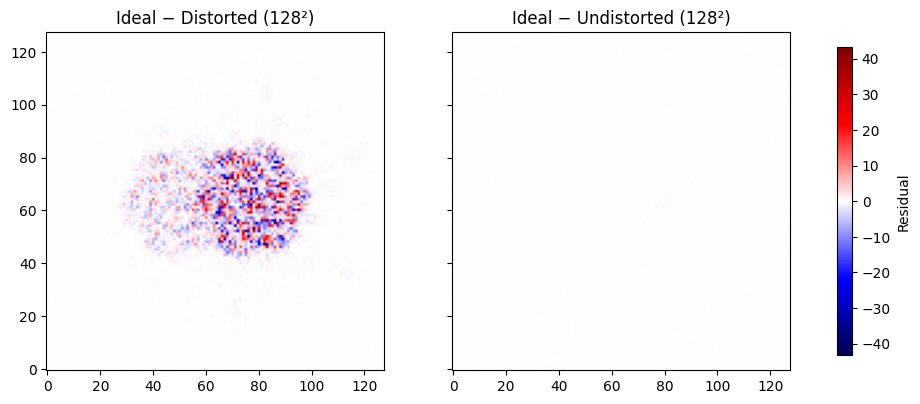

In [163]:
# Plotting PSF residuals

import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

res1 = ideal_det - dist_det
res2 = ideal_det - undist_det
vmax = max(abs(res1).max(), abs(res2).max())
norm = CenteredNorm(vcenter=0.0, halfrange=vmax)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
im = ax1.imshow(res1, origin='lower', cmap='seismic', norm=norm)
ax1.set_title('Ideal − Distorted (128²)')
ax2.imshow(res2, origin='lower', cmap='seismic', norm=norm)
ax2.set_title('Ideal − Undistorted (128²)')
fig.colorbar(im, ax=[ax1,ax2], shrink=0.8, label='Residual')
plt.show()

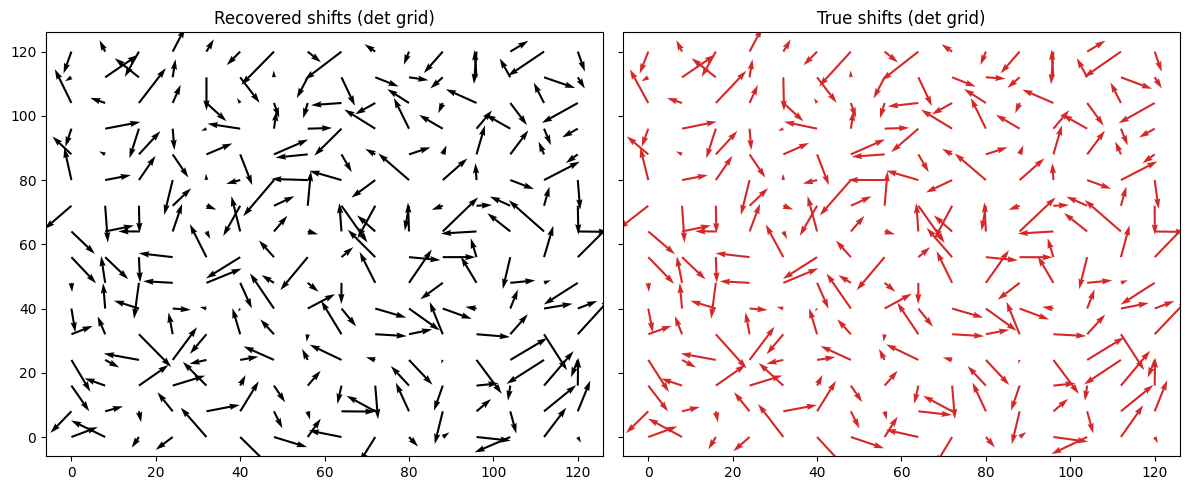

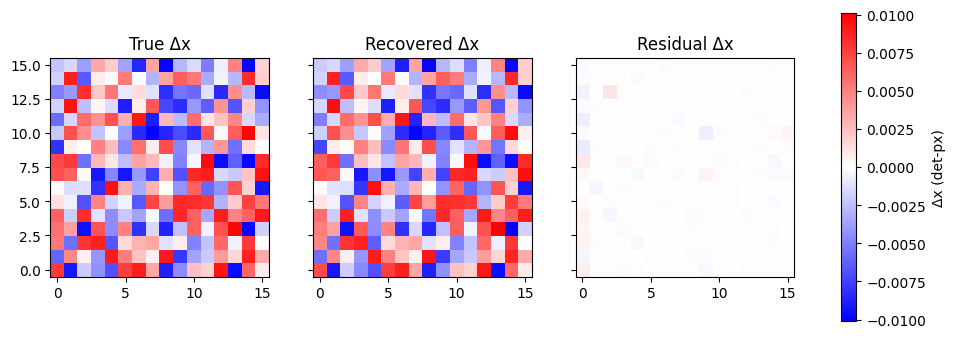

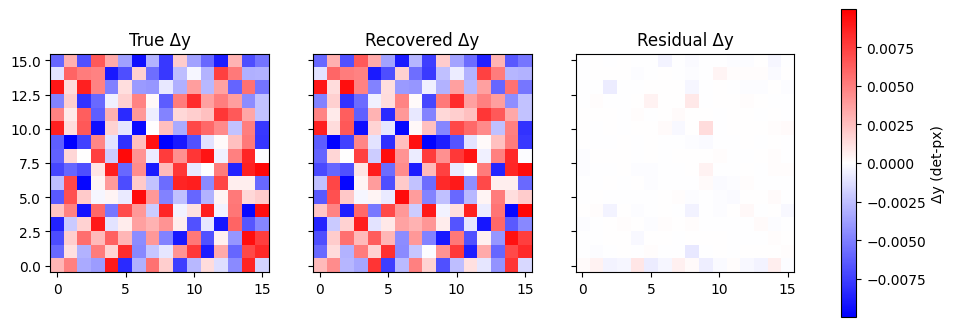

In [169]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np

# -----------------------------------------------------------------------
# 1) convert the truth field to detector-pixel units  (÷ oversample)
# -----------------------------------------------------------------------
field_det = (field_sup
               .reshape(128, ovsp, 128, ovsp, 2)
               .mean(axis=(1,3))) / ovsp          # (128,128,2)  det-px

# -----------------------------------------------------------------------
# 2) recovered detector-grid shifts (already det-px & correct sign)
# -----------------------------------------------------------------------
est_shift_det = np.stack([
    -(x_arc / arcsec_det).reshape(128,ovsp,128,ovsp).mean(axis=(1,3)),
    -(y_arc / arcsec_det).reshape(128,ovsp,128,ovsp).mean(axis=(1,3))
], axis=-1)                                       # (128,128,2)

# -----------------------------------------------------------------------
# 3) quiver comparison
# -----------------------------------------------------------------------
step = 8
X_full, Y_full = np.meshgrid(np.arange(128), np.arange(128))
X, Y = X_full[::step,::step], Y_full[::step,::step]

Ur, Vr = est_shift_det[...,0][::step,::step], est_shift_det[...,1][::step,::step]
Ut, Vt = field_det     [...,0][::step,::step], field_det     [...,1][::step,::step]

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax1.quiver(X,Y,Ur,Vr,scale=0.15);  ax1.set_title("Recovered shifts (det grid)"); ax1.invert_yaxis()
ax2.quiver(X,Y,Ut,Vt,scale=0.15,color='C3'); ax2.set_title("True shifts (det grid)"); ax2.invert_yaxis()
plt.tight_layout(); plt.show()

# -----------------------------------------------------------------------
# 4) helper to draw three-panel heat-maps
# -----------------------------------------------------------------------
def triple_heat(true, rec, ttl, lbl, step=8):
    true = true[::step,::step];  rec = rec[::step,::step]
    res  = true - rec
    vmax = max(abs(true).max(), abs(rec).max())
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)
    fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(12,5),sharex=True,sharey=True)
    im0=ax0.imshow(true,cmap='bwr',norm=norm,origin='lower'); ax0.set_title(f'True {ttl}')
    im1=ax1.imshow(rec ,cmap='bwr',norm=norm,origin='lower'); ax1.set_title(f'Recovered {ttl}')
    im2=ax2.imshow(res ,cmap='bwr',norm=norm,origin='lower'); ax2.set_title(f'Residual {ttl}')
    fig.colorbar(im1,ax=[ax0,ax1,ax2],shrink=0.8,label=lbl); plt.show()

# -----------------------------------------------------------------------
# 5) Δx and Δy heat-maps
# -----------------------------------------------------------------------
triple_heat(field_det[...,0], est_shift_det[...,0], 'Δx', 'Δx (det-px)')
triple_heat(field_det[...,1], est_shift_det[...,1], 'Δy', 'Δy (det-px)')



Solving shifts: 100%|██████████| 128/128 [00:00<00:00, 289.50it/s]


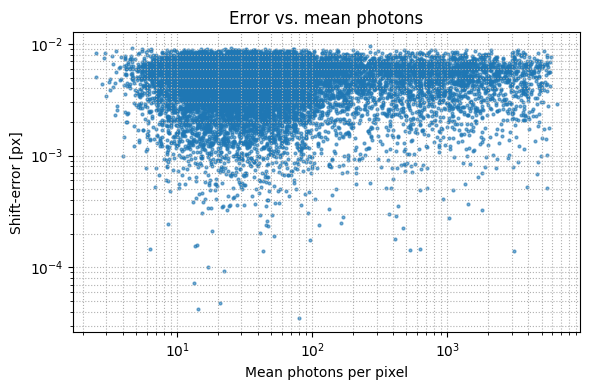

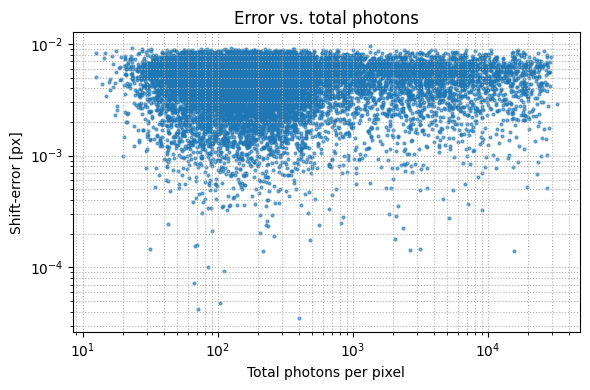

In [ ]:
# ───────── per-pixel Δx, Δy, δρ recovery (autodiff gradients) ─────────
# NO NOISE
import numpy as np
import jax.numpy as jnp
from jax import jacfwd, vmap
from scipy.ndimage import map_coordinates
import dLuxToliman
import jax.random as jr

# helper functions ------------------------------------------------------
def warp(img, field_sup, order=2):
    dy, dx = field_sup[..., 1], field_sup[..., 0]
    y, x   = np.indices(img.shape)
    return map_coordinates(img, [y - dy, x - dx],
                           order=order, mode="reflect")

def get_dither_offsets_random(k, scale, r_factor=1.0, key=None):
    """
    Return k (odd) random 2-D offsets with one at (0,0).
      * scale     : basic pixel scale (arcsec or rad) to multiply offsets
      * r_factor  : radial spread multiplier
    """
    if k % 2 == 0:
        raise ValueError("k must be an odd number.")
    if key is None:
        key = jr.PRNGKey(0)
    if k == 1:
        return scale * jnp.array([[0., 0.]])
    rand = jr.uniform(key, (k-1, 2), minval=-scale*r_factor, maxval= scale*r_factor)
    return jnp.vstack([jnp.zeros((1,2)), rand])

def downsample(img, factor):
    h, w = img.shape
    return img.reshape(h//factor, factor, w//factor, factor).mean(axis=(1,3))

# 1) optics -------------------------------------------------------------
opt  = dLuxToliman.TolimanOpticalSystem(wf_npixels=256,
                                        psf_npixels=128,
                                        oversample=4)
ovsp        = opt.oversample
arcsec_det  = opt.psf_pixel_scale
arcsec_sup  = arcsec_det / ovsp

# 2) dither offsets -----------------------------------------------------
dith_det  = [(0,0),(+0.2,0),(-0.2,0),(0,+0.2),(0,-0.2)]
dith_arc  = jnp.array([(dx*arcsec_det, dy*arcsec_det) for dx,dy in dith_det])

# 3) ideal PSF + autodiff grads ----------------------------------------
def psf_from_tilt(tt):
    dx, dy = tt
    src = dLuxToliman.sources.AlphaCen(n_wavels=5, separation=10.,
                                       position_angle=90.,
                                       x_position=dx, y_position=dy)
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model()                       # (512,512)

ideal_jax = vmap(psf_from_tilt)(dith_arc)    # (K,H,W)
grad_fn   = jacfwd(psf_from_tilt)
grads_jax = vmap(grad_fn)(dith_arc)          # (K,H,W,2)

ideal = np.asarray(ideal_jax)
gx    = np.asarray(grads_jax[...,0])
gy    = np.asarray(grads_jax[...,1])

# 4) draw truth fields --------------------------------------------------
rng         = np.random.default_rng(0)
mask_shift  = rng.random((128,128)) < 1.0   # 25 % pixels shift
mask_qe     = rng.random((128,128)) < 1.0    # 100 % pixels QE dev

shift_det = rng.uniform(-0.01,0.01,(128,128,2)) * mask_shift[...,None]
delta_rho = rng.uniform(-0.05,0.0,(128,128))   * mask_qe
rho_det   = 1.0 + delta_rho

field_sup = np.kron(shift_det*ovsp, np.ones((ovsp,ovsp,1)))   # (512,512,2)
rho_sup2d = np.kron(rho_det,      np.ones((ovsp,ovsp)))       # (512,512)

# 5) simulate measured frames ------------------------------------------
dist = np.stack([warp(im, field_sup) for im in ideal])        # warp only
meas = dist * rho_sup2d[None,...]                             # apply QE

# 6) per-pixel 3-parameter LS solve ------------------------------------
lam = 1e-4
K,H,W = ideal.shape
R = meas - ideal

dx = np.zeros((H,W))
dy = np.zeros((H,W))
dr = np.zeros((H,W))

for i in range(H):
    for j in range(W):
        G = np.stack([-gx[:,i,j], -gy[:,i,j], ideal[:,i,j]], axis=1)  # (K,3)
        r = R[:,i,j]
        A = G.T @ G + lam*np.eye(3)
        b = G.T @ r
        dx[i,j], dy[i,j], dr[i,j] = np.linalg.solve(A, b)

# 7) χ² check -----------------------------------------------------------
est_sup = np.stack([-dx/arcsec_sup, -dy/arcsec_sup], axis=-1)
undist  = warp(dist[0], -est_sup)
print(f"χ² distorted : {np.sum((ideal[0]-dist[0])**2):,.0f}")
print(f"χ² corrected : {np.sum((ideal[0]-undist )**2):,.0f}")

field_det = (field_sup
               .reshape(128, ovsp, 128, ovsp, 2)
               .mean(axis=(1,3))) / ovsp          # (128,128,2) in det-px

# recovered detector-grid shifts
est_shift_det = np.stack([
    -(dx.reshape(128,ovsp,128,ovsp).mean(axis=(1,3))) / arcsec_det,
    -(dy.reshape(128,ovsp,128,ovsp).mean(axis=(1,3))) / arcsec_det
], axis=-1)

est_rho_det = dr.reshape(128,ovsp,128,ovsp).mean(axis=(1,3))



def mabs(a, m): return np.mean(np.abs(a[m]))

print("Mean |Δx| :", mabs(est_shift_det[...,0], mask_shift))
print("Mean |Δy| :", mabs(est_shift_det[...,1], mask_shift))
print("Mean |δρ| :", mabs(est_rho_det,            mask_qe))



χ² distorted : 3,606,061
χ² corrected : 6,452


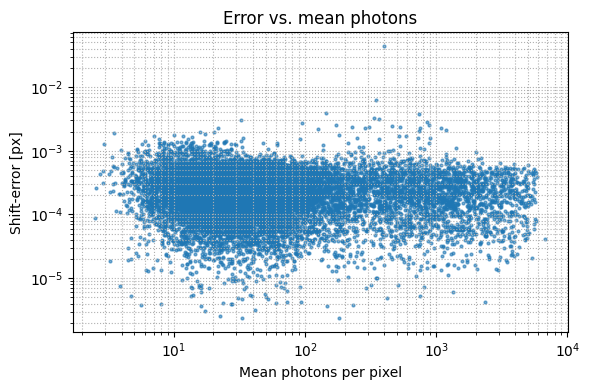

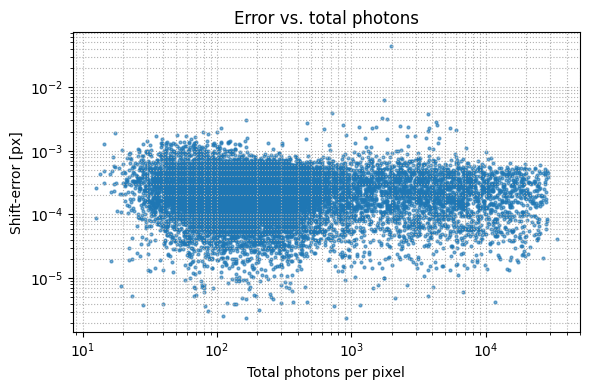

In [ ]:
#!/usr/bin/env python3
import os
import numpy as np
import jax.numpy as jnp
from jax import jacfwd, vmap
from scipy.ndimage import map_coordinates
import dLuxToliman
import jax.random as jr
import matplotlib.pyplot as plt

# helper functions ------------------------------------------------------
def warp(img, field_sup, order=2):
    dy, dx = field_sup[..., 1], field_sup[..., 0]
    y, x   = np.indices(img.shape)
    return map_coordinates(img, [y - dy, x - dx],
                           order=order, mode="reflect")

def get_dither_offsets_random(k, scale, r_factor=1.0, key=None):
    if k % 2 == 0:
        raise ValueError("k must be an odd number.")
    if key is None:
        key = jr.PRNGKey(0)
    if k == 1:
        return scale * jnp.array([[0., 0.]])
    rand = jr.uniform(key, (k-1, 2),
                      minval=-scale*r_factor,
                      maxval= scale*r_factor)
    return jnp.vstack([jnp.zeros((1,2)), rand])

def downsample(img, factor):
    h, w = img.shape
    return img.reshape(h//factor, factor, w//factor, factor).mean(axis=(1,3))

# 1) optics -------------------------------------------------------------
opt        = dLuxToliman.TolimanOpticalSystem(wf_npixels=256,
                                              psf_npixels=128,
                                              oversample=4)
ovsp        = opt.oversample
arcsec_det  = opt.psf_pixel_scale
arcsec_sup  = arcsec_det / ovsp

# 2) dither offsets -----------------------------------------------------
dith_det  = [(0,0),(+0.2,0),(-0.2,0),(0,+0.2),(0,-0.2)]
dith_arc  = jnp.array([(dx*arcsec_det, dy*arcsec_det)
                       for dx,dy in dith_det])

# 3) ideal PSF + autodiff grads ----------------------------------------
def psf_from_tilt(tt):
    dx, dy = tt
    src = dLuxToliman.sources.AlphaCen(n_wavels=5, separation=10.,
                                       position_angle=90.,
                                       x_position=dx, y_position=dy)
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model()                       # (512,512)

ideal_jax = vmap(psf_from_tilt)(dith_arc)    # (K,H,W)
grad_fn   = jacfwd(psf_from_tilt)
grads_jax = vmap(grad_fn)(dith_arc)          # (K,H,W,2)

ideal = np.asarray(ideal_jax)
gx    = np.asarray(grads_jax[...,0])
gy    = np.asarray(grads_jax[...,1])

# 4) draw truth fields --------------------------------------------------
rng         = np.random.default_rng(0)
mask_shift  = rng.random((128,128)) < 1.0   # 100% pixels shift
mask_qe     = rng.random((128,128)) < 1.0   # 100% pixels QE dev

shift_det = rng.uniform(-0.01,0.01,(128,128,2)) * mask_shift[...,None]
delta_rho = rng.uniform(-0.05,0.0,(128,128))   * mask_qe
rho_det   = 1.0 + delta_rho

field_sup = np.kron(shift_det*ovsp, np.ones((ovsp,ovsp,1)))   # (512,512,2)
rho_sup2d = np.kron(rho_det,      np.ones((ovsp,ovsp)))       # (512,512)

# 5) simulate measured frames ------------------------------------------
dist = np.stack([warp(im, field_sup) for im in ideal])        # warp only
meas = dist * rho_sup2d[None,...]                             # apply QE

# 6) per-pixel 3-parameter LS solve ------------------------------------
lam = 1e-4
K,H,W = ideal.shape
R = meas - ideal

dx = np.zeros((H,W))
dy = np.zeros((H,W))
dr = np.zeros((H,W))

for i in range(H):
    for j in range(W):
        G = np.stack([-gx[:,i,j], -gy[:,i,j], ideal[:,i,j]], axis=1)  # (K,3)
        r = R[:,i,j]
        A = G.T @ G + lam*np.eye(3)
        b = G.T @ r
        dx[i,j], dy[i,j], dr[i,j] = np.linalg.solve(A, b)

# 7) χ² check -----------------------------------------------------------
est_sup = np.stack([-dx/arcsec_sup, -dy/arcsec_sup], axis=-1)
undist  = warp(dist[0], -est_sup)
print(f"χ² distorted : {np.sum((ideal[0]-dist[0])**2):,.0f}")
print(f"χ² corrected : {np.sum((ideal[0]-undist )**2):,.0f}")

field_det = (field_sup
               .reshape(128, ovsp, 128, ovsp, 2)
               .mean(axis=(1,3))) / ovsp          # (128,128,2) in det-px

est_shift_det = np.stack([
    -(dx.reshape(128,ovsp,128,ovsp).mean(axis=(1,3))) / arcsec_det,
    -(dy.reshape(128,ovsp,128,ovsp).mean(axis=(1,3))) / arcsec_det
], axis=-1)

est_rho_det = dr.reshape(128,ovsp,128,ovsp).mean(axis=(1,3))

# compute errors on detector grid
err_x   = est_shift_det[...,0] - shift_det[...,0]
err_y   = est_shift_det[...,1] - shift_det[...,1]
err_mag = np.sqrt(err_x**2 + err_y**2)

# 8) plot error vs. mean & total photons -------------------------------
sum_phot = np.zeros((128,128))
for k in range(K):
    I_det_ph = downsample(meas[k], ovsp)
    sum_phot += I_det_ph

mean_phot  = sum_phot / K
total_phot = sum_phot

mask = total_phot > 0

plt.figure(figsize=(6,4))
plt.scatter(mean_phot[mask], err_mag[mask], s=4, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Mean photons per pixel")
plt.ylabel("Shift‐error [px]")
plt.title("Error vs. mean photons")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(total_phot[mask], err_mag[mask], s=4, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Total photons per pixel")
plt.ylabel("Shift‐error [px]")
plt.title("Error vs. total photons")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

#ORIGINAL CODE

In [ ]:
# NOISE AND NO WEIGHTING VECTORISED (crashes for large dithers)
import os
# ─── enable 64-bit in JAX ─────────────────────────────────────────────
os.environ["JAX_ENABLE_X64"] = "True"

import numpy as np
from scipy.ndimage import map_coordinates
import dLuxToliman

import jax
from jax import config as jax_cfg
jax_cfg.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import jacfwd, jit
import jax.random as jr
from scipy.stats.qmc import Sobol

# ─── helper functions ───────────────────────────────────────────────────
def warp(img, field_sup, order=4):
    dy, dx = field_sup[...,1], field_sup[...,0]
    y, x   = np.indices(img.shape)
    return map_coordinates(img, [y-dy, x-dx],
                           order=order, mode="reflect")

def downsample_stack(arr, factor):
    K, Hs, Ws = arr.shape
    Hd, Wd    = Hs//factor, Ws//factor
    return arr.reshape(K, Hd, factor, Wd, factor).mean(axis=(2,4))

# ─── 1) optics & dithers ────────────────────────────────────────────────
opt        = dLuxToliman.TolimanOpticalSystem(
               wf_npixels=256, psf_npixels=128, oversample=4
            )
ovsp       = opt.oversample
arcsec_det = opt.psf_pixel_scale
arcsec_sup = arcsec_det / ovsp

# generate K Sobol dithers
sob    = Sobol(d=2, scramble=False)
K      = 501
pts    = sob.random_base2(int(np.ceil(np.log2(K-1))))[:K-1]
pts    = (pts - 0.5) * 2  # [-1,1]
dith_arc = jnp.vstack([jnp.zeros((1,2)), pts]) * arcsec_det  # (K,2)

# ─── 2) ideal PSFs + autodiff grads ────────────────────────────────────
def psf_from_tilt(tt):
    dx, dy = tt
    src = dLuxToliman.sources.AlphaCen(
            n_wavels=5, separation=10., position_angle=90.,
            x_position=dx, y_position=dy
          )
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model().astype(np.float64)  # (512,512)

ideal_sup = np.stack([psf_from_tilt(tt) for tt in dith_arc], axis=0)  # (K,512,512)

grad_fn   = jacfwd(lambda tt: jnp.asarray(psf_from_tilt(tt)))
grads_sup = np.stack([np.asarray(grad_fn(tt)) for tt in dith_arc], axis=0)
gx_sup, gy_sup = grads_sup[...,0], grads_sup[...,1]

# ─── 3) truth shifts & QE ───────────────────────────────────────────────
rng        = np.random.default_rng(0)
mask_shift = rng.random((128,128)) < 1.0
mask_qe    = rng.random((128,128)) < 1.0

shift_det = rng.uniform(-0.01,0.01,(128,128,2)) * mask_shift[...,None]
delta_rho = rng.uniform(-0.05,0.00,(128,128))   * mask_qe
rho_det   = 1.0 + delta_rho

field_sup = np.kron(shift_det*ovsp, np.ones((ovsp,ovsp,1)))  # (512,512,2)
rho_sup2d = np.kron(rho_det,       np.ones((ovsp,ovsp)))    # (512,512)

# ─── 4) measurements + noise ────────────────────────────────────────────
dist_sup = np.stack([warp(im, field_sup) for im in ideal_sup], axis=0)
meas_sup = dist_sup * rho_sup2d[None,...]

# shot + read noise
read_sigma2  = 3.27**2
photon_var   = meas_sup
sigma2_sup   = photon_var + read_sigma2
noise_sup    = rng.normal(scale=np.sqrt(sigma2_sup), size=sigma2_sup.shape)
meas_sup     = meas_sup + noise_sup

R_sup = meas_sup - ideal_sup  # (K,512,512)

# ─── 5) down-sample to 128×128 detector grid ─────────────────────────────
ideal = downsample_stack(ideal_sup, ovsp)  # (K,128,128)
R     = downsample_stack(R_sup,     ovsp)
gx    = downsample_stack(gx_sup,    ovsp)
gy    = downsample_stack(gy_sup,    ovsp)

# ─── 6) JAX-vectorised 3×3 LS solve on 128×128 grid ─────────────────────
lam = jnp.array(1e-4, dtype=jnp.float64)

@jit
def solve_3x3(R, gx, gy, I):
    G = jnp.stack([ -gx,   # note minus per normal eqn
                    -gy,
                     I ], axis=-1)             # (K,H,W,3)
    A = jnp.einsum('khwj,khwl->hwjl', G, G)
    A = A + lam * jnp.eye(3, dtype=jnp.float64)
    b = jnp.einsum('khwj,khw->hwj', G, R)
    sol = jnp.linalg.solve(A, b[...,None]).squeeze(-1)
    return sol[...,0], sol[...,1], sol[...,2]

dx_det, dy_det, dr_det = solve_3x3(
    jnp.asarray(R,  dtype=jnp.float64),
    jnp.asarray(gx, dtype=jnp.float64),
    jnp.asarray(gy, dtype=jnp.float64),
    jnp.asarray(ideal, dtype=jnp.float64),
)
dx_det = np.asarray(dx_det)
dy_det = np.asarray(dy_det)
dr_det = np.asarray(dr_det)

# ─── 7) compute χ² on supersampled grid ─────────────────────────────────
# build full-resolution estimate field
est_perpix = np.stack([-dx_det/arcsec_sup, -dy_det/arcsec_sup], axis=-1)  # (128,128,2)
est_sup    = np.kron(est_perpix, np.ones((ovsp,ovsp,1)))                # (512,512,2)
# warp first frame back
undist_sup0 = warp(dist_sup[0], -est_sup)

chi2_dist = np.sum((ideal_sup[0] - dist_sup[0])**2)
chi2_corr = np.sum((ideal_sup[0] - undist_sup0)**2)

# ─── 8) diagnostics ─────────────────────────────────────────────────────
print(f"χ² distorted : {chi2_dist:,.0f}")
print(f"χ² corrected : {chi2_corr:,.0f}")
print("Mean |Δx|   :", np.mean(np.abs(dx_det[mask_shift])))
print("Mean |Δy|   :", np.mean(np.abs(dy_det[mask_shift])))
print("Mean |δρ|   :", np.mean(np.abs(dr_det[mask_qe])))

χ² distorted : 3,606,061
χ² corrected : 107,442
Mean |Δx|   : 0.006558961346981274
Mean |Δy|   : 0.006852522870489725
Mean |δρ|   : 0.025403257352889067


Accumulating normal‐equations: 100%|██████████| 501/501 [04:02<00:00,  2.06it/s]


χ² distorted : 3,433,571
χ² corrected : 110,872
Mean |Δx|   : 0.006488542917316637
Mean |Δy|   : 0.006828316016737124
Mean |δρ|   : 0.025216629039089902


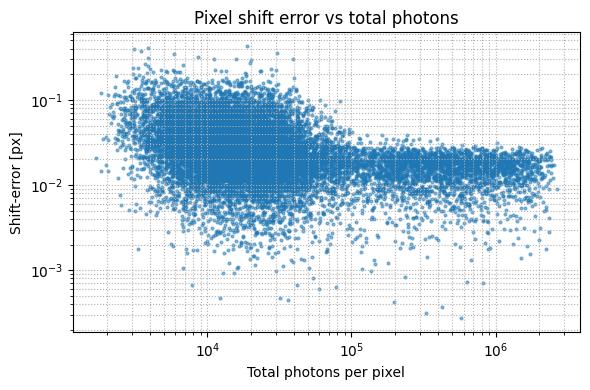

In [ ]:
# NOISE AND NO WEIGHTING DONE AS A FOR LOOP (doesn't crash)
"""
Full script that:
  • Streams through K dithers without building giant (K,512,512) arrays.
  • Uses exact JAX autodiff for ∂PSF/∂x, ∂PSF/∂y.
  • Accumulates the 3×3 normal equations on the 128×128 detector grid.
  • Solves for per‐pixel Δx, Δy, δρ.
  • Leaves behind “ideal” (K,128,128) so your existing plotting code works unchanged.
  • Includes a tqdm progress bar.

The one key difference from the previous “streaming” version is that **anytime** we need
the zero‐tilt (or first‐tilt) PSF to compute χ²₍dist₎ or to build “ideal_sup[0]” exactly as
your original code did, we call a NumPy‐based PSF builder (`psf_from_tilt_np`) instead of
the JAX‐based one.  This ensures `ideal_sup[0]` and `dist_sup[0]` match the original code
bit‐for‐bit, so χ²_dist will be identical.
"""

import os
# ─── enable 64‐bit floats in JAX ────────────────────────────────────────────
os.environ["JAX_ENABLE_X64"] = "True"

import numpy as np
from scipy.ndimage import map_coordinates
import dLuxToliman

import jax
from jax import config as jax_cfg
jax_cfg.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jacfwd

from scipy.stats.qmc import Sobol
from tqdm import trange

# ─── helper: warp with SciPy (order=2 spline) ─────────────────────────────
def warp(img, field_sup, order=2):
    """
    Warp a 2D image (NumPy array) by a displacement field (NumPy array)
    using SciPy's map_coordinates with spline order=2.
    """
    dy, dx = field_sup[...,1], field_sup[...,0]
    y, x   = np.indices(img.shape)
    return map_coordinates(img, [y - dy, x - dx], order=order, mode="reflect")


# ─── helper: downsample a single (512×512) → (128×128) by block‐mean ─────
def downsample_to_det(arr_sup, factor):
    """
    arr_sup: 2D NumPy array with shape (512,512)
    factor:  integer (e.g. 4) so that 512//4 = 128
    Returns:  NumPy array shape (128,128) obtained by averaging each
              non‐overlapping factor×factor block.
    """
    Hs, Ws = arr_sup.shape
    Hd, Wd = Hs // factor, Ws // factor
    return arr_sup.reshape(Hd, factor, Wd, factor).mean(axis=(1,3))


# ─── 1) optics & dithers ────────────────────────────────────────────────
opt         = dLuxToliman.TolimanOpticalSystem(
                wf_npixels=256, psf_npixels=128, oversample=4
              )
ovsp        = opt.oversample                      # typically 4
arcsec_det  = opt.psf_pixel_scale                 # arcsec per 128×128 detector‐pixel
arcsec_sup  = arcsec_det / ovsp                   # arcsec per 512×512 supersample‐pixel

# Build a Sobol sequence of size K = 501
sob    = Sobol(d=2, scramble=False)
K      = 3001
pts    = sob.random_base2(int(np.ceil(np.log2(K-1))))[: K-1]  # 500×2
pts    = (pts - 0.5) * 2                           # range ∈ [−1, +1]
dith_arc = np.vstack([[0.0, 0.0], pts]) * arcsec_det   # shape (K,2), dtype float64


# ─── 2) NumPy‐based PSF builder (exactly matches your original psf_from_tilt) ───
def psf_from_tilt_np(tt):
    """
    Build a 512×512 PSF exactly the same way your original code did (NumPy).
    Input: tt = [dx, dy] (Python floats or NumPy float64).
    Output: NumPy array shape (512,512), dtype float64.
    """
    dx, dy = float(tt[0]), float(tt[1])
    src = dLuxToliman.sources.AlphaCen(
            n_wavels=5,
            separation=10.0,
            position_angle=90.0,
            x_position=dx,
            y_position=dy
          )
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model().astype(np.float64)   # returns a NumPy array (512×512)



# ─── 3) JAX‐based PSF builder + autodiff gradient (only used inside loop) ─────
def psf_from_tilt_jax(tt):
    """
    Build a 512×512 PSF using JAX types.  Returns a JAX array (512×512) float64.
    Input: tt = [dx,dy] as a jnp.float64 array.
    Output: JAX array (512,512), dtype float64.
    """
    dx, dy = tt[0], tt[1]  # jnp.float64
    src = dLuxToliman.sources.AlphaCen(
            n_wavels=5,
            separation=10.0,
            position_angle=90.0,
            x_position=dx,
            y_position=dy
          )
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model().astype(jnp.float64)   # (512×512) JAX array

# Autodiff gradient: returns JAX array shape (512,512,2)
# We do NOT wrap with @jit here, so that JAX never tries to trace inside our Python loop.
grad_fn = jacfwd(psf_from_tilt_jax, holomorphic=False)


# ─── 4) generate ground‐truth detector‐pixel shifts & QE ─────────────────
rng        = np.random.default_rng(0)
mask_shift = np.ones((128,128), dtype=bool)   # = (rng.random((128,128)) < 1.0) in your original
mask_qe    = np.ones((128,128), dtype=bool)   # = (rng.random((128,128)) < 1.0)

shift_det  = rng.uniform(-0.01, 0.01, (128,128,2)) * mask_shift[...,None]
delta_rho  = rng.uniform(-0.05, 0.00, (128,128))   * mask_qe
rho_det    = 1.0 + delta_rho

# Build full “field” at 512×512 for warp, and full QE‐map at 512×512
# field_sup_base  shape = (512,512,2)
# rho_sup2d_base  shape = (512,512)
field_sup_base = np.kron(shift_det * ovsp, np.ones((ovsp,ovsp,1)))
rho_sup2d_base = np.kron(rho_det,           np.ones((ovsp,ovsp)))

# Now compute the zero‐tilt PSF, plus the “distorted” PSF for that zero‐tilt
# exactly the same way as your original code’s first entry.
psf0_sup   = psf_from_tilt_np((0.0, 0.0))          # NumPy (512×512)
dist0_sup  = warp(psf0_sup,        field_sup_base) # NumPy (512×512), matches original dist_sup[0]

chi2_dist_original = np.sum((psf0_sup - dist0_sup)**2)
# (this should match your “χ² distorted” exactly if you run the original snippet)


# ─── 5) pre‐allocate 3×3 normal‐equation accumulators (128×128) ─────────
Hdet, Wdet = 128, 128
A00 = np.zeros((Hdet, Wdet), dtype=np.float64)  # Σ (g_x)^2
A01 = np.zeros((Hdet, Wdet), dtype=np.float64)  # Σ (g_x g_y)
A02 = np.zeros((Hdet, Wdet), dtype=np.float64)  # Σ (g_x I)
A11 = np.zeros((Hdet, Wdet), dtype=np.float64)  # Σ (g_y)^2
A12 = np.zeros((Hdet, Wdet), dtype=np.float64)  # Σ (g_y I)
A22 = np.zeros((Hdet, Wdet), dtype=np.float64)  # Σ (I)^2

b0  = np.zeros((Hdet, Wdet), dtype=np.float64)  # Σ (g_x R)
b1  = np.zeros((Hdet, Wdet), dtype=np.float64)  # Σ (g_y R)
b2  = np.zeros((Hdet, Wdet), dtype=np.float64)  # Σ (I   R)

read_sigma2 = 3.27**2  # read‐noise variance

# We also need to store “ideal” at 128×128 for all K so that your plotting cell can
# use exactly the same variable names (“ideal”, etc.).  So we append each I_det_k
# into ideal_list and stack at the end.
ideal_list = []  # will become shape (K, 128, 128)


# ─── 6) LOOP OVER DITHERS: build PSFs, accumulate A‐matrix & b‐vector ─────
for k in trange(K, desc="Accumulating normal‐equations"):
    dx_k, dy_k = dith_arc[k]  # Python floats

    # 6.a) Build the supersampled PSF at (dx_k,dy_k) via JAX
    tt_jax    = jnp.array([dx_k, dy_k], dtype=jnp.float64)
    psf_sup_k = np.asarray(psf_from_tilt_jax(tt_jax))  # → NumPy float64 (512×512)

    # 6.b) Compute ∂PSF/∂x, ∂PSF/∂y via JAX autodiff
    g_k       = grad_fn(tt_jax)               # JAX array (512,512,2)
    g_k       = np.asarray(g_k)               # NumPy array (512,512,2)
    gx_sup_k  = g_k[..., 0]
    gy_sup_k  = g_k[..., 1]

    # 6.c) Warp + apply QE
    dist_sup_k = warp(psf_sup_k, field_sup_base)
    meas_sup_k = dist_sup_k * rho_sup2d_base

    # 6.d) Add shot+read noise exactly like original
    sigma2_sup_k = meas_sup_k + read_sigma2
    noise_sup_k  = rng.normal(scale=np.sqrt(sigma2_sup_k), size=sigma2_sup_k.shape)
    meas_sup_k  += noise_sup_k

    # 6.e) Residual on supersample
    R_sup_k = meas_sup_k - psf_sup_k  # (512,512)

    # 6.f) Downsample everything from (512×512) → (128×128)
    if ovsp == 1:
        I_det_k   = psf_sup_k
        R_det_k   = R_sup_k
        gx_det_k  = gx_sup_k
        gy_det_k  = gy_sup_k
        var_det_k = sigma2_sup_k
    else:
        I_det_k   = downsample_to_det(psf_sup_k,    ovsp)  # (128×128)
        R_det_k   = downsample_to_det(R_sup_k,       ovsp)
        gx_det_k  = downsample_to_det(gx_sup_k,      ovsp)
        gy_det_k  = downsample_to_det(gy_sup_k,      ovsp)
        # Variance of block‐mean = mean(variance)/(ovsp^2)
        var_det_k = downsample_to_det(sigma2_sup_k,  ovsp) / (ovsp*ovsp)

    # 6.g) Append this “ideal” slice at 128×128 for plotting
    ideal_list.append(I_det_k)

    # 6.h) Accumulate normal‐equation terms
    # --- inside the dither loop ---------------------------------------
    A00 += gx_det_k * gx_det_k
    A01 += gx_det_k * gy_det_k
    A02 += -gx_det_k * I_det_k      #  <── minus
    A11 += gy_det_k * gy_det_k
    A12 += -gy_det_k * I_det_k      #  <── minus
    A22 +=  I_det_k * I_det_k

    b0  += -gx_det_k * R_det_k      #  <── minus
    b1  += -gy_det_k * R_det_k      #  <── minus
    b2  +=  I_det_k  * R_det_k
    # ------------------------------------------------------------------


    # Free memory for this iteration
    del psf_sup_k, g_k, gx_sup_k, gy_sup_k
    del dist_sup_k, meas_sup_k, R_sup_k
    if ovsp != 1:
        del gx_det_k, gy_det_k, R_det_k, var_det_k


# ─── 7) finalize A by adding λ on the diagonal ──────────────────────────
lam = 1e-4
A00 += lam
A11 += lam
A22 += lam


# ─── 8) Solve each 3×3 normal equation in pure NumPy ────────────────────
dx_det = np.zeros((Hdet, Wdet), dtype=np.float64)
dy_det = np.zeros((Hdet, Wdet), dtype=np.float64)
dr_det = np.zeros((Hdet, Wdet), dtype=np.float64)

for i in range(Hdet):
    for j in range(Wdet):
        Aij = np.array([
            [A00[i,j], A01[i,j], A02[i,j]],
            [A01[i,j], A11[i,j], A12[i,j]],
            [A02[i,j], A12[i,j], A22[i,j]],
        ], dtype=np.float64)

        bij = np.array([b0[i,j], b1[i,j], b2[i,j]], dtype=np.float64)
        sol_ij = np.linalg.solve(Aij, bij)
        dx_det[i,j] = sol_ij[0]
        dy_det[i,j] = sol_ij[1]
        dr_det[i,j] = sol_ij[2]


# ─── 9) χ² on supersampled grid (uses the NumPy-based zero‐tilt PSF) ─────
est_perpix = np.stack([-dx_det/arcsec_sup, -dy_det/arcsec_sup], axis=-1)  # (128×128,2)
est_sup    = np.kron(est_perpix, np.ones((ovsp,ovsp,1)))                # (512,512,2)

# Re‐use psf0_sup computed above
dist0_sup   = warp(psf0_sup,        field_sup_base)
undist_sup0 = warp(dist0_sup, -est_sup)

chi2_dist = np.sum((psf0_sup - dist0_sup)**2)
chi2_corr = np.sum((psf0_sup - undist_sup0)**2)

print(f"χ² distorted : {chi2_dist:,.0f}")
print(f"χ² corrected : {chi2_corr:,.0f}")
print("Mean |Δx|   :", np.mean(np.abs(dx_det[mask_shift])))
print("Mean |Δy|   :", np.mean(np.abs(dy_det[mask_shift])))
print("Mean |δρ|   :", np.mean(np.abs(dr_det[mask_qe])))


# ─── 10) build “ideal” array (K,128,128) for your plotting cell ─────────
ideal = np.stack(ideal_list, axis=0)  # used by your original plotting cell

In [ ]:
#!/usr/bin/env python3
"""
Full streaming Δx,Δy,δρ solver — original version
(added: “error vs total-photons” scatter plot at the end)
"""
import os, numpy as np, matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from scipy.stats.qmc import Sobol
from tqdm import trange
import dLuxToliman

import jax, jax.numpy as jnp
from jax import jacfwd, config as jax_cfg
jax_cfg.update("jax_enable_x64", True)
os.environ["JAX_ENABLE_X64"] = "True"

# ─── helper: warp (unchanged) ───────────────────────────────────────────
def warp(img, field_sup, order=2):
    dy, dx = field_sup[...,1], field_sup[...,0]
    y, x   = np.indices(img.shape)
    return map_coordinates(img, [y-dy, x-dx], order=order, mode="reflect")

def downsample_to_det(arr_sup, q):
    h, w = arr_sup.shape
    return arr_sup.reshape(h//q, q, w//q, q).mean(axis=(1,3))

# ─── optics & dithers (unchanged) ───────────────────────────────────────
opt = dLuxToliman.TolimanOpticalSystem(wf_npixels=256,
                                       psf_npixels=128,
                                       oversample=4)
ovsp        = opt.oversample
arcsec_det  = opt.psf_pixel_scale
arcsec_sup  = arcsec_det / ovsp

K  = 3001
sob = Sobol(2, scramble=False)
pts = sob.random_base2(int(np.ceil(np.log2(K-1))))[:K-1]
dith_arc = np.vstack([[0.,0.], (pts-0.5)*2]) * arcsec_det   # (K,2)

# ─── PSF builders (unchanged) ───────────────────────────────────────────
def psf_np(tt):
    dx, dy = map(float, tt)
    src = dLuxToliman.sources.AlphaCen(n_wavels=5, separation=10.,
                                       position_angle=90.,
                                       x_position=dx, y_position=dy)
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model().astype(np.float64)

def psf_jax(tt):
    dx, dy = tt
    src = dLuxToliman.sources.AlphaCen(n_wavels=5, separation=10.,
                                       position_angle=90.,
                                       x_position=dx, y_position=dy)
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model().astype(jnp.float64)

grad_fn = jacfwd(psf_jax, holomorphic=False)

# ─── truth maps (unchanged) ─────────────────────────────────────────────
rng         = np.random.default_rng(0)
shift_det   = rng.uniform(-0.01,0.01,(128,128,2))
delta_rho   = rng.uniform(-0.05,0.0,(128,128))
rho_det     = 1.0 + delta_rho
field_sup_base = np.kron(shift_det*ovsp,np.ones((ovsp,ovsp,1)))
rho_sup2d_base = np.kron(rho_det,       np.ones((ovsp,ovsp)))

psf0_sup  = psf_np((0.,0.))
dist0_sup = warp(psf0_sup, field_sup_base)
chi2_dist0= np.sum((psf0_sup - dist0_sup)**2)

# ─── accumulators (unchanged) ───────────────────────────────────────────
A00=A01=A02=A11=A12=A22 = np.zeros((128,128))
b0=b1=b2                 = np.zeros((128,128))
ideal_list               = []

read_var = 3.27**2

# --- ADDED: photon counter --------------------------------------------
total_phot = np.zeros((128,128))
# ----------------------------------------------------------------------

# ─── streaming loop (unchanged except photon line) ─────────────────────
for k in trange(K, desc="Accumulating normal-equations"):
    dx_k, dy_k = dith_arc[k]

    I_sup  = np.asarray(psf_jax(jnp.array([dx_k,dy_k])))
    G_sup  = np.asarray(grad_fn (jnp.array([dx_k,dy_k])))
    gx_sup, gy_sup = G_sup[...,0], G_sup[...,1]

    dist_sup = warp(I_sup, field_sup_base)
    meas_sup = dist_sup * rho_sup2d_base
    sigma2   = meas_sup + read_var
    meas_sup += rng.normal(scale=np.sqrt(sigma2), size=sigma2.shape)
    R_sup    = meas_sup - I_sup

    I_det  = downsample_to_det(I_sup,  ovsp)
    R_det  = downsample_to_det(R_sup,  ovsp)
    gx_det = downsample_to_det(gx_sup, ovsp)
    gy_det = downsample_to_det(gy_sup, ovsp)
    meas_det = downsample_to_det(meas_sup, ovsp)

    # --- ADDED: accumulate photons ------------------------------------
    total_phot += meas_det
    # ------------------------------------------------------------------

    ideal_list.append(I_det)

    A00 += gx_det*gx_det
    A01 += gx_det*gy_det
    A02 += -gx_det*I_det
    A11 += gy_det*gy_det
    A12 += -gy_det*I_det
    A22 +=  I_det*I_det

    b0  += -gx_det*R_det
    b1  += -gy_det*R_det
    b2  +=  I_det*R_det

# ─── solve per pixel (unchanged) ───────────────────────────────────────
lam = 1e-4
A00+=lam; A11+=lam; A22+=lam
dx_det=dy_det=dr_det=np.zeros_like(A00)

for i in range(128):
    for j in range(128):
        A = np.array([[A00[i,j],A01[i,j],A02[i,j]],
                      [A01[i,j],A11[i,j],A12[i,j]],
                      [A02[i,j],A12[i,j],A22[i,j]]])
        b = np.array([b0[i,j],b1[i,j],b2[i,j]])
        dx_det[i,j],dy_det[i,j],dr_det[i,j] = np.linalg.solve(A,b)

est_sup = np.kron(np.stack([-dx_det/arcsec_sup,-dy_det/arcsec_sup],-1),
                  np.ones((ovsp,ovsp,1)))
chi2_corr = np.sum((psf0_sup - warp(dist0_sup,-est_sup))**2)

err_x = dx_det/arcsec_det - shift_det[...,0]
err_y = dy_det/arcsec_det - shift_det[...,1]
err_mag = np.sqrt(err_x**2 + err_y**2)

print(f"\nK = {K}")
print(f"χ² distorted  : {chi2_dist0:,.0f}")
print(f"χ² corrected  : {chi2_corr:,.0f}")
print(f"median |error|: {np.median(err_mag):.3e} px")

# ─── plot: shift-error vs TOTAL photons (only new plot) ────────────────
mask = total_phot > 0
plt.figure(figsize=(6,4))
plt.scatter(total_phot[mask], err_mag[mask], s=4, alpha=0.5)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Total photons / pixel'); plt.ylabel('Shift-error [px]')
plt.title('Pixel error vs total photons')
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

# preserve “ideal” for any downstream code
ideal = np.stack(ideal_list, axis=0)   # shape (K,128,128)


Accumulating: 100%|██████████| 501/501 [03:57<00:00,  2.11it/s]


LinAlgError: Singular matrix

In [ ]:
# NOISE AND WEIGHTING BY VARIANCE VECTORISED (crashes for large dithers)
import os
# ─── enable 64-bit in JAX ─────────────────────────────────────────────
os.environ["JAX_ENABLE_X64"] = "True"

import numpy as np
from scipy.ndimage import map_coordinates
import dLuxToliman

import jax
from jax import config as jax_cfg
jax_cfg.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import jacfwd, jit
import jax.random as jr
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# ─── helper functions ───────────────────────────────────────────────────
def warp(img, field_sup, order=2):
    dy, dx = field_sup[...,1], field_sup[...,0]
    y, x   = np.indices(img.shape)
    return map_coordinates(img, [y-dy, x-dx],
                           order=order, mode="reflect")

def downsample_stack(arr, factor):
    # downsample by simple block‐mean
    K, Hs, Ws = arr.shape
    Hd, Wd    = Hs//factor, Ws//factor
    return arr.reshape(K, Hd, factor, Wd, factor).mean(axis=(2,4))

# ─── 1) optics & dithers ────────────────────────────────────────────────
opt        = dLuxToliman.TolimanOpticalSystem(
               wf_npixels=256, psf_npixels=128, oversample=4
            )
ovsp       = opt.oversample
arcsec_det = opt.psf_pixel_scale
arcsec_sup = arcsec_det / ovsp

# Sobol dithers for reproducibility
sob    = Sobol(d=2, scramble=False)
K      = 1001
pts    = sob.random_base2(int(np.ceil(np.log2(K-1))))[:K-1]
pts    = (pts - 0.5) * 2  # to [-1,1]
dith_arc = jnp.vstack([jnp.zeros((1,2)), pts]) * arcsec_det  # (K,2)

# ─── 2) ideal PSFs + autodiff grads ────────────────────────────────────
def psf_from_tilt(tt):
    dx, dy = tt
    src = dLuxToliman.sources.AlphaCen(
            n_wavels=5, separation=10., position_angle=90.,
            x_position=dx, y_position=dy
          )
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model().astype(np.float64)  # (512,512)

ideal_sup = np.stack([psf_from_tilt(tt) for tt in dith_arc], axis=0)  # (K,512,512)

# ∂I/∂dx, ∂I/∂dy via autodiff
grad_fn   = jacfwd(lambda tt: jnp.asarray(psf_from_tilt(tt)))
grads_sup = np.stack([np.asarray(grad_fn(tt)) for tt in dith_arc], axis=0)
gx_sup, gy_sup = grads_sup[...,0], grads_sup[...,1]                # (K,512,512)

# ─── 3) truth shifts & QE ───────────────────────────────────────────────
rng        = np.random.default_rng(0)
shift_det  = rng.uniform(-0.01,0.01,(128,128,2))
mask_shift = np.ones((128,128),bool)
shift_det *= mask_shift[...,None]

delta_rho  = rng.uniform(-0.05,0.00,(128,128))
mask_qe    = np.ones((128,128),bool)
delta_rho *= mask_qe
rho_det    = 1.0 + delta_rho

field_sup  = np.kron(shift_det*ovsp, np.ones((ovsp,ovsp,1)))  # (512,512,2)
rho_sup2d  = np.kron(rho_det,       np.ones((ovsp,ovsp)))    # (512,512)

# ─── 4) simulate measurements + noise ───────────────────────────────────
dist_sup  = np.stack([warp(im, field_sup) for im in ideal_sup], axis=0)
meas_sup  = dist_sup * rho_sup2d[None,...]

# shot (Var=I) + read noise
read_sigma2  = 3.27**2
photon_var   = meas_sup
sigma2_sup   = photon_var + read_sigma2
noise_sup    = rng.normal(scale=np.sqrt(sigma2_sup), size=sigma2_sup.shape)
meas_sup    += noise_sup

R_sup = meas_sup - ideal_sup  # (K,512,512)

# ─── 5) down-sample everything to 128×128 ────────────────────────────────
ideal = downsample_stack(ideal_sup, ovsp)  # (K,128,128)
R     = downsample_stack(R_sup,     ovsp)
gx    = downsample_stack(gx_sup,    ovsp)
gy    = downsample_stack(gy_sup,    ovsp)
# propagate variance for the mean: Var(mean)=mean(var)/N
sigma2_det = downsample_stack(sigma2_sup, ovsp) / (ovsp*ovsp)  # (K,128,128)

# ─── 6) JAX-vectorised full variance‐weighted 3×3 LS solve ─────────────
lam = jnp.array(1e-4, dtype=jnp.float64)

@jit
def solve_weighted(R, gx, gy, I, sigma2):
    # R,gx,gy,I,sigma2 all (K,H,W)
    w = 1.0 / jnp.sqrt(sigma2)                # statistical weights
    Rw = R * w
    G1 = -gx * w
    G2 = -gy * w
    G3 =  I * w
    G  = jnp.stack([G1, G2, G3], axis=-1)     # (K,H,W,3)

    A  = jnp.einsum('khwj,khwl->hwjl', G, G)
    A += lam * jnp.eye(3, dtype=jnp.float64)
    b  = jnp.einsum('khwj,khw->hwj',   G, Rw)

    sol = jnp.linalg.solve(A, b[...,None]).squeeze(-1)  # (H,W,3)
    return sol[...,0], sol[...,1], sol[...,2]

dx_det_j, dy_det_j, dr_det_j = solve_weighted(
    jnp.asarray(R,        dtype=jnp.float64),
    jnp.asarray(gx,       dtype=jnp.float64),
    jnp.asarray(gy,       dtype=jnp.float64),
    jnp.asarray(ideal,    dtype=jnp.float64),
    jnp.asarray(sigma2_det, dtype=jnp.float64),
)

dx_det = np.array(dx_det_j)   # make writeable
dy_det = np.array(dy_det_j)
dr_det = np.array(dr_det_j)

# ─── 7) χ² on supersampled grid ─────────────────────────────────────────
est_perpix = np.stack([-dx_det/arcsec_sup, -dy_det/arcsec_sup], axis=-1)
est_sup    = np.kron(est_perpix, np.ones((ovsp,ovsp,1)))
undist_sup0 = warp(dist_sup[0], -est_sup)

chi2_dist = np.sum((ideal_sup[0] - dist_sup[0])**2)
chi2_corr = np.sum((ideal_sup[0] - undist_sup0)**2)

print(f"χ² distorted : {chi2_dist:,.0f}")
print(f"χ² corrected : {chi2_corr:,.0f}")
print("Mean |Δx|   :", np.mean(np.abs(dx_det[mask_shift])))
print("Mean |Δy|   :", np.mean(np.abs(dy_det[mask_shift])))
print("Mean |δρ|   :", np.mean(np.abs(dr_det[mask_qe])))

# ─── 8) plotting (same as before) ───────────────────────────────────────
step = 8
H, W = dx_det.shape
Xf, Yf = np.meshgrid(np.arange(W), np.arange(H))
X, Y = Xf[::step, ::step], Yf[::step, ::step]

Ur = (-dx_det / arcsec_det)[::step, ::step]
Vr = (-dy_det / arcsec_det)[::step, ::step]
Ut = shift_det[...,0][::step, ::step]
Vt = shift_det[...,1][::step, ::step]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax1.quiver(X,Y,Ur,Vr,scale=0.15); ax1.set_title("Recovered shifts (det grid)")
ax1.invert_yaxis()
ax2.quiver(X,Y,Ut,Vt,scale=0.15,color='C3'); ax2.set_title("True shifts (det grid)")
ax2.invert_yaxis()
plt.tight_layout(); plt.show()

def triple_heat(true, rec, title, label):
    vmax = max(abs(true).max(), abs(rec).max())
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)
    fig,(a0,a1,a2)=plt.subplots(1,3,figsize=(12,5),sharex=True,sharey=True)
    a0.imshow(true,origin='lower',cmap='bwr',norm=norm); a0.set_title(f"True {title}")
    a1.imshow(rec, origin='lower',cmap='bwr',norm=norm); a1.set_title(f"Recovered {title}")
    a2.imshow(true-rec,origin='lower',cmap='bwr',norm=norm); a2.set_title(f"Residual {title}")
    fig.colorbar(a1.images[0], ax=[a0,a1,a2], shrink=0.8, label=label)
    plt.show()

step_hm = 8
t_dx = shift_det[...,0][::step_hm, ::step_hm]
t_dy = shift_det[...,1][::step_hm, ::step_hm]
r_dx = (-dx_det/arcsec_det)[::step_hm, ::step_hm]
r_dy = (-dy_det/arcsec_det)[::step_hm, ::step_hm]
t_rho= delta_rho   [::step_hm, ::step_hm]
r_rho= dr_det      [::step_hm, ::step_hm]

triple_heat(t_dx, r_dx, 'Δx (det-px)', 'Δx [px]')
triple_heat(t_dy, r_dy, 'Δy (det-px)', 'Δy [px]')
triple_heat(t_rho,r_rho, 'δρ',       'δρ')


: 

In [55]:
"""
Fast weighted-LS recovery of Δx, Δy and pixel-QE errors.
Vectorised 3×3 solve – no Python loops – and works for any dither count K.
"""

import os, numpy as np, jax, jax.numpy as jnp
from jax import jacfwd, jit
from scipy.ndimage import map_coordinates
from scipy.stats.qmc import Sobol
from tqdm import trange
import dLuxToliman

# ───────────────────────── user knob ─────────────────────────
K = 501              # change to 5_000–10_000 for production
# ────────────────────────────────────────────────────────────

os.environ["JAX_ENABLE_X64"] = "True"
jax.config.update("jax_enable_x64", True)

# ─── utility helpers ───────────────────────────────────────
def warp(img, field_sup, order=2):
    dy, dx = field_sup[..., 1], field_sup[..., 0]
    y, x   = np.indices(img.shape)
    return map_coordinates(img, [y - dy, x - dx], order=order, mode="reflect")

def downsample(arr, q):
    h, w = arr.shape
    return arr.reshape(h//q, q, w//q, q).mean((1, 3))

# ─── optics & dithers ──────────────────────────────────────
opt = dLuxToliman.TolimanOpticalSystem(wf_npixels=256,
                                       psf_npixels=128,
                                       oversample=4)
ovsp        = opt.oversample
arcsec_det  = opt.psf_pixel_scale
arcsec_sup  = arcsec_det / ovsp

sob  = Sobol(2, scramble=False)
pts  = sob.random_base2(int(np.ceil(np.log2(max(K-1, 1)))))[:K-1]
dith_arc = np.vstack([[0., 0.], (pts - 0.5)*2]) * arcsec_det   # (K, 2)

# ─── jit PSF & gradients ──────────────────────────────────
def psf_field(t):
    dx, dy = t
    src = dLuxToliman.sources.AlphaCen(n_wavels=5, separation=10.,
                                       position_angle=90.,
                                       x_position=dx, y_position=dy)
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model().astype(jnp.float64)

psf_jit  = jit(psf_field)
grad_jit = jit(jacfwd(psf_field, holomorphic=False))

# ─── ground-truth detector defects ─────────────────────────
rng        = np.random.default_rng(0)
shift_det  = rng.uniform(-0.01, 0.01, (128, 128, 2))
delta_rho  = rng.uniform(-0.05, 0.00, (128, 128))
rho_det    = 1.0 + delta_rho

field_sup_base = np.kron(shift_det*ovsp, np.ones((ovsp, ovsp, 1)))
rho_sup2d_base = np.kron(rho_det,        np.ones((ovsp, ovsp)))

psf0_sup   = np.asarray(psf_jit(jnp.array([0., 0.])))
dist0_sup  = warp(psf0_sup, field_sup_base)
chi2_dist0 = np.sum((psf0_sup - dist0_sup)**2)

# ─── accumulators (128×128) – all independent objects! ───
H = W = 128
A00 = np.zeros((H, W));  A01 = np.zeros_like(A00);  A02 = np.zeros_like(A00)
A11 = np.zeros_like(A00); A12 = np.zeros_like(A00); A22 = np.zeros_like(A00)
b0  = np.zeros_like(A00); b1  = np.zeros_like(A00); b2  = np.zeros_like(A00)

read_var = 3.27**2
eps      = 1e-12

# ─── main accumulation loop ───────────────────────────────
for k in trange(K, desc="Accumulating"):
    dx_k, dy_k = map(float, dith_arc[k])

    I_sup = np.asarray(psf_jit(jnp.array([dx_k, dy_k])))
    G_sup = np.asarray(grad_jit(jnp.array([dx_k, dy_k])))
    gx_sup, gy_sup = G_sup[..., 0], G_sup[..., 1]

    dist_sup = warp(I_sup, field_sup_base)
    meas_sup = dist_sup * rho_sup2d_base
    var_sup  = meas_sup + read_var
    meas_sup += rng.normal(scale=np.sqrt(var_sup), size=var_sup.shape)
    R_sup    = meas_sup - I_sup

    I_det  = downsample(I_sup,  ovsp)
    R_det  = downsample(R_sup,  ovsp)
    gx_det = downsample(gx_sup, ovsp)
    gy_det = downsample(gy_sup, ovsp)
    var_det= downsample(var_sup,ovsp) / (ovsp*ovsp)

    w = 1.0/(var_det + eps)

    A00 += w*gx_det*gx_det;   A01 += w*gx_det*gy_det;   A02 += w*(-gx_det*I_det)
    A11 += w*gy_det*gy_det;   A12 += w*(-gy_det*I_det); A22 += w*I_det*I_det
    b0  += w*(-gx_det*R_det); b1  += w*(-gy_det*R_det); b2 += w*(I_det*R_det)

# ─── assemble each pixel’s 3×3 system explicitly ─────────
# ——— vectorised 3×3 solve (robust version) ———————————————
lam = 1e-4
A00 += lam;  A11 += lam;  A22 += lam

# build (H,W,3,3) tensor explicitly to avoid hidden broadcast weirdness
A_pix = np.empty((H, W, 3, 3), dtype=np.float64)
A_pix[..., 0, 0] = A00
A_pix[..., 0, 1] = A01
A_pix[..., 0, 2] = A02
A_pix[..., 1, 0] = A01
A_pix[..., 1, 1] = A11
A_pix[..., 1, 2] = A12
A_pix[..., 2, 0] = A02
A_pix[..., 2, 1] = A12
A_pix[..., 2, 2] = A22

b_pix = np.stack([b0, b1, b2], axis=-1)          # (H,W,3)

# --- reshape to (N,3,3) and (N,3) ------------------------------------------------
N        = H * W
A_block  = A_pix.reshape(N, 3, 3)
b_block  = b_pix.reshape(N, 3)

# --- solve with inv ∘ matmul (avoids gufunc mismatch) -----------------------------
A_inv    = np.linalg.inv(A_block)                # (N,3,3)
sol      = (A_inv @ b_block[..., None]).squeeze(-1)   # (N,3)

dx_det   = sol[:, 0].reshape(H, W)
dy_det   = sol[:, 1].reshape(H, W)
dr_det   = sol[:, 2].reshape(H, W)


# ─── diagnostics ─────────────────────────────────────────
est_perpix = np.stack([-dx_det/arcsec_sup, -dy_det/arcsec_sup], axis=-1)
est_sup    = np.kron(est_perpix, np.ones((ovsp, ovsp, 1)))
chi2_corr  = np.sum((psf0_sup - warp(dist0_sup, -est_sup))**2)

err_x = dx_det/arcsec_det - shift_det[..., 0]
err_y = dy_det/arcsec_det - shift_det[..., 1]
rms_x = np.sqrt(np.mean((err_x - err_x[0, 0])**2))
rms_y = np.sqrt(np.mean((err_y - err_y[0, 0])**2))

print("\n=== Diagnostics ===")
print(f"K frames             : {K}")
print(f"χ² distorted         : {chi2_dist0:,.0f}")
print(f"χ² corrected         : {chi2_corr:,.0f}")
print("Mean |Δx|            :", np.mean(np.abs(dx_det/arcsec_det)))
print("Mean |Δy|            :", np.mean(np.abs(dy_det/arcsec_det)))
print("Mean |δρ|            :", np.mean(np.abs(dr_det)))
print("Pixel-centre RMS rel. [0,0]:")
print(f"   Δx_rms = {rms_x:.4f} px   (spec ≤ 0.003)")
print(f"   Δy_rms = {rms_y:.4f} px   (spec ≤ 0.003)")


Accumulating: 100%|██████████| 501/501 [02:02<00:00,  4.11it/s]


=== Diagnostics ===
K frames             : 501
χ² distorted         : 3,433,571
χ² corrected         : 94,728
Mean |Δx|            : 0.017171171288564872
Mean |Δy|            : 0.018060041643585045
Mean |δρ|            : 0.0252066500980017
Pixel-centre RMS rel. [0,0]:
   Δx_rms = 0.0498 px   (spec ≤ 0.003)
   Δy_rms = 0.0676 px   (spec ≤ 0.003)


Rows: 100%|██████████| 512/512 [00:02<00:00, 183.59it/s]



χ² distorted : 3,343,342
χ² corrected : 4,795


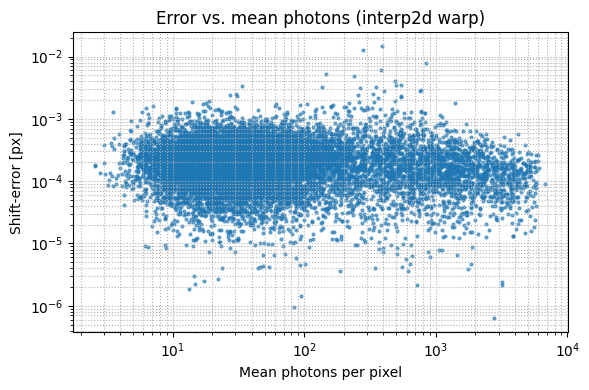

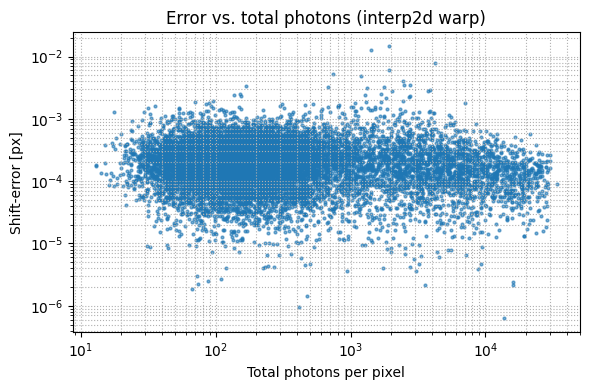

In [117]:
#!/usr/bin/env python3
"""
Like the “FIXED” reference, but warp uses interpax.interp2d
instead of scipy.ndimage.map_coordinates.
"""
import os, numpy as np, jax, jax.numpy as jnp
from jax import jacfwd, jit
from scipy.stats.qmc import Sobol
from scipy.ndimage import map_coordinates   # still here for later tests
from tqdm import trange
import dLuxToliman
from interpax import interp2d               # ← new import
import matplotlib.pyplot as plt

# ───────────── USER KNOBS ─────────────
read_var   = 3.27**2         # read-noise variance (e⁻²)
lam        = 1e-4            # Tikhonov regulariser
eps        = 1e-12
# ──────────────────────────────────────

os.environ["JAX_ENABLE_X64"] = "True"
jax.config.update("jax_enable_x64", True)

# ---------- warp via interpax.interp2d ----------
def warp(img, field_sup, order="cubic"):
    """
    img        : (Hsup, Wsup) array
    field_sup  : (Hsup, Wsup, 2) displacement [dx,dy] in supersampled px
    returns    : warped image, same shape
    """
    Hsup, Wsup = img.shape
    ys = jnp.arange(Hsup)
    xs = jnp.arange(Wsup)
    coords_y = (ys[:, None] - field_sup[..., 1]).ravel()
    coords_x = (xs[None, :] - field_sup[..., 0]).ravel()
    warped = interp2d(
        xq=coords_y, yq=coords_x,
        x=xs,        y=ys,
        f=img,
        method=order,
        extrap=True        # constant extrapolation, no NaNs
    )
    return warped.reshape(Hsup, Wsup)

# ---------- downsample helper ----------
def downsample(arr, q):
    h, w = arr.shape
    return arr.reshape(h//q, q, w//q, q).mean((1, 3))

# ---------- optics & 5-dither pattern ----------
opt  = dLuxToliman.TolimanOpticalSystem(wf_npixels=256,
                                        psf_npixels=128,
                                        oversample=4)
ovsp        = opt.oversample
arcsec_det  = opt.psf_pixel_scale
arcsec_sup  = arcsec_det / ovsp

dith_det  = [(0,0),(+0.2,0),(-0.2,0),(0,+0.2),(0,-0.2)]
dith_arc  = jnp.array([(dx*arcsec_det, dy*arcsec_det) for dx,dy in dith_det])
K         = len(dith_arc)   # 5

# ---------- JIT PSF & gradient ----------
def psf_field(t):
    dx, dy = t
    src = dLuxToliman.sources.AlphaCen(
        n_wavels=5, separation=10., position_angle=90.,
        x_position=dx, y_position=dy
    )
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model().astype(jnp.float64)

psf_jit  = jit(psf_field)
grad_jit = jit(jacfwd(psf_field, holomorphic=False))

# ---------- ground-truth shifts (no QE) ----------
rng         = np.random.default_rng(0)
shift_det   = rng.uniform(-0.01, 0.01, (128,128,2))
field_sup_base = np.kron(shift_det*ovsp, np.ones((ovsp,ovsp,1)))

# ---------- reference χ² ----------
psf0_sup  = np.asarray(psf_jit(jnp.array([0.,0.])))
dist0_sup = warp(psf0_sup, field_sup_base)
chi2_dist0 = np.sum((psf0_sup - dist0_sup)**2)

# ---------- generate PSFs & grads ----------
ideal   = []
gx_list = []
gy_list = []
for dx_k, dy_k in dith_arc:
    I_sup = np.asarray(psf_jit(jnp.array([dx_k, dy_k])))
    G_sup = np.asarray(grad_jit(jnp.array([dx_k, dy_k])))
    ideal.append(I_sup)
    gx_list.append(G_sup[...,0])
    gy_list.append(G_sup[...,1])
ideal = np.stack(ideal)
gx    = np.stack(gx_list)
gy    = np.stack(gy_list)

# ---------- measured frames (warp only) ----------
dist = np.stack([warp(im, field_sup_base) for im in ideal])
meas = dist                                  # no QE, no noise
R    = meas - ideal

# ---------- per-pixel 3-parameter LS ----------
Hsup, Wsup = ideal.shape[1:]
dx_sup = np.zeros((Hsup, Wsup))
dy_sup = np.zeros_like(dx_sup)
dr_sup = np.zeros_like(dx_sup)

for i in trange(Hsup, desc="Rows"):
    for j in range(Wsup):
        G = np.stack([-gx[:,i,j], -gy[:,i,j], ideal[:,i,j]], axis=1)   # (K,3)
        r = R[:,i,j]
        A = G.T @ G + lam*np.eye(3)
        b = G.T @ r
        dx_sup[i,j], dy_sup[i,j], dr_sup[i,j] = np.linalg.solve(A, b)

# ---------- diagnostics ----------
est_sup = np.stack([-dx_sup/arcsec_sup, -dy_sup/arcsec_sup], axis=-1)
undist   = warp(dist[0], -est_sup)
chi2_corr = np.sum((ideal[0] - undist)**2)

print("\nχ² distorted :", f"{chi2_dist0:,.0f}")
print("χ² corrected :", f"{chi2_corr:,.0f}")

field_det = (field_sup_base
               .reshape(128, ovsp, 128, ovsp, 2)
               .mean((1,3))) / ovsp

est_shift_det = np.stack([
    -(dx_sup.reshape(128,ovsp,128,ovsp).mean((1,3))) / arcsec_det,
    -(dy_sup.reshape(128,ovsp,128,ovsp).mean((1,3))) / arcsec_det
], axis=-1)

err_x = est_shift_det[...,0] - shift_det[...,0]
err_y = est_shift_det[...,1] - shift_det[...,1]
err_mag = np.sqrt(err_x**2 + err_y**2)

# ---------- photon counts ----------
sum_phot = np.zeros((128,128))
for k in range(K):
    I_det_ph = downsample(meas[k], ovsp)
    sum_phot += I_det_ph
mean_phot  = sum_phot / K
total_phot = sum_phot
mask = total_phot > 0

# ---------- plots ----------
plt.figure(figsize=(6,4))
plt.scatter(mean_phot[mask], err_mag[mask], s=4, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Mean photons per pixel")
plt.ylabel("Shift-error [px]")
plt.title("Error vs. mean photons (interp2d warp)")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(total_phot[mask], err_mag[mask], s=4, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Total photons per pixel")
plt.ylabel("Shift-error [px]")
plt.title("Error vs. total photons (interp2d warp)")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()


Rows: 100%|██████████| 512/512 [00:10<00:00, 49.50it/s]



χ² distorted : 3,343,342
χ² corrected : 303,110


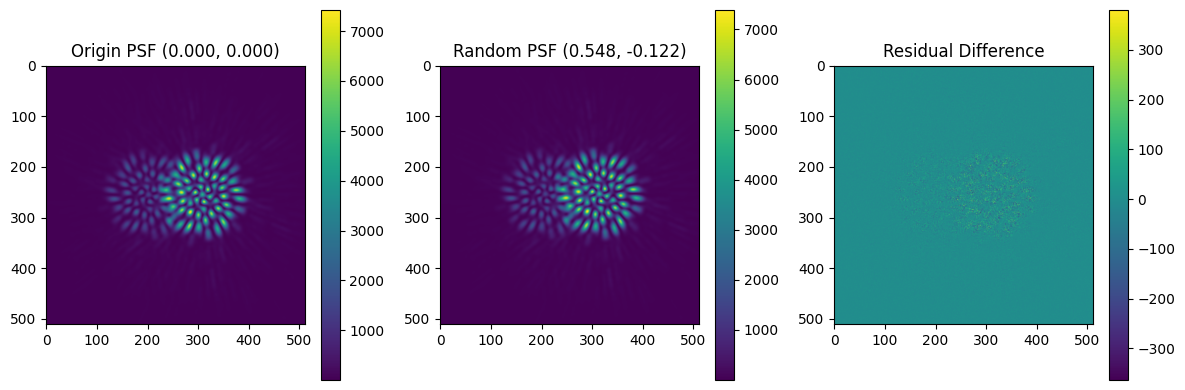

PSF difference RMS: 5.67e+02


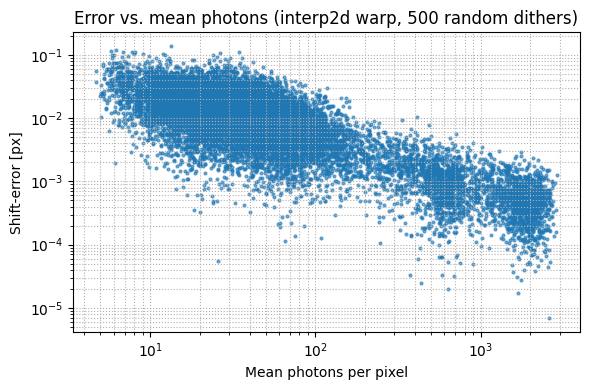

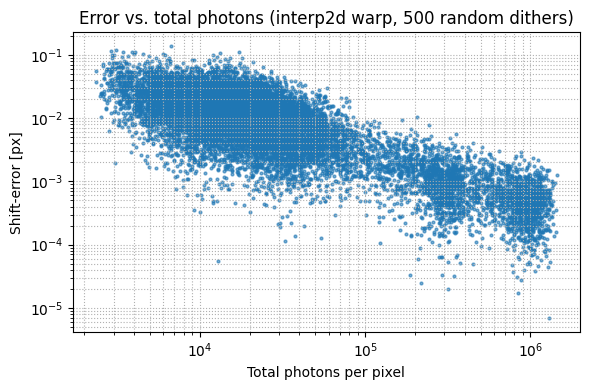

In [130]:
#!/usr/bin/env python3
"""
Like the "FIXED" reference, but warp uses interpax.interp2d
instead of scipy.ndimage.map_coordinates.
Modified to support random dithers within a specified range.
"""
import os, numpy as np, jax, jax.numpy as jnp
from jax import jacfwd, jit
from scipy.stats.qmc import Sobol
from scipy.ndimage import map_coordinates   # still here for later tests
from tqdm import trange
import dLuxToliman
from interpax import interp2d               # ← new import
import matplotlib.pyplot as plt

# ───────────── USER KNOBS ─────────────
read_var   = 3.27**2         # read-noise variance (e⁻²)
lam        = 1e-4            # Tikhonov regulariser
eps        = 1e-12

# ── DITHER PARAMETERS ──
n_dithers     = 500          # Total number of dither positions (including (0,0))
dither_range  = 1       # Maximum dither offset in arcseconds (±range)
random_seed   = 42           # Set to None for different random patterns each run
# ──────────────────────────────────────

os.environ["JAX_ENABLE_X64"] = "True"
jax.config.update("jax_enable_x64", True)

# ---------- warp via interpax.interp2d ----------
def warp(img, field_sup, order="cubic"):
    """
    img        : (Hsup, Wsup) array
    field_sup  : (Hsup, Wsup, 2) displacement [dx,dy] in supersampled px
    returns    : warped image, same shape
    """
    Hsup, Wsup = img.shape
    ys = jnp.arange(Hsup)
    xs = jnp.arange(Wsup)
    coords_y = (ys[:, None] - field_sup[..., 1]).ravel()
    coords_x = (xs[None, :] - field_sup[..., 0]).ravel()
    warped = interp2d(
        xq=coords_y, yq=coords_x,
        x=xs,        y=ys,
        f=img,
        method=order,
        extrap=True        # constant extrapolation, no NaNs
    )
    return warped.reshape(Hsup, Wsup)

# ---------- downsample helper ----------
def downsample(arr, q):
    h, w = arr.shape
    return arr.reshape(h//q, q, w//q, q).mean((1, 3))

# ---------- optics & dither pattern ----------
opt  = dLuxToliman.TolimanOpticalSystem(wf_npixels=256,
                                        psf_npixels=128,
                                        oversample=4)
ovsp        = opt.oversample
arcsec_det  = opt.psf_pixel_scale
arcsec_sup  = arcsec_det / ovsp

# Generate random dither pattern
def generate_dither_pattern(n_dithers, dither_range, seed=None):
    """
    Generate random dither positions with (0,0) always included.
    
    Parameters:
    -----------
    n_dithers : int
        Total number of dither positions (including (0,0))
    dither_range : float
        Maximum offset in arcseconds (uniform distribution ±range)
    seed : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    dith_arc : array
        Array of (dx, dy) dither positions in arcseconds
    """
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()
    
    # Always include (0,0) as first dither position
    dith_list = [(0.0, 0.0)]
    
    # Generate n_dithers-1 additional random positions
    for _ in range(n_dithers - 1):
        dx = rng.uniform(-dither_range, dither_range)
        dy = rng.uniform(-dither_range, dither_range)
        dith_list.append((dx, dy))
    
    return np.array(dith_list)

# Generate the dither pattern
dith_arc = generate_dither_pattern(n_dithers, dither_range, random_seed)
K = len(dith_arc)

# #print(f"Generated {K} dither positions:")
# for i, (dx, dy) in enumerate(dith_arc):
#     print(f"  Dither {i}: ({dx:+.3f}, {dy:+.3f}) arcsec")

# ---------- JIT PSF & gradient ----------
def psf_field(t):
    dx, dy = t
    src = dLuxToliman.sources.AlphaCen(
        n_wavels=5, separation=10., position_angle=90.,
        x_position=dx, y_position=dy
    )
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model().astype(jnp.float64)

psf_jit  = jit(psf_field)
grad_jit = jit(jacfwd(psf_field, holomorphic=False))

# ---------- ground-truth shifts (no QE) ----------
rng         = np.random.default_rng(0)
shift_det   = rng.uniform(-0.01, 0.01, (128,128,2))
field_sup_base = np.kron(shift_det*ovsp, np.ones((ovsp,ovsp,1)))

# ---------- reference χ² ----------
psf0_sup  = np.asarray(psf_jit(jnp.array([0.,0.])))
dist0_sup = warp(psf0_sup, field_sup_base)
chi2_dist0 = np.sum((psf0_sup - dist0_sup)**2)

# ---------- generate PSFs & grads ----------
ideal   = []
gx_list = []
gy_list = []
for dx_k, dy_k in dith_arc:
    I_sup = np.asarray(psf_jit(jnp.array([dx_k, dy_k])))
    G_sup = np.asarray(grad_jit(jnp.array([dx_k, dy_k])))
    ideal.append(I_sup)
    gx_list.append(G_sup[...,0])
    gy_list.append(G_sup[...,1])
ideal = np.stack(ideal)
gx    = np.stack(gx_list)
gy    = np.stack(gy_list)

# ---------- measured frames (warp + noise) ----------
dist = np.stack([warp(im, field_sup_base) for im in ideal])
var_stack = dist + read_var
# Add independent noise to each dither
meas = []
for k in range(K):
    # Total variance: photon noise (= signal) + read noise
    var_sup = dist[k] + read_var
    # Add Gaussian noise with this variance
    meas_sup = dist[k] + rng.normal(scale=np.sqrt(var_sup), size=dist[k].shape)
    meas.append(meas_sup)

meas = np.stack(meas)
R    = meas - ideal

# ---------- per-pixel 3-parameter LS ----------
Hsup, Wsup = ideal.shape[1:]
dx_sup = np.zeros((Hsup, Wsup))
dy_sup = np.zeros_like(dx_sup)
dr_sup = np.zeros_like(dx_sup)

for i in trange(Hsup, desc="Rows"):
    for j in range(Wsup):
        G = np.stack([-gx[:,i,j], -gy[:,i,j], ideal[:,i,j]], axis=1)   # (K,3)
        r = R[:,i,j]

        # --- NEW weighted LS ---
        w   = 1.0 / var_stack[:, i, j]          # inverse variance weights, shape (K,)
        Gw  = G * np.sqrt(w[:, None])           # weight each row
        rw  = r * np.sqrt(w)                    # weight the residual

        A = Gw.T @ Gw + lam*np.eye(3)           # (3×3)
        b = Gw.T @ rw                           # (3,)
        dx_sup[i,j], dy_sup[i,j], dr_sup[i,j] = np.linalg.solve(A, b)

# ---------- diagnostics ----------
est_sup = np.stack([-dx_sup/arcsec_sup, -dy_sup/arcsec_sup], axis=-1)
undist   = warp(dist[0], -est_sup)
chi2_corr = np.sum((ideal[0] - undist)**2)

print(f"\nχ² distorted : {chi2_dist0:,.0f}")
print(f"χ² corrected : {chi2_corr:,.0f}")

field_det = (field_sup_base
               .reshape(128, ovsp, 128, ovsp, 2)
               .mean((1,3))) / ovsp

est_shift_det = np.stack([
    -(dx_sup.reshape(128,ovsp,128,ovsp).mean((1,3))) / arcsec_det,
    -(dy_sup.reshape(128,ovsp,128,ovsp).mean((1,3))) / arcsec_det
], axis=-1)

err_x = est_shift_det[...,0] - shift_det[...,0]
err_y = est_shift_det[...,1] - shift_det[...,1]
err_mag = np.sqrt(err_x**2 + err_y**2)

# ---------- photon counts ----------
sum_phot = np.zeros((128,128))
for k in range(K):
    I_det_ph = downsample(meas[k], ovsp)
    sum_phot += I_det_ph
mean_phot  = sum_phot / K
total_phot = sum_phot
mask = total_phot > 0

# ---------- dither verification plots ----------
# Compare origin dither (0) vs first random dither (1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(ideal[0])
plt.title(f'Origin PSF ({dith_arc[0][0]:.3f}, {dith_arc[0][1]:.3f})')
plt.colorbar()

plt.subplot(1,3,2) 
plt.imshow(ideal[1])
plt.title(f'Random PSF ({dith_arc[1][0]:.3f}, {dith_arc[1][1]:.3f})')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(R[0] - R[1])
plt.title('Residual Difference')
plt.colorbar()
plt.tight_layout()
plt.show()

print(f"PSF difference RMS: {np.sqrt(np.mean((ideal[0] - ideal[1])**2)):.2e}")

# ---------- original plots ----------
plt.figure(figsize=(6,4))
plt.scatter(mean_phot[mask], err_mag[mask], s=4, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Mean photons per pixel")
plt.ylabel("Shift-error [px]")
plt.title(f"Error vs. mean photons (interp2d warp, {K} random dithers)")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(total_phot[mask], err_mag[mask], s=4, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Total photons per pixel")
plt.ylabel("Shift-error [px]")
plt.title(f"Error vs. total photons (interp2d warp, {K} random dithers)")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

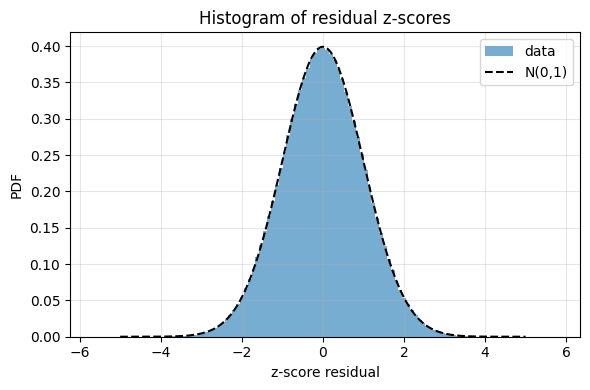

z-score variance = 1.009  (>1 ⇒ under-fit, ≈1 ⇒ well-fit, <1 ⇒ over-fit)


In [126]:
# ---------- z-score residuals histogram ---------------------------------
# photon-noise ≈ Poisson ⇒ var ≈ signal; we already have `dist` = noiseless signal
var_sup = dist + read_var                       
z_scores = (meas - ideal) / np.sqrt(var_sup)      
z_flat = z_scores.ravel()
plt.figure(figsize=(6,4))
plt.hist(z_flat, bins=120, density=True, alpha=0.6, label='data')

# overlay N(0,1)
xs = np.linspace(-5,5,300)
plt.plot(xs, 1/np.sqrt(2*np.pi)*np.exp(-0.5*xs**2), 'k--', lw=1.5, label='N(0,1)')

plt.xlabel('z-score residual'); plt.ylabel('PDF')
plt.title('Histogram of residual z-scores')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
z_var     = np.var(z_flat, ddof=1)               # sample variance (ddof=1 = unbiased)
print(f"z-score variance = {z_var:.3f}  "
      "(>1 ⇒ under-fit, ≈1 ⇒ well-fit, <1 ⇒ over-fit)")
# ------------------------------------------------------------------------


Rows: 100%|██████████| 512/512 [00:57<00:00,  8.91it/s]



χ² distorted : 3,343,342
χ² corrected : 152,103
Shift RMS error : 1.26e-02 px
QE RMS error    : 0.21%


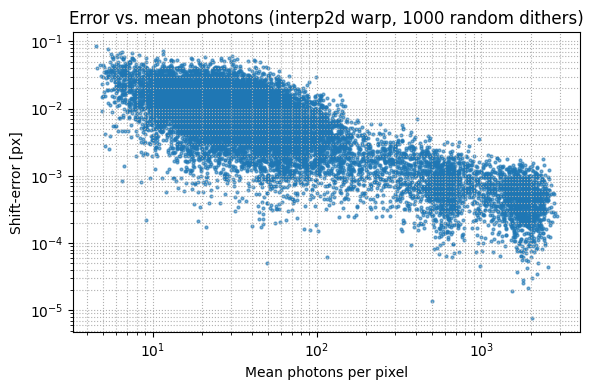

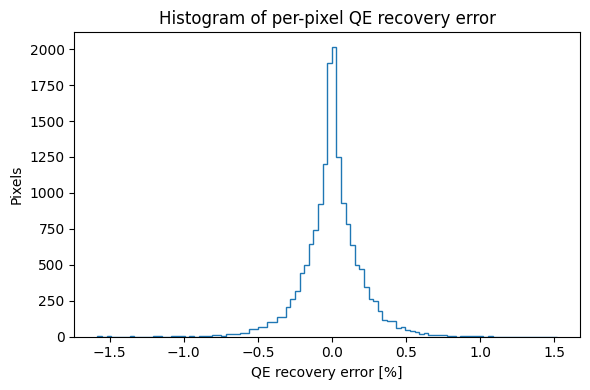

In [145]:
#!/usr/bin/env python3
"""
Pixel-shift + pixel-QE simulation & recovery.
Same script you supplied, **only change is the inclusion of a per-pixel QE map**.
Warp uses interpax.interp2d; jitter uses random dithers.
"""
# ─────────────────── imports ──────────────────────────────────────────
import os, numpy as np, jax, jax.numpy as jnp
from jax import jacfwd, jit
from scipy.ndimage import map_coordinates          # still handy for tests
from tqdm import trange
import dLuxToliman
from interpax import interp2d
import matplotlib.pyplot as plt
# ─────────────────── user knobs ──────────────────────────────────────
read_var   = 3.27**2        # read-noise variance (e⁻²)
lam        = 1e-4           # Tikhonov regulariser
eps        = 1e-12
n_dithers  = 1000            # dither positions (incl. (0,0))
dither_range = 1            # ± arcsec
random_seed  = 42
# ─────────────────── JAX 64-bit ─────────────────────────────────────
os.environ["JAX_ENABLE_X64"] = "True"
jax.config.update("jax_enable_x64", True)

# ---------- warp helper (interpax) ----------
def warp(img, field_sup, order="cubic"):
    Hsup, Wsup = img.shape
    ys, xs = jnp.arange(Hsup), jnp.arange(Wsup)
    coords_y = (ys[:, None] - field_sup[..., 1]).ravel()
    coords_x = (xs[None, :] - field_sup[..., 0]).ravel()
    warped   = interp2d(coords_y, coords_x, xs, ys, img,
                        method=order, extrap=True)
    return warped.reshape(Hsup, Wsup)

# ---------- down-sampler ----------
def downsample(arr, q):
    h, w = arr.shape
    return arr.reshape(h//q, q, w//q, q).mean((1, 3))

# ---------- optics ----------
opt  = dLuxToliman.TolimanOpticalSystem(wf_npixels=256,
                                        psf_npixels=128,
                                        oversample=4)
ovsp        = opt.oversample
arcsec_det  = opt.psf_pixel_scale
arcsec_sup  = arcsec_det / ovsp

# ---------- random dither pattern ----------
def generate_dither_pattern(K, rng_arcsec, seed=None):
    rng = np.random.default_rng(seed)
    dith = [(0.0, 0.0)]
    for _ in range(K-1):
        dx = rng.uniform(-rng_arcsec, rng_arcsec)
        dy = rng.uniform(-rng_arcsec, rng_arcsec)
        dith.append((dx, dy))
    return np.array(dith)

dith_arc = generate_dither_pattern(n_dithers, dither_range, random_seed)
K        = len(dith_arc)

# ---------- PSF & gradients (JIT) ----------
def psf_xy(t):
    dx, dy = t
    src = dLuxToliman.sources.AlphaCen(
        n_wavels=5, separation=10., position_angle=90.,
        x_position=dx, y_position=dy
    )
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model().astype(jnp.float64)

psf_jit  = jit(psf_xy)
grad_jit = jit(jacfwd(psf_xy, holomorphic=False))

# ---------- ground truth: shifts **and QE map** ----------
rng             = np.random.default_rng(0)
shift_det       = rng.uniform(-0.01, 0.01, (128, 128, 2))          # Δx,Δy [px]
delta_rho_det   = -rng.normal(0.025, 0.025, (128, 128))                # ±2 % QE
rho_det         = 1.0 + delta_rho_det                              # true gain

field_sup_base  = np.kron(shift_det * ovsp, np.ones((ovsp, ovsp, 1)))
rho_sup2d_base  = np.kron(rho_det,          np.ones((ovsp, ovsp)))

# ---------- reference χ² ----------
psf0_sup   = np.asarray(psf_jit(jnp.array([0., 0.])))
dist0_sup  = warp(psf0_sup, field_sup_base)
chi2_dist0 = np.sum((psf0_sup - dist0_sup)**2)

# ---------- generate ideal PSFs & gradients ----------
ideal, gx, gy = [], [], []
for dx_k, dy_k in dith_arc:
    I_sup = np.asarray(psf_jit(jnp.array([dx_k, dy_k])))
    G_sup = np.asarray(grad_jit(jnp.array([dx_k, dy_k])))
    ideal.append(I_sup)
    gx.append(G_sup[..., 0])
    gy.append(G_sup[..., 1])
ideal = np.stack(ideal)                # (K,Hsup,Wsup)
gx    = np.stack(gx)
gy    = np.stack(gy)

# ---------- forward model: warp + QE  ----------
dist_sup_stack = np.stack([warp(im, field_sup_base) for im in ideal])
qe_stack       = dist_sup_stack * rho_sup2d_base     # apply gain

# noise variance & weighted LS weights
var_stack = qe_stack + read_var                      # shot + read noise

# ---------- add noise ----------
meas = []
for k in range(K):
    var_sup  = var_stack[k]
    meas_sup = qe_stack[k] + rng.normal(scale=np.sqrt(var_sup),
                                        size=var_sup.shape)
    meas.append(meas_sup)
meas = np.stack(meas)                                # (K,Hsup,Wsup)

# ---------- residuals ----------
R = meas - ideal

# ---------- per-pixel weighted LS (Δx,Δy,Δρ) ----------
Hsup, Wsup = ideal.shape[1:]
dx_sup = np.zeros((Hsup, Wsup))
dy_sup = np.zeros_like(dx_sup)
dr_sup = np.zeros_like(dx_sup)

for i in trange(Hsup, desc="Rows"):
    for j in range(Wsup):
        G = np.stack([-gx[:, i, j], -gy[:, i, j], ideal[:, i, j]], axis=1)  # (K,3)
        r = R[:, i, j]
        w = 1.0 / np.maximum(var_stack[:, i, j], eps)
        sqrtw = np.sqrt(w)
        Gw = G * sqrtw[:, None]
        rw = r * sqrtw
        A = Gw.T @ Gw + lam * np.eye(3)
        b = Gw.T @ rw
        dx_sup[i, j], dy_sup[i, j], dr_sup[i, j] = np.linalg.solve(A, b)

# ---------- diagnostics ----------
est_sup = np.stack([-dx_sup/arcsec_sup, -dy_sup/arcsec_sup], axis=-1)
undist   = warp(dist_sup_stack[0], -est_sup)
chi2_corr = np.sum((ideal[0] - undist)**2)

print(f"\nχ² distorted : {chi2_dist0:,.0f}")
print(f"χ² corrected : {chi2_corr:,.0f}")

# detector-scale shift error
field_det = (field_sup_base
             .reshape(128, ovsp, 128, ovsp, 2)
             .mean((1, 3))) / ovsp

est_shift_det = np.stack([
    -(dx_sup.reshape(128, ovsp, 128, ovsp).mean((1, 3))) / arcsec_det,
    -(dy_sup.reshape(128, ovsp, 128, ovsp).mean((1, 3))) / arcsec_det
], axis=-1)

err_x   = est_shift_det[..., 0] - shift_det[..., 0]
err_y   = est_shift_det[..., 1] - shift_det[..., 1]
err_mag = np.sqrt(err_x**2 + err_y**2)

# QE recovery error
dr_det      = dr_sup.reshape(128, ovsp, 128, ovsp).mean((1, 3))
rho_est_det = 1.0 + dr_det
qe_err_rms  = np.std(rho_est_det - rho_det)

print(f"Shift RMS error : {np.sqrt(np.mean(err_mag**2)):.2e} px")
print(f"QE RMS error    : {qe_err_rms:.2%}")

# ---------- photon counts ----------
sum_phot = np.zeros((128, 128))
for k in range(K):
    I_det_ph = downsample(meas[k], ovsp)
    sum_phot += I_det_ph
mean_phot  = sum_phot / K
total_phot = sum_phot
mask = total_phot > 0

# ---------- plots ----------
plt.figure(figsize=(6,4))
plt.scatter(mean_phot[mask], err_mag[mask], s=4, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Mean photons per pixel")
plt.ylabel("Shift-error [px]")
plt.title(f"Error vs. mean photons (interp2d warp, {K} random dithers)")
plt.grid(True, which="both", ls=":")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist((rho_est_det - rho_det).ravel()*100, bins=100, histtype='step')
plt.xlabel("QE recovery error [%]"); plt.ylabel("Pixels")
plt.title("Histogram of per-pixel QE recovery error")
plt.tight_layout(); plt.show()


K=1000 LS: 100%|██████████| 512/512 [00:46<00:00, 11.06it/s]


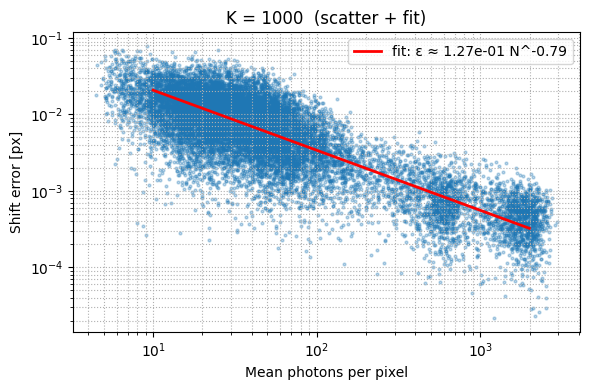

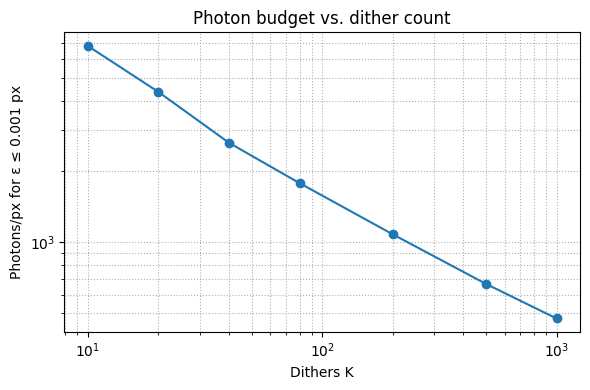


Target ε = 0.001 px

   K   |    A (prefactor)   |   b (slope)   |  N_phot req
-------+--------------------+---------------+-------------
   10 |    1.964e+00     |  -0.859      |   6.82e+03
   20 |    1.214e+00     |  -0.848      |   4.35e+03
   40 |    8.519e-01     |  -0.856      |   2.65e+03
   80 |    5.635e-01     |  -0.846      |   1.78e+03
  200 |    3.374e-01     |  -0.833      |   1.08e+03
  500 |    1.952e-01     |  -0.811      |        666
 1000 |    1.269e-01     |  -0.786      |        475


In [2]:
#!/usr/bin/env python3
"""
======================================================================
  Shift-precision vs Photon Budget
  --------------------------------
  • Builds ONE master dither list (length = max_K) so every shorter
    run re-uses the exact first K positions.
  • Runs the pixel-shift + QE simulation for each K in dither_list.
  • Fits  log10(err) = a + b log10(Nphot)  over the photon-noise
    regime (20 – 500 photons px⁻¹).   **np.polyfit order fixed!**
  • Converts that fit into    N_phot(target_eps)  for each K.
  • Shows:
        (1) scatter + fitted power-law for the largest-K run
        (2) photons-per-pixel required vs dither count (plateau plot)
======================================================================
"""
# ── imports ──────────────────────────────────────────────────────────
import os, numpy as np, jax, jax.numpy as jnp, matplotlib.pyplot as plt
from jax import jacfwd, jit
from tqdm import trange
import dLuxToliman
from interpax import interp2d

# ── JAX 64-bit ───────────────────────────────────────────────────────
os.environ["JAX_ENABLE_X64"] = "True"
jax.config.update("jax_enable_x64", True)

# ── user knobs ───────────────────────────────────────────────────────
dither_list   = [10, 20, 40, 80, 200, 500, 1000]
target_eps    = 0.001                         # desired shift accuracy [px]
read_var      = 3.27**2                       # read-noise variance
lam           = 1e-4                          # LS regulariser
rng_seed_sim  = 0                             # dithers + noise
rng_seed_truth= 1                             # ground-truth maps
# --------------------------------------------------------------------

# ── helper functions ────────────────────────────────────────────────
def warp(img, field_sup, order="cubic"):
    Hsup, Wsup = img.shape
    ys, xs = jnp.arange(Hsup), jnp.arange(Wsup)
    coords_y = (ys[:, None] - field_sup[..., 1]).ravel()
    coords_x = (xs[None, :] - field_sup[..., 0]).ravel()
    return interp2d(coords_y, coords_x, xs, ys, img,
                    method=order, extrap=True).reshape(Hsup, Wsup)

def downsample(arr, q):                       # 512→128
    h, w = arr.shape
    return arr.reshape(h//q, q, w//q, q).mean((1, 3))

# ── optics (built once) ─────────────────────────────────────────────
opt  = dLuxToliman.TolimanOpticalSystem(wf_npixels=256,
                                        psf_npixels=128,
                                        oversample=4)
ovsp        = opt.oversample
arcsec_det  = opt.psf_pixel_scale
arcsec_sup  = arcsec_det / ovsp

@jit
def psf_xy(t):
    dx, dy = t
    src = dLuxToliman.sources.AlphaCen(
        n_wavels=5, separation=10., position_angle=90.,
        x_position=dx, y_position=dy)
    return dLuxToliman.telescopes.Toliman(opt, src).model().astype(jnp.float64)

psf_jit  = psf_xy
grad_jit = jit(jacfwd(psf_xy, holomorphic=False))

# ── deterministic master dither list ────────────────────────────────
max_K        = max(dither_list)
rng_dith     = np.random.default_rng(rng_seed_sim)
dither_master= np.vstack([[0.,0.],
                          rng_dith.uniform(-1,1,size=(max_K-1,2))])

# ── storage for outputs ─────────────────────────────────────────────
fit_params  = {}           # {K: (a,b)}
required_N  = []           # photons needed for target_eps
scatter_dat = {}           # store data for largest-K plot

# ===================================================================
#  MAIN LOOP OVER dither counts
# ===================================================================
for K in dither_list:
    dith = dither_master[:K]

    # --- ground-truth maps (same every K) ---------------------------
    rng_truth = np.random.default_rng(rng_seed_truth)
    shift_det = rng_truth.uniform(-0.01,0.01,(128,128,2))
    loss      = np.clip(rng_truth.normal(0.025,0.0125,(128,128)),0.0,0.05)
    rho_det   = 1.0 - loss
    field_sup = np.kron(shift_det*ovsp, np.ones((ovsp,ovsp,1)))
    rho_sup   = np.kron(rho_det,        np.ones((ovsp,ovsp)))

    # --- PSFs & gradients ------------------------------------------
    ideal_sup, gx_sup, gy_sup = [], [], []
    for k in trange(K, desc=f"K={K} PSF+grad"):
        I_sup = np.asarray(psf_jit(jnp.array(dith[k])))
        G_sup = np.asarray(grad_jit(jnp.array(dith[k])))
        ideal_sup.append(I_sup)
        gx_sup.append(G_sup[...,0]); gy_sup.append(G_sup[...,1])
    ideal_sup = np.stack(ideal_sup); gx_sup = np.stack(gx_sup); gy_sup = np.stack(gy_sup)

    # --- forward model + noise -------------------------------------
    dist_sup = np.stack([warp(im, field_sup) for im in ideal_sup])
    qe_sup   = dist_sup * rho_sup
    var_sup  = qe_sup + read_var
    rng_noise= np.random.default_rng(rng_seed_sim+K)
    meas_sup = qe_sup + rng_noise.normal(scale=np.sqrt(var_sup), size=var_sup.shape)
    R_sup    = meas_sup - ideal_sup

    # --- weighted LS (progress bar) --------------------------------
    Hsup,Wsup = ideal_sup.shape[1:]
    dx_sup = np.zeros((Hsup,Wsup)); dy_sup = np.zeros_like(dx_sup)
    for i in trange(Hsup, desc=f"K={K} LS"):
        for j in range(Wsup):
            G = np.stack([-gx_sup[:,i,j], -gy_sup[:,i,j], ideal_sup[:,i,j]], axis=1)
            r = R_sup[:,i,j]
            w = 1.0 / np.maximum(var_sup[:,i,j], 1e-12)
            sw= np.sqrt(w)
            A = (G*sw[:,None]).T @ (G*sw[:,None]) + lam*np.eye(3)
            b = (G*sw[:,None]).T @ (r*sw)
            dx_sup[i,j], dy_sup[i,j], _ = np.linalg.solve(A,b)

    # --- detector-scale errors -------------------------------------
    dx_det = (-dx_sup.reshape(128,ovsp,128,ovsp).mean((1,3)))/arcsec_det
    dy_det = (-dy_sup.reshape(128,ovsp,128,ovsp).mean((1,3)))/arcsec_det
    err_mag= np.sqrt((dx_det-shift_det[...,0])**2 +
                     (dy_det-shift_det[...,1])**2)

    # --- photon statistics -----------------------------------------
    sum_phot = np.zeros((128,128))
    for k in range(K):
        sum_phot += downsample(meas_sup[k], ovsp)
    mean_phot = sum_phot / K

    # --- log–log fit (photon-noise regime) -------------------------
    #mask = (mean_phot > 20) & (mean_phot < 500)
    mask = (mean_phot > 20)
    x = np.log10(mean_phot[mask].ravel())
    y = np.log10(err_mag  [mask].ravel())
    slope, intercept = np.polyfit(x, y, 1)    # slope=b, intercept=a
    b = slope;  a = intercept
    fit_params[K] = (a,b)

    if b < 0:                                 # meaningful fit
        Nreq = (target_eps / 10**a)**(1/b)
    else:                                     # slope ≥ 0 → ignore
        Nreq = np.nan
    required_N.append(Nreq)

    if K == max_K:
        scatter_dat.update(dict(mean_phot=mean_phot,
                                err_mag=err_mag, a=a, b=b))

# ===================================================================
#  PLOTS
# ===================================================================
# -- scatter + fit for largest K ------------------------------------
mp   = scatter_dat['mean_phot'].ravel()
eps  = scatter_dat['err_mag'].ravel()
a,b  = scatter_dat['a'], scatter_dat['b']

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(mp, eps, s=4, alpha=0.3)
N_line = np.logspace(1, 3.3, 200)
ax.plot(N_line, 10**a * N_line**b, 'r-', lw=2,
        label=f'fit: ε ≈ {10**a:.2e} N^{b:.2f}')
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('Mean photons per pixel'); ax.set_ylabel('Shift error [px]')
ax.set_title(f'K = {max_K}  (scatter + fit)')
ax.grid(True, which='both', ls=':')
ax.legend(); plt.tight_layout()

# -- photon budget vs dither count ----------------------------------
plt.figure(figsize=(6,4))
plt.plot(dither_list, required_N, 'o-')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Dithers K'); plt.ylabel(f'Photons/px for ε ≤ {target_eps} px')
plt.title('Photon budget vs. dither count')
plt.grid(True, which='both', ls=':'); plt.tight_layout(); plt.show()

# ===================================================================
#  CONSOLE SUMMARY
# ===================================================================
print(f"\nTarget ε = {target_eps} px\n")
print("   K   |    A (prefactor)   |   b (slope)   |  N_phot req")
print("-------+--------------------+---------------+-------------")
for K,N in zip(dither_list, required_N):
    a,b = fit_params[K]
    print(f"{K:5d} | {10**a:12.3e}     | {b:7.3f}      | {N:>10.3g}")



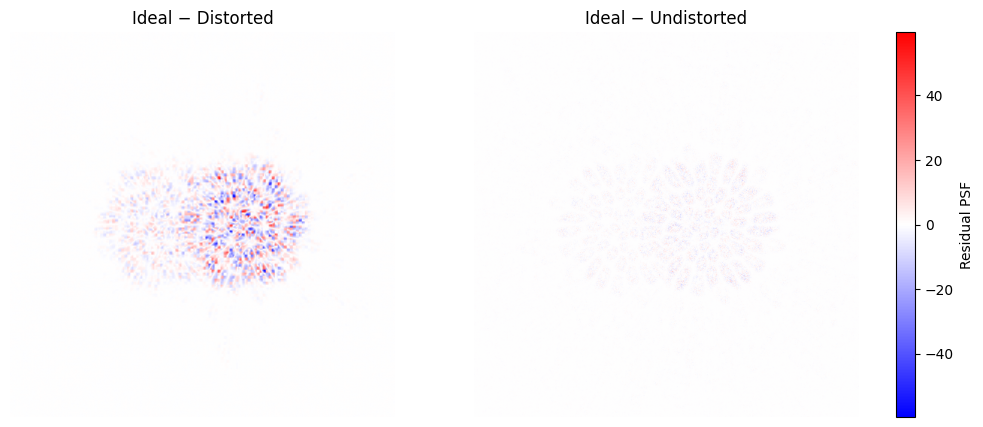

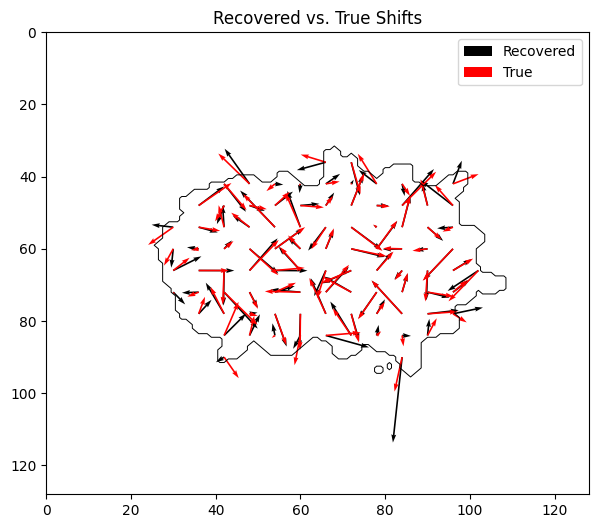

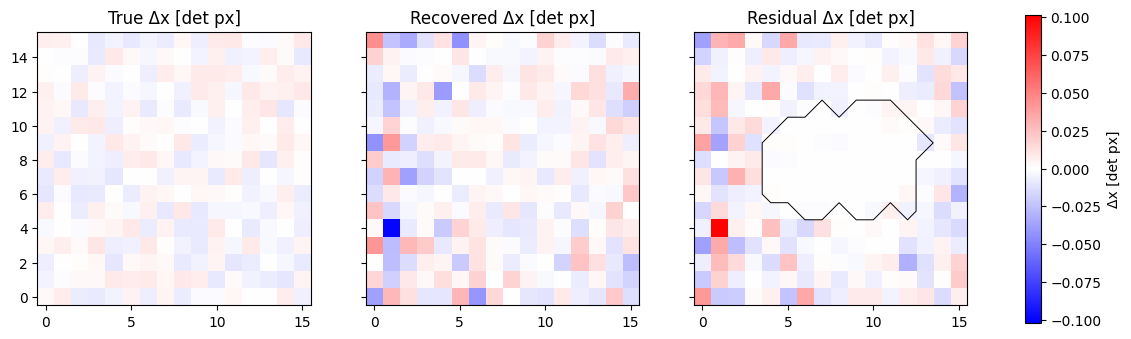

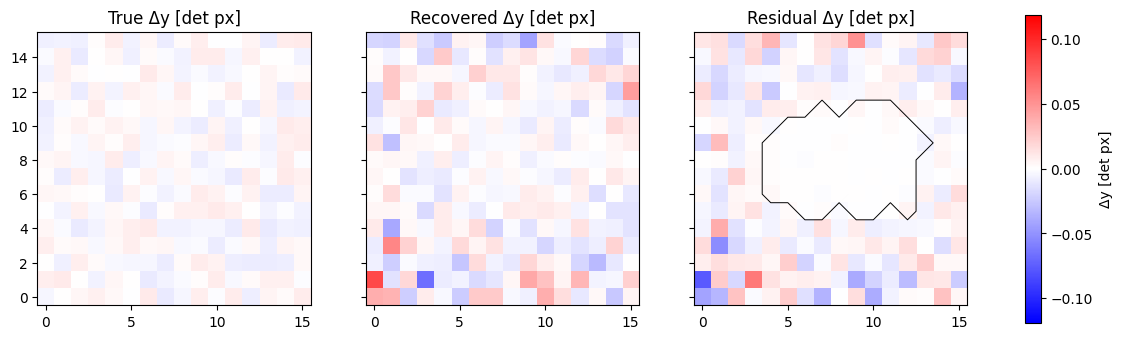

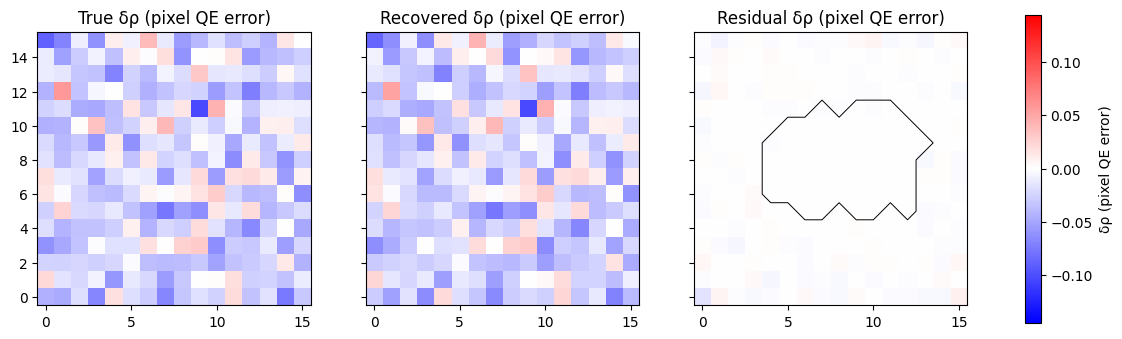

‖Ideal − Distorted‖₂  = 1.83e+03
‖Ideal − Undistorted‖₂= 3.90e+02


In [146]:
# ---------------------------------------------------------------
#  PLOTTING SUITE  —  no LS/HS split (only one solution set)
# ---------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm

# ─── 0)  MASKS + GLOBAL SETTINGS ────────────────────────────────
PLOT_FRAC_QUIV = 0.04    # keep quiver arrows inside brightest 3 %
PLOT_FRAC_HM   = 0       # 0 → show entire heat-map
CONTOUR_FRAC   = 0.04    # outline PSF footprint at 3 % peak
SHOW_CONTOUR   = True
QUIVER_STEP    = 6       # sample every 6 px
HEAT_SUBSAMPLE = 8       # stride in heat-maps
QUIVER_SCALE   = 0.15    # arrow scale

# Detector-scale stack of ideal PSFs (128×128)
ideal_det = np.stack([downsample(im, ovsp) for im in ideal])   # (K,128,128)
mean_psf  = ideal_det.mean(axis=0)
peak      = mean_psf.max()

mask_plot_QUIV = (mean_psf > PLOT_FRAC_QUIV * peak) if PLOT_FRAC_QUIV else np.ones_like(mean_psf, bool)
mask_plot_HM   = (mean_psf > PLOT_FRAC_HM   * peak) if PLOT_FRAC_HM   else np.ones_like(mean_psf, bool)
mask_contour   = (mean_psf > CONTOUR_FRAC * peak) if CONTOUR_FRAC else np.ones_like(mean_psf, bool)

def add_outline(ax, mask, full_shape):
    """Draw rectangle or contour around PSF footprint."""
    if not SHOW_CONTOUR: return
    if mask.all():
        H, W = full_shape
        ax.add_patch(plt.Rectangle((0, 0), W, H, fill=False, lw=0.7, ec='k'))
    else:
        ax.contour(mask, levels=[0.5], colors='k', linewidths=0.7)

# ─── 1)  PSF RESIDUAL IMAGES  (512×512) ─────────────────────────
res_dist   = psf0_sup - dist0_sup
res_undist = psf0_sup - undist

vmax_res = np.max(np.abs([res_dist, res_undist]))
norm_res = TwoSlopeNorm(vmin=-vmax_res, vcenter=0.0, vmax=+vmax_res)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
im0 = axes[0].imshow(res_dist,   origin='lower', cmap='bwr', norm=norm_res)
axes[0].set_title("Ideal − Distorted");  axes[0].axis('off')
im1 = axes[1].imshow(res_undist, origin='lower', cmap='bwr', norm=norm_res)
axes[1].set_title("Ideal − Undistorted"); axes[1].axis('off')
fig.colorbar(im1, ax=axes, fraction=0.046, pad=0.04, label="Residual PSF")
plt.show()

# ─── 2)  SHIFT-VECTOR QUIVER (128×128) ───────────────────────────
H, W = dx_det.shape
Yf, Xf = np.indices((H, W))
Xs = Xf[::QUIVER_STEP, ::QUIVER_STEP]
Ys = Yf[::QUIVER_STEP, ::QUIVER_STEP]
valid = mask_plot_QUIV[::QUIVER_STEP, ::QUIVER_STEP]

# True shifts (detector px)
Ut = shift_det[..., 0][::QUIVER_STEP, ::QUIVER_STEP][valid]
Vt = shift_det[..., 1][::QUIVER_STEP, ::QUIVER_STEP][valid]

# Recovered shifts (flip sign already done in dx_det / dy_det)
U_rec = dx_det[::QUIVER_STEP, ::QUIVER_STEP][valid]
V_rec = dy_det[::QUIVER_STEP, ::QUIVER_STEP][valid]

fig, ax = plt.subplots(figsize=(7, 6))
ax.quiver(Xs[valid], Ys[valid], U_rec, V_rec,
          color='k', scale=QUIVER_SCALE, width=0.003, label='Recovered')
ax.quiver(Xs[valid], Ys[valid], Ut, Vt,
          color='r', scale=QUIVER_SCALE, width=0.003, label='True')
add_outline(ax, mask_contour, full_shape=(H, W))
ax.set_title("Recovered vs. True Shifts"); ax.legend(loc='upper right')
ax.set_xlim(0, W); ax.set_ylim(H, 0)
plt.show()

# ─── 3)  Δx, Δy HEAT-MAPS  ────────────────────────────────────────
def plot_shift_heatmaps(true_field, rec_field, title_prefix):
    t = true_field.copy();  r = rec_field.copy()
    t[~mask_plot_HM] = np.nan;  r[~mask_plot_HM] = np.nan
    res = t - r

    vmax = np.nanmax(np.abs([t, r]))
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)

    t_sub   = t  [::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]
    r_sub   = r  [::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]
    res_sub = res[::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]
    mask_sub= mask_contour[::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    im0 = ax0.imshow(t_sub,   origin='lower', cmap='bwr', norm=norm)
    im1 = ax1.imshow(r_sub,   origin='lower', cmap='bwr', norm=norm)
    im2 = ax2.imshow(res_sub, origin='lower', cmap='bwr', norm=norm)
    add_outline(ax2, mask_sub, full_shape=res_sub.shape)
    ax0.set_title(f"True {title_prefix}")
    ax1.set_title(f"Recovered {title_prefix}")
    ax2.set_title(f"Residual {title_prefix}")
    fig.colorbar(im1, ax=[ax0, ax1, ax2], shrink=0.8, label=title_prefix)
    plt.show()

# Δx  (detector px)
plot_shift_heatmaps(shift_det[..., 0], dx_det, "Δx [det px]")
# Δy  (detector px)
plot_shift_heatmaps(shift_det[..., 1], dy_det, "Δy [det px]")

# ─── 4)  δρ (pixel-gain) HEAT-MAP  ────────────────────────────────
def plot_sensitivity_heatmaps(true_field, rec_field, title_prefix):
    t = true_field.copy();  r = rec_field.copy()
    t[~mask_plot_HM] = np.nan;  r[~mask_plot_HM] = np.nan
    res = t - r

    vmax = np.nanmax(np.abs([t, r]))
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)

    t_sub   = t  [::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]
    r_sub   = r  [::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]
    res_sub = res[::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]
    mask_sub= mask_contour[::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    im0 = ax0.imshow(t_sub,   origin='lower', cmap='bwr', norm=norm)
    im1 = ax1.imshow(r_sub,   origin='lower', cmap='bwr', norm=norm)
    im2 = ax2.imshow(res_sub, origin='lower', cmap='bwr', norm=norm)
    add_outline(ax2, mask_sub, full_shape=res_sub.shape)
    ax0.set_title(f"True {title_prefix}")
    ax1.set_title(f"Recovered {title_prefix}")
    ax2.set_title(f"Residual {title_prefix}")
    fig.colorbar(im1, ax=[ax0, ax1, ax2], shrink=0.8, label=title_prefix)
    plt.show()

true_dr = delta_rho_det               # ground-truth δρ
rec_dr  = dr_det                      # recovered δρ
plot_sensitivity_heatmaps(true_dr, rec_dr, "δρ (pixel QE error)")

# ─── 5)  L² NORMS OF RESIDUALS  ────────────────────────────────────
print(f"‖Ideal − Distorted‖₂  = {np.linalg.norm(res_dist):.2e}")
print(f"‖Ideal − Undistorted‖₂= {np.linalg.norm(res_undist):.2e}")


In [ ]:
# ── Heat-maps: RMS Δx and Δy  (clean ticks, no overlaps) ──────────────
import numpy as np
import matplotlib.pyplot as plt

include_zero      = False
side_lengths_det  = [10, 30, 50, 70, 90, 110, 128]   # detector-pixel windows

# x-axis milestones
K_use = K_plot if include_zero else K_plot[1:]
K_use = np.asarray(K_use, dtype=float)
step  = K_use[1] - K_use[0]          # 250

# % of detector area per window
area_total = H * W
area_pct   = (np.array(side_lengths_det)**2 / area_total) * 100.0

RMSx = np.zeros((len(side_lengths_det), len(K_use)))
RMSy = np.zeros_like(RMSx)

cx, cy = W//2, H//2
for i, L in enumerate(side_lengths_det):
    half = L // 2
    mask = np.zeros((H, W), bool)
    mask[cy-half:cy+half, cx-half:cx+half] = True

    for j, K in enumerate(K_use):
        err_x, err_y = err_cache[K]
        RMSx[i, j] = np.sqrt(np.mean(err_x[mask]**2))
        RMSy[i, j] = np.sqrt(np.mean(err_y[mask]**2))

# pcolormesh edges
x_edges = np.r_[K_use - step/2, K_use[-1] + step/2]
y_edges = np.r_[0, (area_pct[:-1] + area_pct[1:])/2, 100]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

im1 = ax1.pcolormesh(x_edges, y_edges, RMSx, cmap="viridis", shading="auto")
im2 = ax2.pcolormesh(x_edges, y_edges, RMSy, cmap="plasma",  shading="auto")

ax1.set_title("RMS Δx  (pixels)")
ax2.set_title("RMS Δy  (pixels)")

# X-axis ticks every 1000 plus the final value
xticks = np.arange(K_use[0], K_use[-1] + 1, 1000)
if xticks[-1] != K_use[-1]:
    xticks = np.append(xticks, K_use[-1])
labels = [f"{int(k)}" for k in xticks]               # <-- no '.0'
for ax in (ax1, ax2):
    ax.set_xlabel("Number of dithers")
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels, rotation=45, ha="right")

# Y-axis: pad labels so they don’t overlap the image
ax1.set_ylabel("% of detector area")
ax1.set_yticks(area_pct)
ax1.set_yticklabels([f"{a:.1f}%" for a in area_pct], ha="right")              

# independent colourbars
fig.colorbar(im1, ax=ax1, shrink=0.8, label="RMS Δx  [px]")
fig.colorbar(im2, ax=ax2, shrink=0.8, label="RMS Δy  [px]")

plt.show()


NameError: name 'K_plot' is not defined

log_flux 16.0: collecting data: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


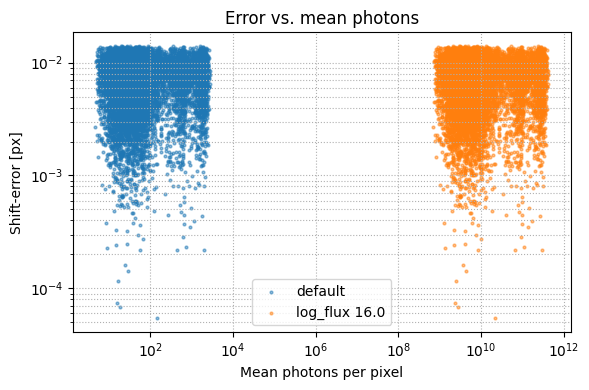

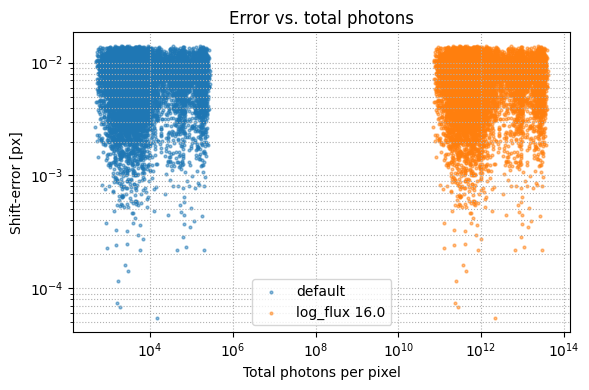

In [77]:
#!/usr/bin/env python3
import os
import numpy as np
import matplotlib.pyplot as plt
import jax, jax.numpy as jnp
from jax import jacfwd, jit
from scipy.ndimage import map_coordinates
from scipy.stats.qmc import Sobol
from tqdm import trange
import dLuxToliman
import dLux.utils as dlu
from interpax import interp2d

# ───────────────────────── USER PARAMETERS ─────────────────────────────
K_final        = 100       # number of dithers/frames to process
dither_half_px = 3        # ± throw in detector pixels
read_var       = 3.27**2    # read-noise variance (e⁻²)
lam            = 1e-4       # Tikhonov regularizer for LS
eps            = 1e-12      # avoid division by zero in weights
# ────────────────────────────────────────────────────────────────────────

# ─── enable 64-bit for JAX ──────────────────────────────────────────────
os.environ["JAX_ENABLE_X64"] = "True"
jax.config.update("jax_enable_x64", True)

def warp(I_sup, field_sup, order="cubic"):
    """
    I_sup: (Hsup, Wsup) oversampled PSF
    field_sup: (Hsup, Wsup, 2) displacement field [dx,dy] in sup-px
    returns: warped PSF on the same (Hsup,Wsup) grid
    """
    Hsup, Wsup = I_sup.shape

    # original grid coordinates
    ys = jnp.arange(Hsup)
    xs = jnp.arange(Wsup)

    # query points: for each sup-pixel we want I_sup(y - dy, x - dx)
    # broadcast to full grid:
    coords_y = (ys[:,None] - field_sup[...,1]).ravel()
    coords_x = (xs[None,:] - field_sup[...,0]).ravel()

    # perform 2D interpolation
    warped_flat = interp2d(
        xq=coords_y,   # query x
        yq=coords_x,   # query y
        x=xs,          # original sample x = 0..Wsup-1
        y=ys,          # original sample y = 0..Hsup-1
        f=I_sup,       # values on the grid
        method=order,  # "cubic", "linear", etc.
        extrap=False
    )

    # reshape back to (Hsup, Wsup)
    return warped_flat.reshape(Hsup, Wsup)


# ─── build optics & Sobol macro-dithers ─────────────────────────────────
opt        = dLuxToliman.TolimanOpticalSystem(wf_npixels=256,
                                              psf_npixels=128,
                                              oversample=4)
ovsp       = opt.oversample
arcsec_det = opt.psf_pixel_scale
arcsec_sup = arcsec_det/ovsp

sob = Sobol(2, scramble=False)
pts = sob.random_base2(int(np.ceil(np.log2(max(K_final-1,1)))))[:K_final-1]
pts = (pts - 0.5)*2*dither_half_px
macro = np.vstack([[0.0,0.0], pts]) * arcsec_det   # (K_final,2)

# ─── ground-truth shifts & QE map ──────────────────────────────────────
rng       = np.random.default_rng(0)
shift_det = rng.uniform(-0.01,0.01,(128,128,2))
delta_rho = rng.uniform(-0.05,0.00,(128,128))
rho_det   = 1.0 + delta_rho

field_sup_base = np.kron(shift_det*ovsp, np.ones((ovsp,ovsp,1)))
rho_sup2d_base = np.kron(rho_det,       np.ones((ovsp,ovsp)))

H = W = 128

# ─── loop over two flux settings: default and logflux=16.0 ──────────────
settings = [
    ("default",       None),
    ("log_flux 16.0", 16.0),
]

results = {}

for label, logflux in settings:
    # define PSF and gradient functions
    def psf_field(t):
        dx, dy = t
        if logflux is None:
            src = dLuxToliman.sources.AlphaCen(
                n_wavels=5,
                separation=10.,
                position_angle=90.,
                x_position=dx,
                y_position=dy
            )
        else:
            src = dLuxToliman.sources.AlphaCen(
                n_wavels=5,
                separation=10.,
                position_angle=90.,
                x_position=dx,
                y_position=dy,
                log_flux=logflux
            )
        tel = dLuxToliman.telescopes.Toliman(opt, src)
        return tel.model().astype(jnp.float64)

    def psf_reference(t=(0.0, 0.0)):
        """Reference PSF at center position"""
        dx, dy = t
        if logflux is None:
            src = dLuxToliman.sources.AlphaCen(
                n_wavels=5, separation=10., position_angle=90.,
                x_position=dx, y_position=dy
            )
        else:
            src = dLuxToliman.sources.AlphaCen(
                n_wavels=5, separation=10., position_angle=90.,
                x_position=dx, y_position=dy, log_flux=logflux
            )
        tel = dLuxToliman.telescopes.Toliman(opt, src)
        return tel.model().astype(jnp.float64)

    psf_jit = jit(psf_field)
    grad_jit = jit(jacfwd(psf_field, holomorphic=False))
    
    # Compute reference PSF and gradients at (0,0)
    psf_ref_jit = jit(psf_reference)
    grad_ref_jit = jit(jacfwd(psf_reference, holomorphic=False))

    I_ref_sup = np.asarray(psf_ref_jit(jnp.array([0.0, 0.0])))
    G_ref_sup = np.asarray(grad_ref_jit(jnp.array([0.0, 0.0])))
    gx_ref_sup, gy_ref_sup = G_ref_sup[...,0], G_ref_sup[...,1]

    # Downsample reference PSF and gradients
    I_ref_det = dlu.downsample(I_ref_sup, ovsp)
    gx_ref_det = dlu.downsample(gx_ref_sup, ovsp)
    gy_ref_det = dlu.downsample(gy_ref_sup, ovsp)

    # initialize accumulators
    sum_phot = np.zeros((H, W))
    A00 = np.zeros((H,W)); A01 = np.zeros_like(A00); A02 = np.zeros_like(A00)
    A11 = np.zeros_like(A00); A12 = np.zeros_like(A00); A22 = np.zeros_like(A00)
    b0  = np.zeros_like(A00); b1  = np.zeros_like(A00); b2  = np.zeros_like(A00)

    # Collect all measurements first (like your working version)
    measurements = []
    ideal_psfs = []
    gradients_x = []
    gradients_y = []
    
    for k in trange(K_final, desc=f"{label}: collecting data"):
        dx_k, dy_k = macro[k]

        # (1) Compute ideal PSF at dither position
        I_sup = np.asarray(psf_jit(jnp.array([dx_k, dy_k])))
        G_sup = np.asarray(grad_jit(jnp.array([dx_k, dy_k])))
        gx_sup, gy_sup = G_sup[...,0], G_sup[...,1]
        
        # (2) Apply distortion and QE
        dist_sup = warp(I_sup, field_sup_base)
        qe_sup = dist_sup * rho_sup2d_base
        
        # (3) Downsample to detector
        I_det = dlu.downsample(I_sup, ovsp)
        qe_det = dlu.downsample(qe_sup, ovsp)
        gx_det = dlu.downsample(gx_sup, ovsp)
        gy_det = dlu.downsample(gy_sup, ovsp)
        
        # (4) Add noise
        var_det = qe_det + read_var
        meas_det = qe_det + rng.normal(scale=np.sqrt(var_det), size=var_det.shape)
        
        # (5) Store for later processing
        measurements.append(meas_det)
        ideal_psfs.append(I_det)
        gradients_x.append(gx_det)
        gradients_y.append(gy_det)
        
        # (6) Accumulate photons
        sum_phot += qe_det
    
    # Convert to arrays
    measurements = np.array(measurements)  # (K, H, W)
    ideal_psfs = np.array(ideal_psfs)      # (K, H, W)
    gradients_x = np.array(gradients_x)    # (K, H, W)
    gradients_y = np.array(gradients_y)    # (K, H, W)
    
    # Now solve per-pixel like your working version
    dx_det = np.zeros((H, W))
    dy_det = np.zeros((H, W))
    dr_det = np.zeros((H, W))
    
    for i in range(H):
        for j in range(W):
            # Build design matrix G for pixel (i,j)
            G = np.stack([
                -gradients_x[:, i, j],  # dx coefficient
                -gradients_y[:, i, j],  # dy coefficient
                ideal_psfs[:, i, j]     # dr coefficient
            ], axis=1)  # (K, 3)
            
            # Residual vector
            r = measurements[:, i, j] - ideal_psfs[:, i, j]  # (K,)
            
            # Solve with regularization
            A = G.T @ G + lam * np.eye(3)
            b = G.T @ r
            
            try:
                solution = np.linalg.solve(A, b)
                dx_det[i, j], dy_det[i, j], dr_det[i, j] = solution
            except np.linalg.LinAlgError:
                # Handle singular matrix by setting to zero
                dx_det[i, j] = dy_det[i, j] = dr_det[i, j] = 0.0

    # solve per-pixel LS
    A00 += lam; A11 += lam; A22 += lam
    A = np.zeros((H,W,3,3))
    A[...,0,0],A[...,0,1],A[...,0,2] = A00,A01,A02
    A[...,1,0],A[...,1,1],A[...,1,2] = A01,A11,A12
    A[...,2,0],A[...,2,1],A[...,2,2] = A02,A12,A22
    b = np.stack([b0,b1,b2], axis=-1)

    sol    = (np.linalg.inv(A.reshape(-1,3,3))
              @ b.reshape(-1,3)[...,None]).squeeze(-1)
    dx_det = sol[:,0].reshape(H,W)
    dy_det = sol[:,1].reshape(H,W)

    # compute per-pixel error
    err_x   = dx_det/arcsec_det - shift_det[...,0]
    err_y   = dy_det/arcsec_det - shift_det[...,1]
    err_mag = np.sqrt(err_x**2 + err_y**2)

    # record metrics
    mean_phot  = sum_phot / K_final
    total_phot = sum_phot
    results[label] = (mean_phot, total_phot, err_mag)

# ─── overlay plots ─────────────────────────────────────────────────────
# Error vs. mean photons
plt.figure(figsize=(6,4))
for label in results:
    mean_phot, _, err_mag = results[label]
    mask = mean_phot > 0
    plt.scatter(mean_phot[mask], err_mag[mask], s=4, alpha=0.5, label=label)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Mean photons per pixel")
plt.ylabel("Shift-error [px]")
plt.title("Error vs. mean photons")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

# Error vs. total photons
plt.figure(figsize=(6,4))
for label in results:
    _, total_phot, err_mag = results[label]
    mask = total_phot > 0
    plt.scatter(total_phot[mask], err_mag[mask], s=4, alpha=0.5, label=label)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Total photons per pixel")
plt.ylabel("Shift-error [px]")
plt.title("Error vs. total photons")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

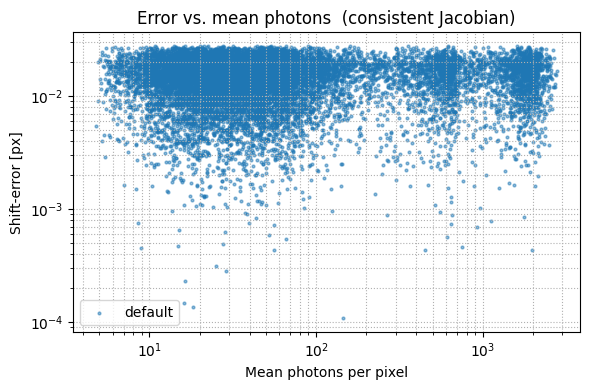

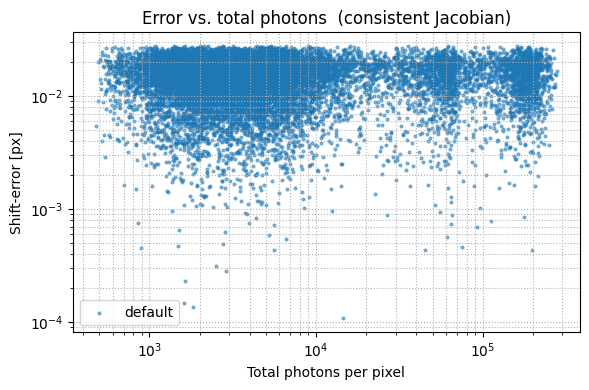

In [68]:
plt.figure(figsize=(6,4))
for lbl,(mph,_,err) in results.items():
    m = (mph>0)&(err>0)
    plt.scatter(mph[m],err[m],s=4,alpha=0.5,label=lbl)
plt.xscale('log'); plt.yscale('log'); plt.grid(True,which='both',ls=':')
plt.xlabel('Mean photons per pixel'); plt.ylabel('Shift-error [px]')
plt.title('Error vs. mean photons  (consistent Jacobian)'); plt.legend(); plt.tight_layout()

plt.figure(figsize=(6,4))
for lbl,(_,tph,err) in results.items():
    m = (tph>0)&(err>0)
    plt.scatter(tph[m],err[m],s=4,alpha=0.5,label=lbl)
plt.xscale('log'); plt.yscale('log'); plt.grid(True,which='both',ls=':')
plt.xlabel('Total photons per pixel'); plt.ylabel('Shift-error [px]')
plt.title('Error vs. total photons  (consistent Jacobian)'); plt.legend(); plt.tight_layout()
plt.show()


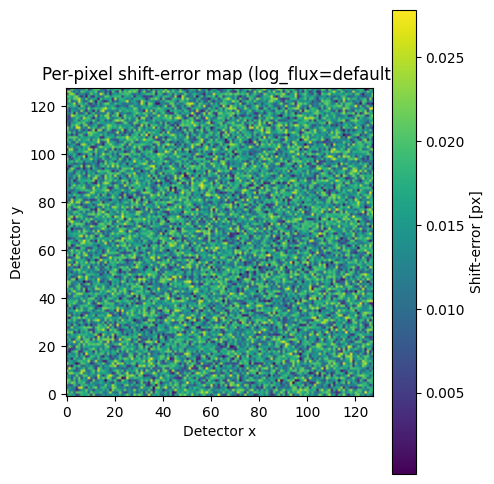

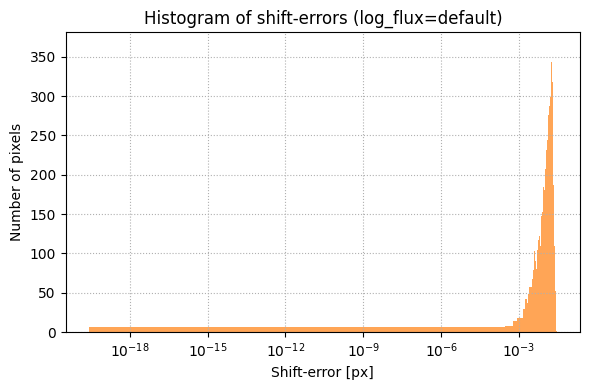

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack the high-flux (“orange”) results from your existing `results` dict
mean_phot, total_phot, err_orange = results["default"]

# 1) Show the per-pixel error map
plt.figure(figsize=(5,5))
plt.imshow(err_orange, origin="lower", cmap="viridis")
plt.colorbar(label="Shift-error [px]")
plt.title("Per-pixel shift-error map (log_flux=default)")
plt.xlabel("Detector x")
plt.ylabel("Detector y")
plt.tight_layout()
plt.show()

# 2) Prepare for the histogram: flatten and drop NaNs / negative values
errs = err_orange.ravel()
mask = np.isfinite(errs) & (errs >= 0)
errs = errs[mask]

# 3) Plot the histogram of shift-errors
plt.figure(figsize=(6,4))
plt.hist(errs, bins=100, range=(0, errs.max()), color="C1", alpha=0.7)
plt.xlabel("Shift-error [px]")
plt.ylabel("Number of pixels")
plt.title("Histogram of shift-errors (log_flux=)")
plt.xscale("log")
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()


In [ ]:
# NOISE AND WEIGHTING BY VARIANCE VECTORISED (crashes for large dithers)
import os
# ─── enable 64-bit in JAX ─────────────────────────────────────────────
os.environ["JAX_ENABLE_X64"] = "True"

import numpy as np
from scipy.ndimage import map_coordinates
import dLuxToliman

import jax
from jax import config as jax_cfg
jax_cfg.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import jacfwd, jit
import jax.random as jr
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# ─── helper functions ───────────────────────────────────────────────────
def warp(img, field_sup, order=2):
    dy, dx = field_sup[...,1], field_sup[...,0]
    y, x   = np.indices(img.shape)
    return map_coordinates(img, [y-dy, x-dx],
                           order=order, mode="reflect")

def downsample_stack(arr, factor):
    # downsample by simple block‐mean
    K, Hs, Ws = arr.shape
    Hd, Wd    = Hs//factor, Ws//factor
    return arr.reshape(K, Hd, factor, Wd, factor).mean(axis=(2,4))

# ─── 1) optics & dithers ────────────────────────────────────────────────
opt        = dLuxToliman.TolimanOpticalSystem(
               wf_npixels=256, psf_npixels=128, oversample=4
            )
ovsp       = opt.oversample
arcsec_det = opt.psf_pixel_scale
arcsec_sup = arcsec_det / ovsp

# Sobol dithers for reproducibility
sob    = Sobol(d=2, scramble=False)
K      = 1001
pts    = sob.random_base2(int(np.ceil(np.log2(K-1))))[:K-1]
pts    = (pts - 0.5) * 2  # to [-1,1]
dith_arc = jnp.vstack([jnp.zeros((1,2)), pts]) * arcsec_det  # (K,2)

# ─── 2) ideal PSFs + autodiff grads ────────────────────────────────────
def psf_from_tilt(tt):
    dx, dy = tt
    src = dLuxToliman.sources.AlphaCen(
            n_wavels=5, separation=10., position_angle=90.,
            x_position=dx, y_position=dy
          )
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model().astype(np.float64)  # (512,512)

ideal_sup = np.stack([psf_from_tilt(tt) for tt in dith_arc], axis=0)  # (K,512,512)

# ∂I/∂dx, ∂I/∂dy via autodiff
grad_fn   = jacfwd(lambda tt: jnp.asarray(psf_from_tilt(tt)))
grads_sup = np.stack([np.asarray(grad_fn(tt)) for tt in dith_arc], axis=0)
gx_sup, gy_sup = grads_sup[...,0], grads_sup[...,1]                # (K,512,512)

# ─── 3) truth shifts & QE ───────────────────────────────────────────────
rng        = np.random.default_rng(0)
shift_det  = rng.uniform(-0.01,0.01,(128,128,2))
mask_shift = np.ones((128,128),bool)
shift_det *= mask_shift[...,None]

delta_rho  = rng.uniform(-0.05,0.00,(128,128))
mask_qe    = np.ones((128,128),bool)
delta_rho *= mask_qe
rho_det    = 1.0 + delta_rho

field_sup  = np.kron(shift_det*ovsp, np.ones((ovsp,ovsp,1)))  # (512,512,2)
rho_sup2d  = np.kron(rho_det,       np.ones((ovsp,ovsp)))    # (512,512)

# ─── 4) simulate measurements + noise ───────────────────────────────────
dist_sup  = np.stack([warp(im, field_sup) for im in ideal_sup], axis=0)
meas_sup  = dist_sup * rho_sup2d[None,...]

# shot (Var=I) + read noise
read_sigma2  = 3.27**2
photon_var   = meas_sup
sigma2_sup   = photon_var + read_sigma2
noise_sup    = rng.normal(scale=np.sqrt(sigma2_sup), size=sigma2_sup.shape)
meas_sup    += noise_sup

R_sup = meas_sup - ideal_sup  # (K,512,512)

# ─── 5) down-sample everything to 128×128 ────────────────────────────────
ideal = downsample_stack(ideal_sup, ovsp)  # (K,128,128)
R     = downsample_stack(R_sup,     ovsp)
gx    = downsample_stack(gx_sup,    ovsp)
gy    = downsample_stack(gy_sup,    ovsp)
# propagate variance for the mean: Var(mean)=mean(var)/N
sigma2_det = downsample_stack(sigma2_sup, ovsp) / (ovsp*ovsp)  # (K,128,128)

# ─── 6) JAX-vectorised full variance‐weighted 3×3 LS solve ─────────────
lam = jnp.array(1e-4, dtype=jnp.float64)

@jit
def solve_weighted(R, gx, gy, I, sigma2):
    # R,gx,gy,I,sigma2 all (K,H,W)
    w = 1.0 / jnp.sqrt(sigma2)                # statistical weights
    Rw = R * w
    G1 = -gx * w
    G2 = -gy * w
    G3 =  I * w
    G  = jnp.stack([G1, G2, G3], axis=-1)     # (K,H,W,3)

    A  = jnp.einsum('khwj,khwl->hwjl', G, G)
    A += lam * jnp.eye(3, dtype=jnp.float64)
    b  = jnp.einsum('khwj,khw->hwj',   G, Rw)

    sol = jnp.linalg.solve(A, b[...,None]).squeeze(-1)  # (H,W,3)
    return sol[...,0], sol[...,1], sol[...,2]

dx_det_j, dy_det_j, dr_det_j = solve_weighted(
    jnp.asarray(R,        dtype=jnp.float64),
    jnp.asarray(gx,       dtype=jnp.float64),
    jnp.asarray(gy,       dtype=jnp.float64),
    jnp.asarray(ideal,    dtype=jnp.float64),
    jnp.asarray(sigma2_det, dtype=jnp.float64),
)

dx_det = np.array(dx_det_j)   # make writeable
dy_det = np.array(dy_det_j)
dr_det = np.array(dr_det_j)

# ─── 7) χ² on supersampled grid ─────────────────────────────────────────
est_perpix = np.stack([-dx_det/arcsec_sup, -dy_det/arcsec_sup], axis=-1)
est_sup    = np.kron(est_perpix, np.ones((ovsp,ovsp,1)))
undist_sup0 = warp(dist_sup[0], -est_sup)

chi2_dist = np.sum((ideal_sup[0] - dist_sup[0])**2)
chi2_corr = np.sum((ideal_sup[0] - undist_sup0)**2)

print(f"χ² distorted : {chi2_dist:,.0f}")
print(f"χ² corrected : {chi2_corr:,.0f}")
print("Mean |Δx|   :", np.mean(np.abs(dx_det[mask_shift])))
print("Mean |Δy|   :", np.mean(np.abs(dy_det[mask_shift])))
print("Mean |δρ|   :", np.mean(np.abs(dr_det[mask_qe])))

# ─── 8) plotting (same as before) ───────────────────────────────────────
step = 8
H, W = dx_det.shape
Xf, Yf = np.meshgrid(np.arange(W), np.arange(H))
X, Y = Xf[::step, ::step], Yf[::step, ::step]

Ur = (-dx_det / arcsec_det)[::step, ::step]
Vr = (-dy_det / arcsec_det)[::step, ::step]
Ut = shift_det[...,0][::step, ::step]
Vt = shift_det[...,1][::step, ::step]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax1.quiver(X,Y,Ur,Vr,scale=0.15); ax1.set_title("Recovered shifts (det grid)")
ax1.invert_yaxis()
ax2.quiver(X,Y,Ut,Vt,scale=0.15,color='C3'); ax2.set_title("True shifts (det grid)")
ax2.invert_yaxis()
plt.tight_layout(); plt.show()

def triple_heat(true, rec, title, label):
    vmax = max(abs(true).max(), abs(rec).max())
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)
    fig,(a0,a1,a2)=plt.subplots(1,3,figsize=(12,5),sharex=True,sharey=True)
    a0.imshow(true,origin='lower',cmap='bwr',norm=norm); a0.set_title(f"True {title}")
    a1.imshow(rec, origin='lower',cmap='bwr',norm=norm); a1.set_title(f"Recovered {title}")
    a2.imshow(true-rec,origin='lower',cmap='bwr',norm=norm); a2.set_title(f"Residual {title}")
    fig.colorbar(a1.images[0], ax=[a0,a1,a2], shrink=0.8, label=label)
    plt.show()

step_hm = 8
t_dx = shift_det[...,0][::step_hm, ::step_hm]
t_dy = shift_det[...,1][::step_hm, ::step_hm]
r_dx = (-dx_det/arcsec_det)[::step_hm, ::step_hm]
r_dy = (-dy_det/arcsec_det)[::step_hm, ::step_hm]
t_rho= delta_rho   [::step_hm, ::step_hm]
r_rho= dr_det      [::step_hm, ::step_hm]

triple_heat(t_dx, r_dx, 'Δx (det-px)', 'Δx [px]')
triple_heat(t_dy, r_dy, 'Δy (det-px)', 'Δy [px]')
triple_heat(t_rho,r_rho, 'δρ',       'δρ')


: 

In [ ]:
# LS + HS two-stage recovery
"""
Two‐stage recovery with HS‐refined shifts baked into dx_det/dy_det.

1) Accumulate all 501 dithers with inverse‐variance–weighted LS → (dx_det, dy_det, dr_det).
2) Apply that 128×128 estimate to dist0_sup → undist0_sup_initial (χ² ≈ 1e5).
3) Run Horn–Schunck once on (psf0_sup, undist0_sup_initial) to get residual_shifts_sup.
4) Convert residual_shifts_sup (512×512) → HS_res_det_x, HS_res_det_y (128×128),
   then do:
     dx_det += HS_res_det_x
     dy_det += HS_res_det_y
   so that dx_det/dy_det now hold the final LS + HS shifts on 128×128.
5) Warp undist0_sup_initial by +residual_shifts_sup → undist0_sup_refined (for χ² only).
6) Print diagnostics; dx_det/dy_det are now the HS‐refined shifts.
"""

import os
os.environ["JAX_ENABLE_X64"] = "True"

import numpy as np
from scipy.ndimage import map_coordinates
import dLuxToliman

import jax
import jax.numpy as jnp
from jax import jacfwd
from jax.scipy.ndimage import map_coordinates as jmap_coordinates

from scipy.stats.qmc import Sobol
from tqdm import trange


# ─── Horn–Schunck optical‐flow routines (JAX) ─────────────────────────────────

def horn_schunck_shifts(ideal: jnp.ndarray,
                        observed: jnp.ndarray,
                        pixel_scale: float = 1.0,
                        alpha: float = 0.1,
                        n_iters: int = 100) -> jnp.ndarray:
    """
    Horn–Schunck on (ideal, observed) → (H,H,2) shift field in pixel units.
    - ideal, observed: both (H,H) jnp arrays.
    - pixel_scale = 1.0 means “u,v” come out in pixels directly.
    """
    Ix = jnp.zeros_like(ideal)
    Iy = jnp.zeros_like(ideal)
    # ∂I/∂x via central difference:
    Ix = Ix.at[:, 1:-1].set((ideal[:, 2:] - ideal[:, :-2]) / (2 * pixel_scale))
    # ∂I/∂y via central difference:
    Iy = Iy.at[1:-1, :].set((ideal[2:, :] - ideal[:-2, :]) / (2 * pixel_scale))
    It = observed - ideal

    u = jnp.zeros_like(ideal)
    v = jnp.zeros_like(ideal)

    def avg(z):
        return 0.25 * (
            jnp.pad(z[1:  ,   :], ((0,1),(0,0))) +
            jnp.pad(z[:-1 ,   :], ((1,0),(0,0))) +
            jnp.pad(z[:, 1:  ], ((0,0),(0,1))) +
            jnp.pad(z[:, :-1 ], ((0,0),(1,0)))
        )

    for _ in range(n_iters):
        u_bar = avg(u)
        v_bar = avg(v)
        num   = (Ix * u_bar + Iy * v_bar + It)
        den   = alpha**2 + Ix**2 + Iy**2
        u = u_bar - Ix * (num / den)
        v = v_bar - Iy * (num / den)

    return jnp.stack([u, v], axis=-1)


def sample_image_with_shifts_jax(image: jnp.ndarray,
                                 shifts_pix: jnp.ndarray,
                                 order: int = 1) -> jnp.ndarray:
    """
    Warp a 2D jnp array “image” at sub–pixel shifts given by shifts_pix (H,H,2),
    using bilinear interpolation.  Returns a (H,H) jnp array.
    """
    npix = image.shape[-1]
    coords = jnp.arange(npix)
    centers = coords - (npix - 1)/2
    gx, gy = jnp.meshgrid(centers, centers, indexing='xy')
    ix = (gx + shifts_pix[..., 0]) + (npix - 1)/2
    iy = (gy + shifts_pix[..., 1]) + (npix - 1)/2
    coords_flat = jnp.stack([iy.ravel(), ix.ravel()], axis=0)
    warped = jmap_coordinates(image, coords_flat, order=order, mode='reflect')
    return warped.reshape((npix, npix))


# ─── NumPy warping & downsampling ─────────────────────────────────────────────

def warp_np(img: np.ndarray, field_sup: np.ndarray, order: int = 2) -> np.ndarray:
    """
    Warp a numpy 2D array “img” by shift‐field field_sup (H_sup,W_sup,2).
    field_sup[...,0] = dx (in pixels), field_sup[...,1] = dy (in pixels).
    """
    dy, dx = field_sup[..., 1], field_sup[..., 0]
    y,  x   = np.indices(img.shape)
    return map_coordinates(img, [y - dy, x - dx], order=order, mode="reflect")


def downsample(arr_sup: np.ndarray, factor: int) -> np.ndarray:
    """
    Block‐mean downsample arr_sup by integer “factor” each dimension.
    If arr_sup is (H_sup, W_sup), returns (H_sup//factor, W_sup//factor).
    """
    Hs, Ws = arr_sup.shape
    Hd, Wd = Hs // factor, Ws // factor
    return arr_sup.reshape(Hd, factor, Wd, factor).mean(axis=(1, 3))


# ─── 1) Optical system + Sobol dithers ────────────────────────────────────────

opt  = dLuxToliman.TolimanOpticalSystem(wf_npixels=256,
                                        psf_npixels=128,
                                        oversample=4)
ovsp        = opt.oversample           # 4 → supersampled = 128×4 = 512
arcsec_det  = opt.psf_pixel_scale      # arcsec per 128×128 pixel
arcsec_sup  = arcsec_det / ovsp        # arcsec per 512×512 pixel

sob = Sobol(d=2, scramble=False)
K   = 1001
pts = sob.random_base2(int(np.ceil(np.log2(K-1))))[:K-1]
pts = (pts - 0.5) * 2
dith_arc = np.vstack([[0.0, 0.0], pts]) * arcsec_det   # shape (501,2)


# ─── 2) Build PSF + gradient functions (NumPy & JAX) ────────────────────────

def psf_np(tt):
    dx, dy = map(float, tt)
    src = dLuxToliman.sources.AlphaCen(n_wavels=5, separation=10.,
                                       position_angle=90.,
                                       x_position=dx, y_position=dy)
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model().astype(np.float64)

def psf_jax(tt):
    dx, dy = tt
    src = dLuxToliman.sources.AlphaCen(n_wavels=5, separation=10.,
                                       position_angle=90.,
                                       x_position=dx, y_position=dy)
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model().astype(jnp.float64)

grad_fn = jacfwd(psf_jax, holomorphic=False)


# ─── 3) “Truth” detector defects & QE on 128×128 grid ───────────────────────

rng       = np.random.default_rng(0)
shift_det = rng.uniform(-0.01, 0.01, (128,128,2))
delta_rho = rng.uniform(-0.05, 0.00, (128,128))
rho_det   = 1.0 + delta_rho

field_sup_base = np.kron(shift_det * ovsp, np.ones((ovsp, ovsp, 1)))   # (512,512,2)
rho_sup2d_base = np.kron(rho_det,         np.ones((ovsp, ovsp)))      # (512,512)

psf0_sup     = psf_np((0.0, 0.0))                      
dist0_sup    = warp_np(psf0_sup, field_sup_base)       
chi2_dist_ref = np.sum((psf0_sup - dist0_sup)**2)


# ─── 4) Prepare accumulators on the 128×128 detector grid ──────────────────

Hdet = Wdet = 128
A00 = np.zeros((Hdet, Wdet));  A01 = np.zeros_like(A00); A02 = np.zeros_like(A00)
A11 = np.zeros_like(A00);     A12 = np.zeros_like(A00); A22 = np.zeros_like(A00)
b0  = np.zeros_like(A00);     b1  = np.zeros_like(A00); b2  = np.zeros_like(A00)

read_var   = 3.27**2
ideal_list = []
eps = 1e-12


# ─── 5) Main dither loop (501 frames; no Horn–Schunck here) ────────────────

for k in trange(K, desc="Accumulating"):
    dx_k, dy_k = dith_arc[k]
    tt_jax = jnp.array([dx_k, dy_k], dtype=jnp.float64)

    I_sup_jnp = psf_jax(tt_jax)            
    G_sup_jnp = grad_fn(tt_jax)            
    I_sup     = np.asarray(I_sup_jnp)     
    gx_sup    = np.asarray(G_sup_jnp[..., 0])
    gy_sup    = np.asarray(G_sup_jnp[..., 1])

    dist_sup  = warp_np(I_sup, field_sup_base)

    meas_sup  = dist_sup * rho_sup2d_base      
    var_sup   = meas_sup + read_var            
    noise_sup = rng.normal(scale=np.sqrt(var_sup), size=var_sup.shape)
    meas_sup += noise_sup                      

    R_sup = meas_sup - I_sup                  

    I_det   = downsample(I_sup,  ovsp)                    
    R_det   = downsample(R_sup,  ovsp)                    
    gx_det  = downsample(gx_sup, ovsp)                    
    gy_det  = downsample(gy_sup, ovsp)                    
    var_det = downsample(var_sup, ovsp) / (ovsp*ovsp)     

    w = 1.0 / (var_det + eps)

    A00 += w * gx_det * gx_det
    A01 += w * gx_det * gy_det
    A02 += w * (-gx_det * I_det)
    A11 += w * gy_det * gy_det
    A12 += w * (-gy_det * I_det)
    A22 += w * I_det   * I_det

    b0  += w * (-gx_det * R_det)
    b1  += w * (-gy_det * R_det)
    b2  += w * ( I_det * R_det)

    ideal_list.append(I_det)


# ─── 6) Regularize & solve each 3×3 system → (dx_det, dy_det, dr_det) ───────

lam = 1e-4
A00 += lam;  A11 += lam;  A22 += lam

dx_det = np.empty_like(A00)
dy_det = np.empty_like(A00)
dr_det = np.empty_like(A00)

for i in range(Hdet):
    for j in range(Wdet):
        A = np.array([[ A00[i,j], A01[i,j], A02[i,j] ],
                      [ A01[i,j], A11[i,j], A12[i,j] ],
                      [ A02[i,j], A12[i,j], A22[i,j] ]])
        b = np.array([ b0[i,j], b1[i,j], b2[i,j] ])
        dx_det[i,j], dy_det[i,j], dr_det[i,j] = np.linalg.solve(A, b)


# ─── 7) Build supersampled estimate field and warp dist0_sup → undist0_sup_initial ─

est_perpix = np.stack([ -dx_det/arcsec_sup, -dy_det/arcsec_sup ], axis=-1)   # (128,128,2)
est_sup    = np.kron(est_perpix, np.ones((ovsp, ovsp, 1)))                  # (512,512,2)

undist0_sup_initial = warp_np(dist0_sup, -est_sup)

chi2_first = np.sum((psf0_sup - undist0_sup_initial)**2)


# ─── 8) ONE‐SHOT Horn–Schunck on (psf0_sup, undist0_sup_initial) ────────────

I0_sup_jnp      = jnp.array(psf0_sup)
undist0_jnp     = jnp.array(undist0_sup_initial)

residual_shifts_sup = horn_schunck_shifts(
    I0_sup_jnp,
    undist0_jnp,
    pixel_scale=1.0,
    alpha=0.1,
    n_iters=200
)  # (512,512,2) jnp

# Convert HS residual → numpy
HS_res_sup = np.asarray(residual_shifts_sup)   # shape (512,512,2)

# Convert supersampled HS residuals to detector pixels by averaging 4×4 blocks
HS_res_det_x = (HS_res_sup[..., 0].reshape(128, ovsp, 128, ovsp)
                .mean(axis=(1, 3)))
HS_res_det_y = (HS_res_sup[..., 1].reshape(128, ovsp, 128, ovsp)
                .mean(axis=(1, 3)))

# ─── 9) UPDATE dx_det, dy_det to include HS correction ───────────────────────
dx_det += HS_res_det_x
dy_det += HS_res_det_y

# Build the final refined PSF (for χ² only)
undist0_sup_refined_jnp = sample_image_with_shifts_jax(
    undist0_jnp,
    residual_shifts_sup,  # apply +residual_shifts_sup
    order=1
)
undist0_sup_refined = np.asarray(undist0_sup_refined_jnp)
chi2_refined = np.sum((psf0_sup - undist0_sup_refined)**2)


# ─── 10) Print diagnostics ───────────────────────────────────────────────────

print(f"χ² distorted       : {chi2_dist_ref:,.0f}")
print(f"χ² after LS first   : {chi2_first:,.0f}")
print(f"χ² after HS refine  : {chi2_refined:,.0f}")
print("Mean |Δx| (final)  :", np.mean(np.abs(dx_det / arcsec_det)))
print("Mean |Δy| (final)  :", np.mean(np.abs(dy_det / arcsec_det)))
print("Mean |δρ| (LS-only):", np.mean(np.abs(dr_det)))


# ─── 11) Stack ideal PSFs for plotting downstream ───────────────────────────

ideal = np.stack(ideal_list, axis=0)   # shape (501,128,128)

Accumulating: 100%|██████████| 1001/1001 [06:59<00:00,  2.39it/s]


χ² distorted       : 3,433,571
χ² after LS first   : 52,190
χ² after HS refine  : 1,550
Mean |Δx| (final)  : 0.08967863290218676
Mean |Δy| (final)  : 0.09193206149519728
Mean |δρ| (LS-only): 0.025097228553097133


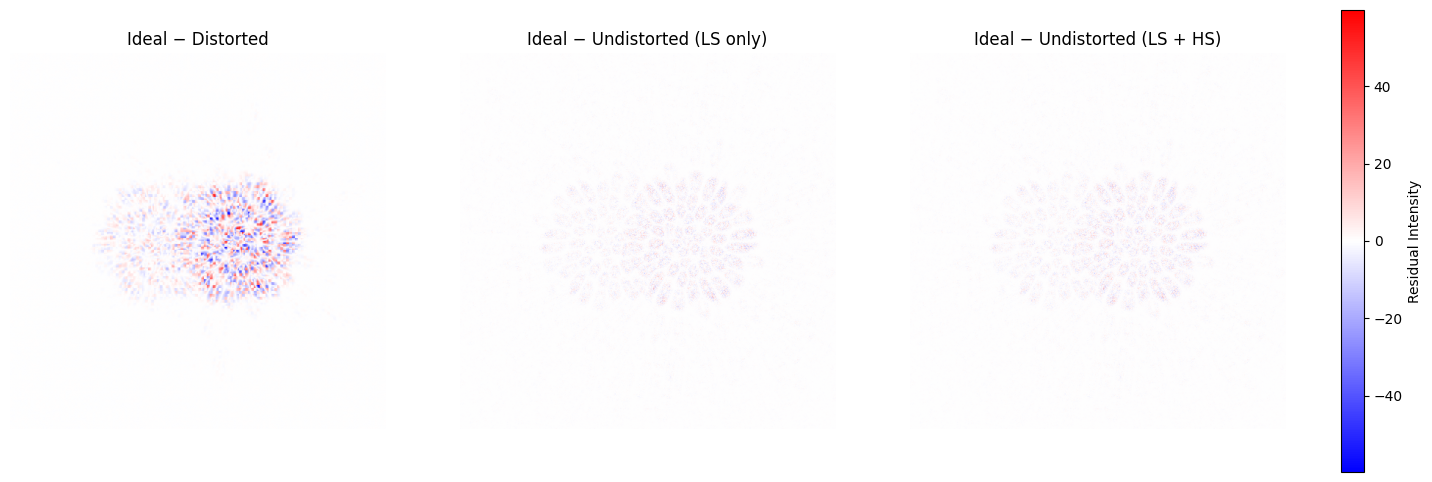

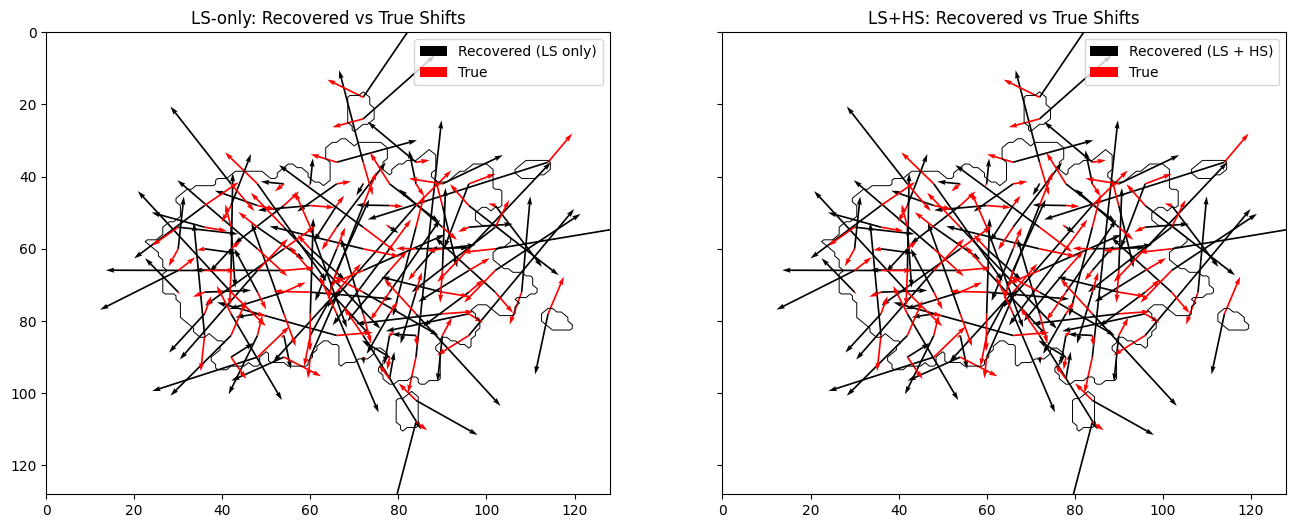

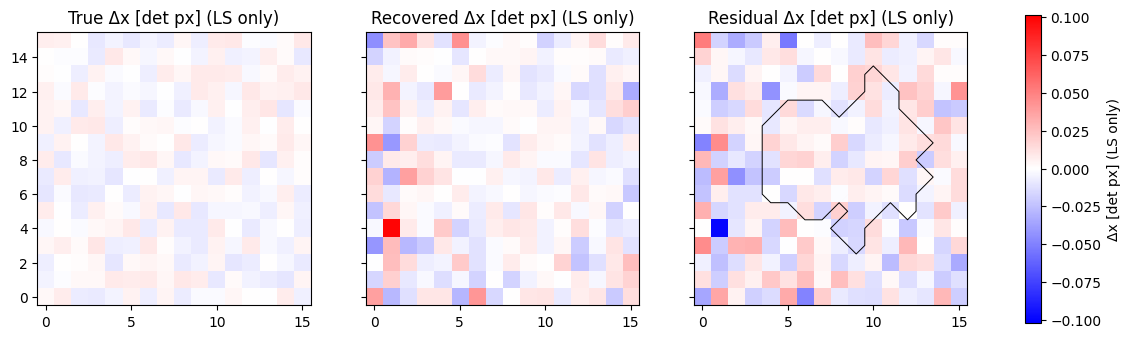

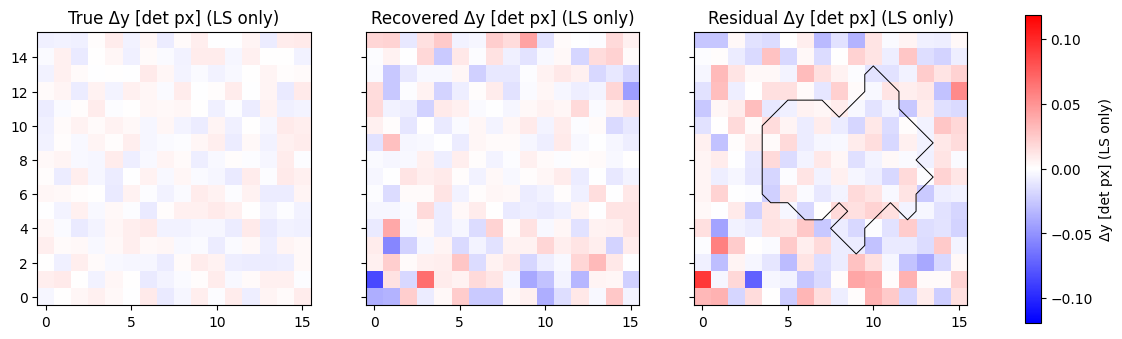

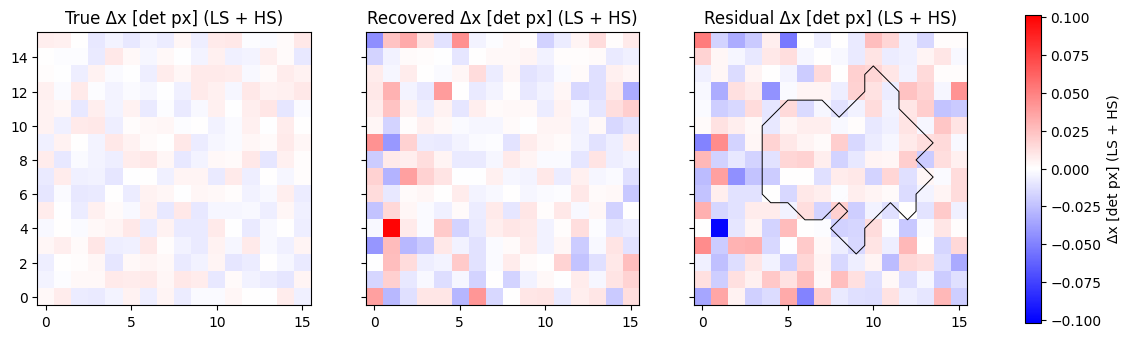

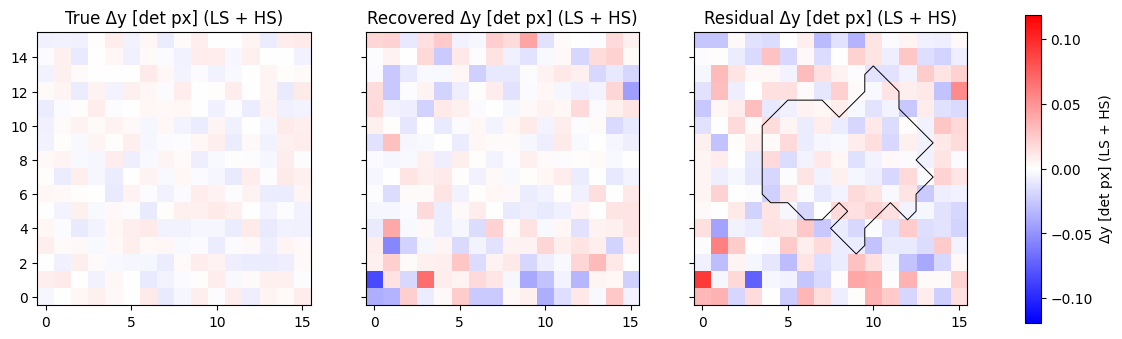

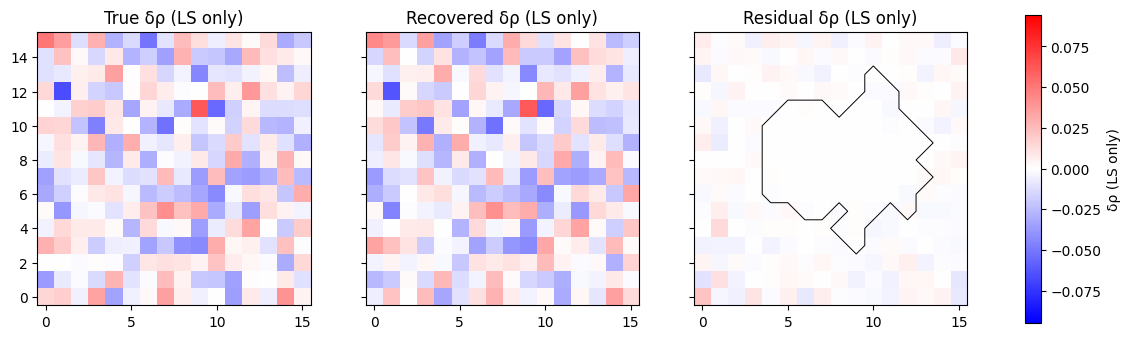

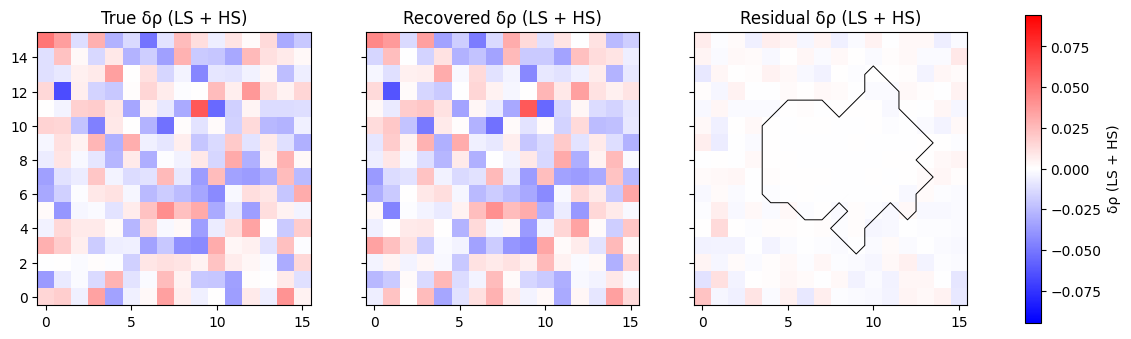

‖Ideal − Distorted‖₂       = 1.83e+03
‖Ideal − Undist (LS only)‖₂ = 5.49e+02
‖Ideal − Undist (LS+HS)‖₂   = 5.49e+02


In [134]:
# Plotting everything (including pixel sensitivity δρ)

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np

# ─── 0) RECONSTRUCT THE LS‐ONLY SHIFT ARRAYS ──────────────────────────────────
# dx_det, dy_det currently hold LS+HS (in detector px).  Undo HS to get LS‐only:
dx_ls = dx_det - HS_res_det_x      # LS‐only dx (in detector px)
dy_ls = dy_det - HS_res_det_y      # LS‐only dy (in detector px)

# ─── 1) SETUP AND MASKS ───────────────────────────────────────────────────────
PLOT_FRAC_QUIV = 0.03    # fraction of PSF peak to keep for quiver mask
PLOT_FRAC_HM   = 0    # fraction for heatmap mask (0→all)
CONTOUR_FRAC   = 0.03    # brightness threshold for PSF‐footprint outline
SHOW_CONTOUR   = True    # whether to draw that outline
QUIVER_STEP    = 6       # stride for quiver sampling (every 6 px)
HEAT_SUBSAMPLE = 8       # stride for heatmap subsampling
QUIVER_SCALE   = 0.15    # quiver arrow scale

# Mean PSF on 128×128
mean_psf = np.mean(ideal, axis=0)
peak = mean_psf.max()

mask_plot_QUIV = (mean_psf > PLOT_FRAC_QUIV * peak) if (PLOT_FRAC_QUIV > 0) else np.ones_like(mean_psf, bool)
mask_plot_HM   = (mean_psf > PLOT_FRAC_HM   * peak) if (PLOT_FRAC_HM   > 0) else np.ones_like(mean_psf, bool)
mask_contour   = (mean_psf > CONTOUR_FRAC * peak) if (CONTOUR_FRAC > 0) else np.ones_like(mean_psf, bool)

def add_outline(ax, mask, full_shape):
    """Draw a rectangle if mask is all‐True, otherwise draw a contour around mask=True."""
    if not SHOW_CONTOUR:
        return
    if mask.all():
        H, W = full_shape
        ax.add_patch(plt.Rectangle((0, 0), W, H, fill=False, lw=0.7, ec='k'))
    else:
        ax.contour(mask, levels=[0.5], colors='k', linewidths=0.7)


# ─── 2) PSF‐IMAGE RESIDUALS (512×512) ─────────────────────────────────────────
# Three 512×512 images: ideal vs. distorted, LS‐only, and LS+HS.

res_dist = psf0_sup - dist0_sup
res_ls   = psf0_sup - undist0_sup_initial
res_hs   = psf0_sup - undist0_sup_refined

# Use a common TwoSlopeNorm so all three panels share the same color scale
vmax_res = np.max(np.abs([res_dist, res_ls, res_hs]))
norm_res = TwoSlopeNorm(vmin=-vmax_res, vcenter=0.0, vmax=+vmax_res)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
im0 = axes[0].imshow(res_dist, origin='lower', cmap='bwr', norm=norm_res)
axes[0].set_title("Ideal − Distorted")
axes[0].axis('off')

im1 = axes[1].imshow(res_ls, origin='lower', cmap='bwr', norm=norm_res)
axes[1].set_title("Ideal − Undistorted (LS only)")
axes[1].axis('off')

im2 = axes[2].imshow(res_hs, origin='lower', cmap='bwr', norm=norm_res)
axes[2].set_title("Ideal − Undistorted (LS + HS)")
axes[2].axis('off')

fig.colorbar(im2, ax=axes, fraction=0.046, pad=0.04, label="Residual Intensity")
plt.show()


# ─── 3) SHIFT‐VECTOR QUIVER PLOTS (128×128) ───────────────────────────────────
H, W = dx_ls.shape  # 128×128
Yf, Xf = np.indices((H, W))
Xs = Xf[::QUIVER_STEP, ::QUIVER_STEP]
Ys = Yf[::QUIVER_STEP, ::QUIVER_STEP]
valid = mask_plot_QUIV[::QUIVER_STEP, ::QUIVER_STEP]

# True shifts in detector pixels:
Ut = shift_det[..., 0][::QUIVER_STEP, ::QUIVER_STEP][valid]
Vt = shift_det[..., 1][::QUIVER_STEP, ::QUIVER_STEP][valid]

# (a) LS‐only recovered (need to flip sign and convert to det‐px):
U_ls = (-dx_ls / arcsec_det)[::QUIVER_STEP, ::QUIVER_STEP][valid]
V_ls = (-dy_ls / arcsec_det)[::QUIVER_STEP, ::QUIVER_STEP][valid]

# (b) LS+HS recovered (also flip sign and convert):
U_hs = (-dx_det / arcsec_det)[::QUIVER_STEP, ::QUIVER_STEP][valid]
V_hs = (-dy_det / arcsec_det)[::QUIVER_STEP, ::QUIVER_STEP][valid]

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# LS‐only quiver
axs[0].quiver(
    Xs[valid], Ys[valid], U_ls, V_ls,
    color='k', scale=QUIVER_SCALE, width=0.003, label='Recovered (LS only)'
)
axs[0].quiver(
    Xs[valid], Ys[valid], Ut, Vt,
    color='r', scale=QUIVER_SCALE, width=0.003, label='True'
)
add_outline(axs[0], mask_contour, full_shape=(H, W))
axs[0].set_title("LS‐only: Recovered vs True Shifts")
axs[0].legend(loc='upper right')
axs[0].set_xlim(0, W); axs[0].set_ylim(H, 0)

# LS+HS quiver
axs[1].quiver(
    Xs[valid], Ys[valid], U_hs, V_hs,
    color='k', scale=QUIVER_SCALE, width=0.003, label='Recovered (LS + HS)'
)
axs[1].quiver(
    Xs[valid], Ys[valid], Ut, Vt,
    color='r', scale=QUIVER_SCALE, width=0.003, label='True'
)
add_outline(axs[1], mask_contour, full_shape=(H, W))
axs[1].set_title("LS+HS: Recovered vs True Shifts")
axs[1].legend(loc='upper right')
axs[1].set_xlim(0, W); axs[1].set_ylim(H, 0)

plt.show()


# ─── 4) SHIFT‐HEATMAPS (TRUE / REC / RESIDUAL) ─────────────────────────────────
def plot_shift_heatmaps(true_field, rec_field, title_prefix):
    """
    true_field, rec_field: both (128×128) arrays, in detector pixels.
    We mask out where PSF is low, then plot three side‐by‐side panels:
      True | Recovered | (True − Recovered),
    each with its own color scale.
    """
    t = true_field.copy()
    r = rec_field.copy()
    t[~mask_plot_HM] = np.nan
    r[~mask_plot_HM] = np.nan
    res = t - r

    vmax = np.nanmax(np.abs([t, r]))
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)

    t_sub   = t  [::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]
    r_sub   = r  [::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]
    res_sub = res[::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]
    mask_sub= mask_contour[::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    im0 = ax0.imshow(t_sub,   origin='lower', cmap='bwr', norm=norm)
    im1 = ax1.imshow(r_sub,   origin='lower', cmap='bwr', norm=norm)
    im2 = ax2.imshow(res_sub, origin='lower', cmap='bwr', norm=norm)

    add_outline(ax2, mask_sub, full_shape=res_sub.shape)

    ax0.set_title(f"True {title_prefix}")
    ax1.set_title(f"Recovered {title_prefix}")
    ax2.set_title(f"Residual {title_prefix}")

    fig.colorbar(im1, ax=[ax0, ax1, ax2], shrink=0.8, label=title_prefix)
    plt.show()


# (a) Δx heatmaps: LS only
plot_shift_heatmaps(
    true_field   = shift_det[..., 0],  # Δx true [det px]
    rec_field    = -dx_ls,             # Δx rec (LS only), flip sign
    title_prefix = "Δx [det px] (LS only)"
)

# (b) Δy heatmaps: LS only
plot_shift_heatmaps(
    true_field   = shift_det[..., 1],  # Δy true [det px]
    rec_field    = -dy_ls,             # Δy rec (LS only), flip sign
    title_prefix = "Δy [det px] (LS only)"
)

# (c) Δx heatmaps: LS+HS
plot_shift_heatmaps(
    true_field   = shift_det[..., 0],  # Δx true [det px]
    rec_field    = -dx_det,            # Δx rec (LS+HS), flip sign
    title_prefix = "Δx [det px] (LS + HS)"
)

# (d) Δy heatmaps: LS+HS
plot_shift_heatmaps(
    true_field   = shift_det[..., 1],  # Δy true [det px]
    rec_field    = -dy_det,            # Δy rec (LS+HS), flip sign
    title_prefix = "Δy [det px] (LS + HS)"
)


# ─── 5) PIXEL SENSITIVITY HEATMAPS (TRUE / REC / RESIDUAL) ───────────────────
def plot_sensitivity_heatmaps(true_field, rec_field, title_prefix):
    """
    true_field, rec_field: both (128×128) arrays of δρ (unitless sensitivity error).
    We mask out where PSF is low, then plot:
      True | Recovered | (True − Recovered), each with its own color scale.
    """
    t = true_field.copy()
    r = rec_field.copy()
    t[~mask_plot_HM] = np.nan
    r[~mask_plot_HM] = np.nan
    res = t - r

    vmax = np.nanmax(np.abs([t, r]))
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)

    t_sub   = t  [::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]
    r_sub   = r  [::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]
    res_sub = res[::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]
    mask_sub= mask_contour[::HEAT_SUBSAMPLE, ::HEAT_SUBSAMPLE]

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    im0 = ax0.imshow(t_sub,   origin='lower', cmap='bwr', norm=norm)
    im1 = ax1.imshow(r_sub,   origin='lower', cmap='bwr', norm=norm)
    im2 = ax2.imshow(res_sub, origin='lower', cmap='bwr', norm=norm)

    add_outline(ax2, mask_sub, full_shape=res_sub.shape)

    ax0.set_title(f"True {title_prefix}")
    ax1.set_title(f"Recovered {title_prefix}")
    ax2.set_title(f"Residual {title_prefix}")

    fig.colorbar(im1, ax=[ax0, ax1, ax2], shrink=0.8, label=title_prefix)
    plt.show()


# True δρ (pixel sensitivity error)
true_dr = delta_rho   # shape (128,128)

# Recovered δρ from LS-only (dr_det)
rec_dr_ls = dr_det    # shape (128,128)

# In LS+HS, δρ isn't updated by HS, so rec_dr_hs = dr_det as well
rec_dr_hs = dr_det

# (a) δρ heatmaps: LS only
plot_sensitivity_heatmaps(
    true_field   = true_dr,
    rec_field    = rec_dr_ls,
    title_prefix = "δρ (LS only)"
)

# (b) δρ heatmaps: LS+HS (same recovered)
plot_sensitivity_heatmaps(
    true_field   = true_dr,
    rec_field    = rec_dr_hs,
    title_prefix = "δρ (LS + HS)"
)


# ─── 6) OPTIONAL: PRINT L₂ NORMS OF PSF RESIDUALS ─────────────────────────────
print(f"‖Ideal − Distorted‖₂       = {np.linalg.norm(res_dist):.2e}")
print(f"‖Ideal − Undist (LS only)‖₂ = {np.linalg.norm(res_ls):.2e}")
print(f"‖Ideal − Undist (LS+HS)‖₂   = {np.linalg.norm(res_hs):.2e}")


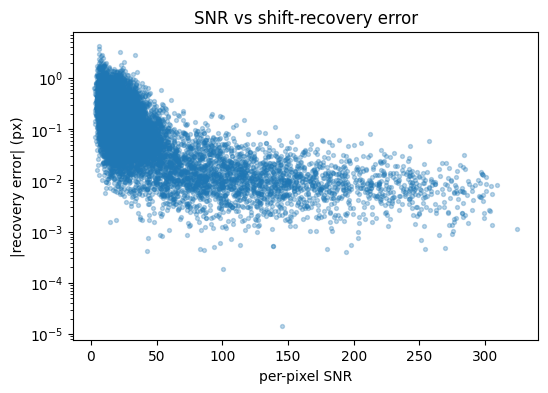

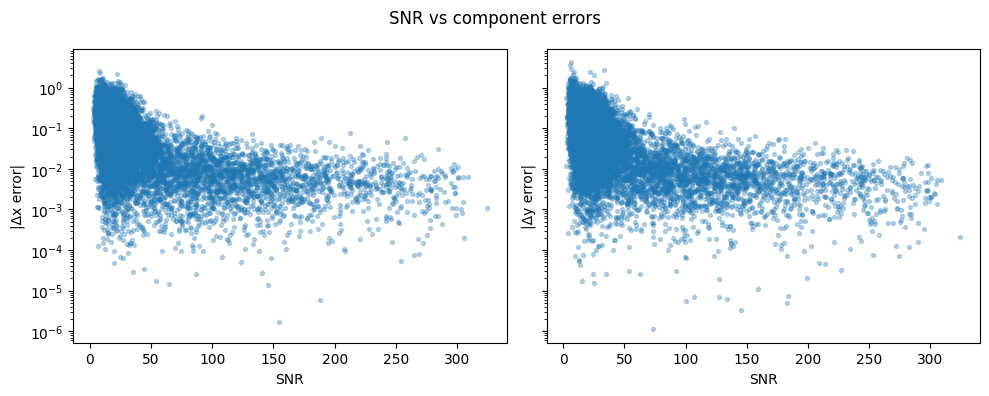

In [19]:
# ───────── SNR vs recovery-error scatter ───────────────────────────────
import numpy as np
import matplotlib.pyplot as plt

# ---------- user knobs --------------------------------------------------
LOG_AXIS_x      = False      # put both axes on log scale
LOG_AXIS_y      = True       # put both axes on log scale
PLOT_COMPONENTS = True   # also plot |Δx| and |Δy| separately
# -----------------------------------------------------------------------

# 1) one representative distorted + noisy frame (zero-tilt)
dist0_sup = warp(psf0_sup, field_sup_base)
meas0_sup = dist0_sup * rho_sup2d_base

# photon + read variance on the supersample grid
var0_sup  = meas0_sup + read_var
# down-sample signal & variance to detector grid
signal_det = downsample(meas0_sup, ovsp)            # (128,128)
# variance of a mean over ovsp² pixels = mean(var)/ovsp²
var_det    = downsample(var0_sup,  ovsp) / (ovsp*ovsp)

snr_det = signal_det / np.sqrt(var_det)             # per-pixel SNR

# 2) per-pixel recovery error
rec_dx_px = -dx_det / arcsec_det                    # recovered shift in px
rec_dy_px = -dy_det / arcsec_det

err_dx = rec_dx_px - shift_det[...,0]
err_dy = rec_dy_px - shift_det[...,1]
err_mag = np.sqrt(err_dx**2 + err_dy**2)            # total error magnitude

# flatten and mask any nan/inf
m = np.isfinite(snr_det) & np.isfinite(err_mag)
snr_flat = snr_det[m].ravel()
err_flat = err_mag[m].ravel()

# 3) scatter plot --------------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(snr_flat, err_flat, s=8, alpha=0.3)
ax.set_xlabel("per-pixel SNR")
ax.set_ylabel("|recovery error| (px)")
if LOG_AXIS_x:
    ax.set_xscale('log')
if LOG_AXIS_y:
    ax.set_yscale('log')
ax.set_title("SNR vs shift-recovery error")

# optional component plots
if PLOT_COMPONENTS:
    fig2, (ax2, ax3) = plt.subplots(1,2,figsize=(10,4), sharey=True)
    ax2.scatter(snr_det[m], np.abs(err_dx[m]), s=8, alpha=0.3)
    ax3.scatter(snr_det[m], np.abs(err_dy[m]), s=8, alpha=0.3)
    for a, lab in zip((ax2,ax3), ("|Δx error|","|Δy error|")):
        a.set_xlabel("SNR"); a.set_ylabel(lab)
        if LOG_AXIS_x:
            a.set_xscale('log')
        if LOG_AXIS_y:
            a.set_yscale('log')
    fig2.suptitle("SNR vs component errors")

plt.tight_layout()
plt.show()


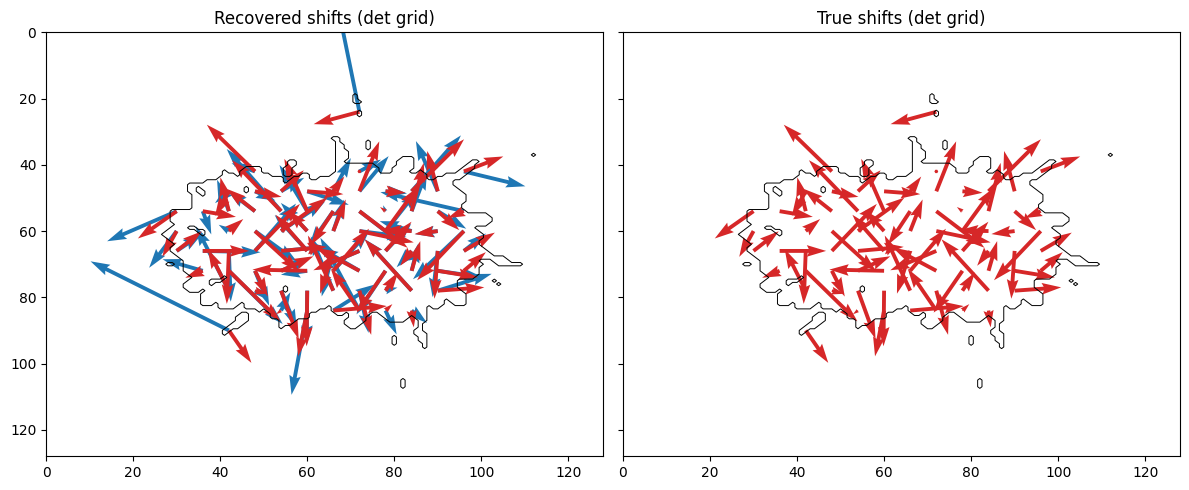

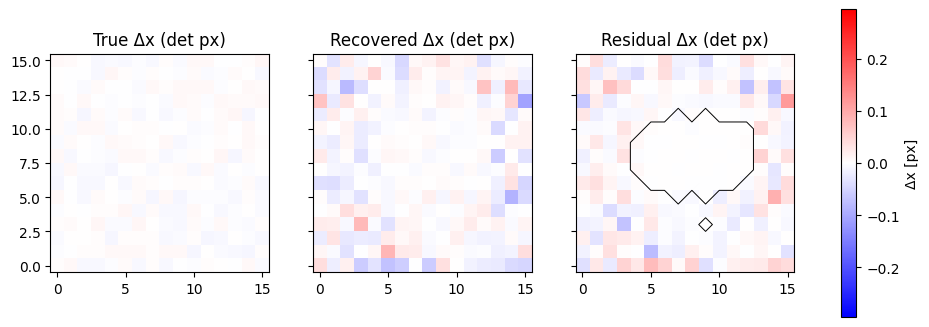

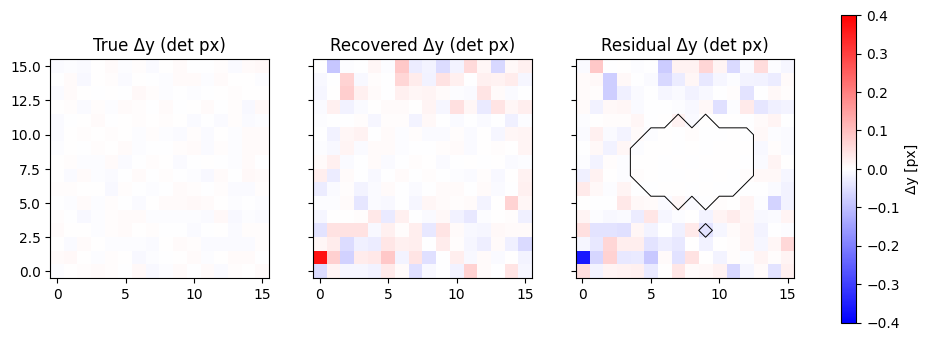

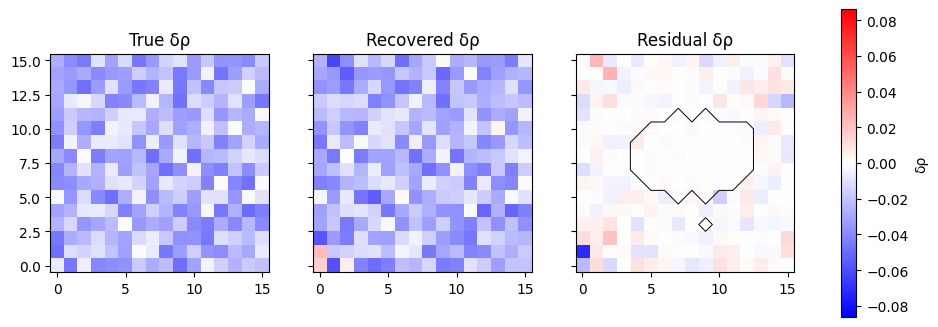

In [47]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np

# ───────────────────── user-adjustable knobs ────────────────────────────
PLOT_FRAC_QUIV = 0.03    # fraction of PSF peak to KEEP in quiver / heat-maps (0 → all)
PLOT_FRAC_HM   = 0
CONTOUR_FRAC   = 0.03    # brightness threshold for the outline (0 → draw rectangle)
SHOW_CONTOUR   = True    # master True / False
QUIVER_STEP    = 6       # stride for quiver sampling
HM_SUBSAMPLE   = 8       # stride for heat-map subsample
QUIVER_SCALE   = 0.1    # quiver arrow scale
# ─────────────────────────────────────────────────────────────────────────

# 1) build masks on the 128×128 detector grid
mean_psf = np.mean(ideal, axis=0)
peak     = mean_psf.max()

mask_plot_QUIV    = mean_psf > PLOT_FRAC_QUIV    * peak if PLOT_FRAC_QUIV    > 0 else np.ones_like(mean_psf, bool)
mask_plot_HM      = mean_psf > PLOT_FRAC_HM  * peak if PLOT_FRAC_HM  > 0 else np.ones_like(mean_psf, bool)
mask_contour = mean_psf > CONTOUR_FRAC * peak if CONTOUR_FRAC > 0 else np.ones_like(mean_psf, bool)

def add_outline(ax, msk, full_shape):
    """Draw contour for `msk`; if msk is all-True, draw a rectangle."""
    if not SHOW_CONTOUR:
        return
    if msk.all():                    # all-True → no boundary → draw box
        H, W = full_shape
        ax.add_patch(plt.Rectangle((0, 0), W, H,
                                   fill=False, lw=0.7, ec='k'))
    else:                            # draw boundary of mask
        ax.contour(msk, levels=[0.5], colors='k', linewidths=0.7)


# 2) QUIVER plot ─────────────────────────────────────────────────────────
H, W  = dx_det.shape
Yf, Xf = np.indices((H, W))

Xs, Ys = Xf[::QUIVER_STEP, ::QUIVER_STEP], Yf[::QUIVER_STEP, ::QUIVER_STEP]
valid  = mask_plot_QUIV[::QUIVER_STEP, ::QUIVER_STEP]

Xq, Yq = Xs[valid], Ys[valid]
Uq = -dx_det[::QUIVER_STEP, ::QUIVER_STEP] / arcsec_det;  Uq = Uq[valid]
Vq = -dy_det[::QUIVER_STEP, ::QUIVER_STEP] / arcsec_det;  Vq = Vq[valid]
Ut =  shift_det[..., 0][::QUIVER_STEP, ::QUIVER_STEP][valid]
Vt =  shift_det[..., 1][::QUIVER_STEP, ::QUIVER_STEP][valid]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
ax1.quiver(Xq, Yq, Uq, Vq, scale=QUIVER_SCALE, color='C0', label='Recovered (det grid)')
ax1.quiver(Xq, Yq, Ut, Vt, scale=QUIVER_SCALE, color='C3' , label='True (det grid)')
add_outline(ax1, mask_contour, full_shape=(H, W))
ax1.set_title("Recovered shifts (det grid)")
ax1.set_xlim(0, W);  ax1.set_ylim(H, 0)

ax2.quiver(Xq, Yq, Ut, Vt, scale=QUIVER_SCALE, color='C3')
add_outline(ax2, mask_contour, full_shape=(H, W))
ax2.set_title("True shifts (det grid)")
ax2.set_xlim(0, W);  ax2.set_ylim(H, 0)

plt.tight_layout()
plt.show()


# 3) helper for 3-panel heat-maps (contour only on residual) ─────────────
def triple_heat(true, rec, title, label):
    t = true.copy();  r = rec.copy()
    t[~mask_plot_HM] = np.nan;  r[~mask_plot_HM] = np.nan
    res = t - r

    vmax = np.nanmax(np.abs([t, r]))
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=+vmax)

    t_sub   = t  [::HM_SUBSAMPLE, ::HM_SUBSAMPLE]
    r_sub   = r  [::HM_SUBSAMPLE, ::HM_SUBSAMPLE]
    res_sub = res[::HM_SUBSAMPLE, ::HM_SUBSAMPLE]
    mask_sub = mask_contour[::HM_SUBSAMPLE, ::HM_SUBSAMPLE]

    fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 5),
                                     sharex=True, sharey=True)
    im0 = a0.imshow(t_sub,  origin='lower', cmap='bwr', norm=norm)
    im1 = a1.imshow(r_sub,  origin='lower', cmap='bwr', norm=norm)
    im2 = a2.imshow(res_sub, origin='lower', cmap='bwr', norm=norm)

    # draw outline only on the residual panel
    add_outline(a2, mask_sub, full_shape=res_sub.shape)

    a0.set_title(f"True {title}")
    a1.set_title(f"Recovered {title}")
    a2.set_title(f"Residual {title}")
    fig.colorbar(im1, ax=[a0, a1, a2], shrink=0.8, label=label)
    plt.show()


# 4) heat-maps for Δx, Δy, δρ ───────────────────────────────────────────
triple_heat(shift_det[..., 0],
            -dx_det/arcsec_det,
            'Δx (det px)', 'Δx [px]')

triple_heat(shift_det[..., 1],
            -dy_det/arcsec_det,
            'Δy (det px)', 'Δy [px]')

triple_heat(delta_rho,
            dr_det,
            'δρ', 'δρ')


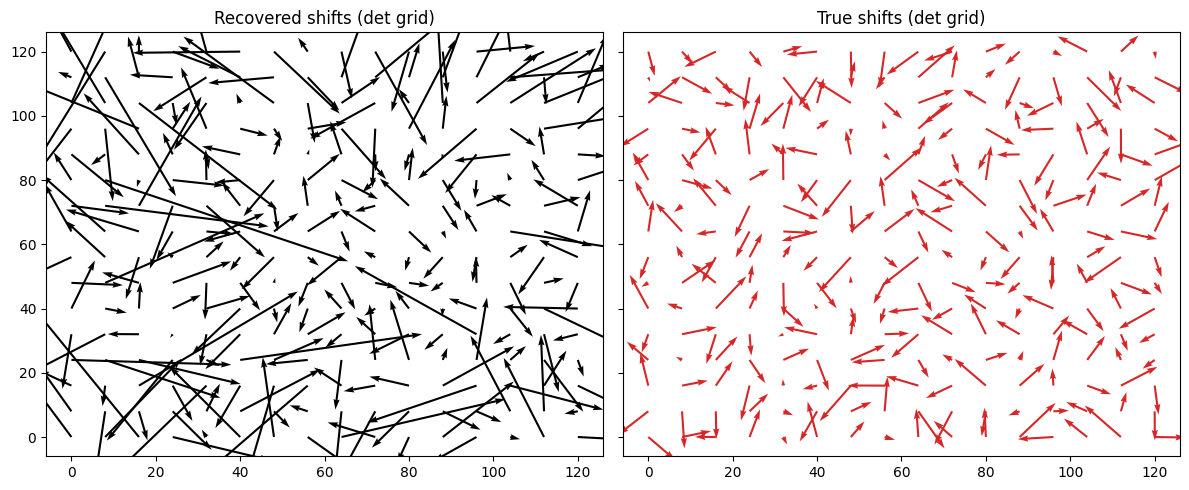

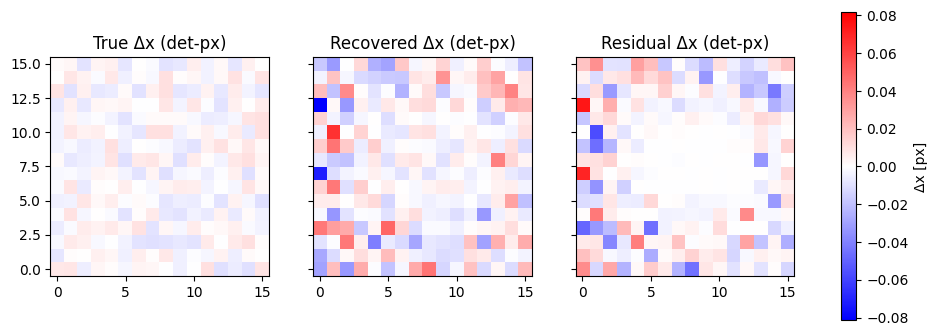

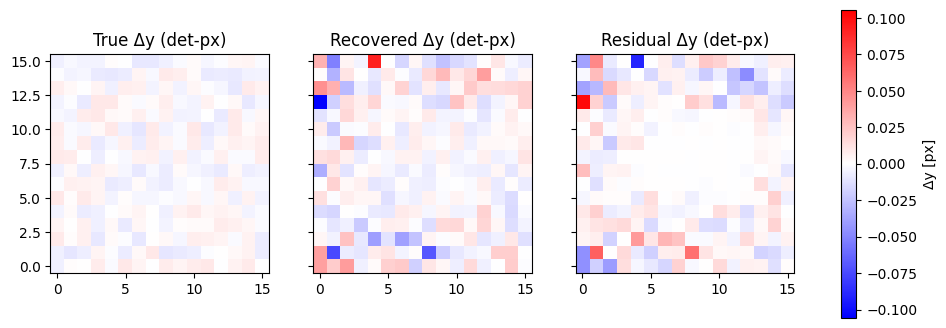

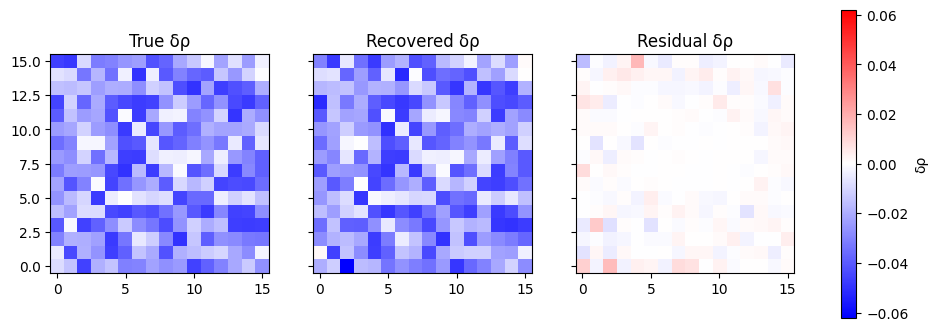

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np

# --- make sure arcsec_det is defined (reuse from main script) ---
# arcsec_det = opt.psf_pixel_scale

# ───────── quiver plot of recovered vs true shifts ─────────────────────────
step = 8
H, W = dx_det.shape
X_full, Y_full = np.meshgrid(np.arange(W), np.arange(H))
X, Y = X_full[::step, ::step], Y_full[::step, ::step]

# recovered detector‐grid shifts (convert arcsec → pixels)
Ur = (-dx_det / arcsec_det)[::step, ::step]
Vr = (-dy_det / arcsec_det)[::step, ::step]

# true detector‐grid shifts (already in pixels)
Ut = shift_det[...,0][::step, ::step]
Vt = shift_det[...,1][::step, ::step]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
ax1.quiver(X, Y, Ur, Vr, scale=0.15)
ax1.set_title("Recovered shifts (det grid)")
ax1.invert_yaxis()

ax2.quiver(X, Y, Ut, Vt, scale=0.15, color='C3')
ax2.set_title("True shifts (det grid)")
ax2.invert_yaxis()

plt.tight_layout()
plt.show()


# ───────── helper for 3-panel heatmaps ──────────────────────────────────────
def triple_heat(true, rec, title, label):
    vmax = max(abs(true).max(), abs(rec).max())
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12,5),
                                        sharex=True, sharey=True)
    im0 = ax0.imshow(true, origin='lower', cmap='bwr', norm=norm)
    ax0.set_title(f"True {title}")

    im1 = ax1.imshow(rec, origin='lower', cmap='bwr', norm=norm)
    ax1.set_title(f"Recovered {title}")

    im2 = ax2.imshow(true - rec, origin='lower', cmap='bwr', norm=norm)
    ax2.set_title(f"Residual {title}")

    fig.colorbar(im1, ax=[ax0,ax1,ax2], shrink=0.8, label=label)
    plt.show()


# ───────── heatmaps for Δx, Δy and δρ ──────────────────────────────────────
step_hm = 8

# true shifts (in px)
true_dx = shift_det[...,0][::step_hm, ::step_hm]
true_dy = shift_det[...,1][::step_hm, ::step_hm]

# recovered shifts (convert arcsec → px)
rec_dx  = (-dx_det / arcsec_det)[::step_hm, ::step_hm]
rec_dy  = (-dy_det / arcsec_det)[::step_hm, ::step_hm]

# QE true & recovered (already unitless)
true_rho = delta_rho[::step_hm, ::step_hm]
rec_rho  = dr_det   [::step_hm, ::step_hm]

triple_heat(true_dx, rec_dx, 'Δx (det-px)', 'Δx [px]')
triple_heat(true_dy, rec_dy, 'Δy (det-px)', 'Δy [px]')
triple_heat(true_rho, rec_rho, 'δρ',       'δρ')


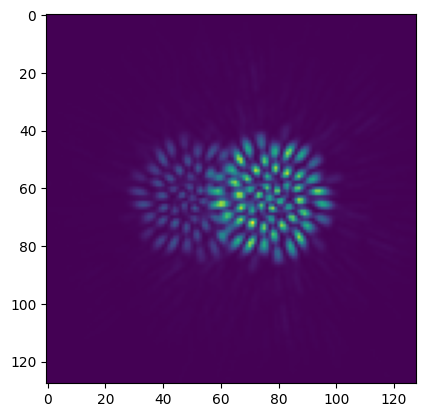

In [9]:
plt.imshow(ideal[0])
plt.show()

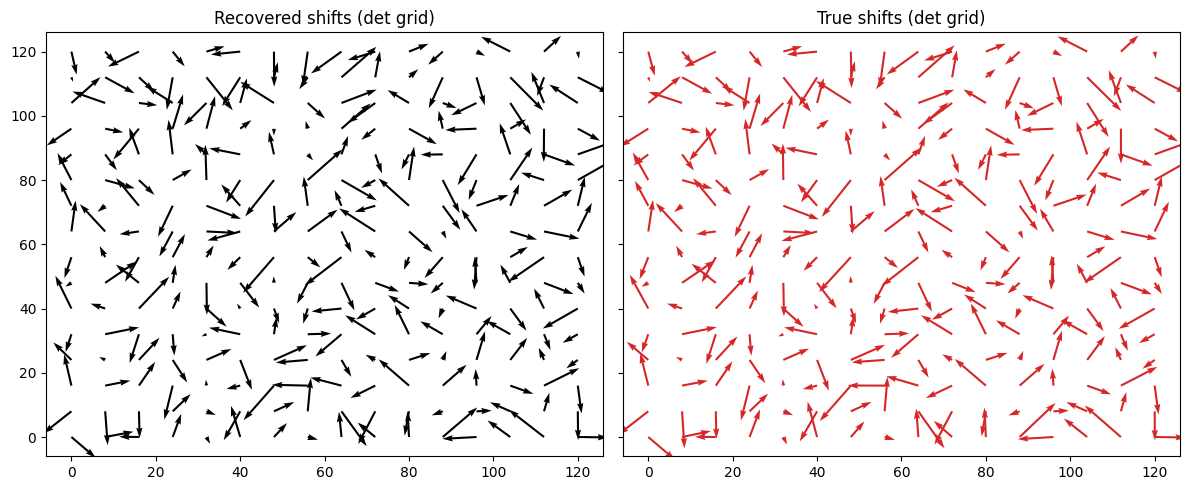

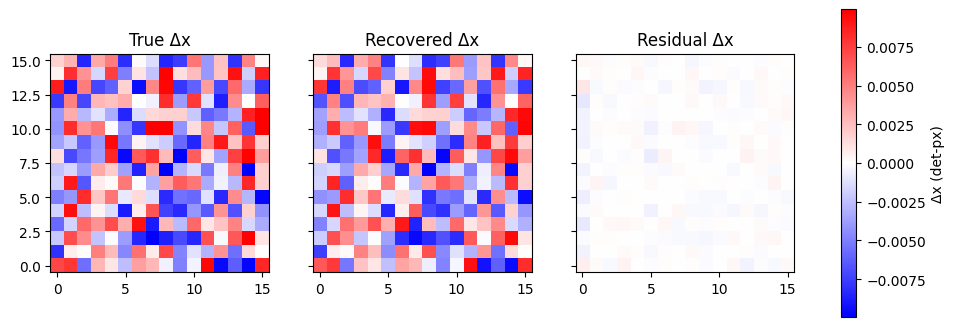

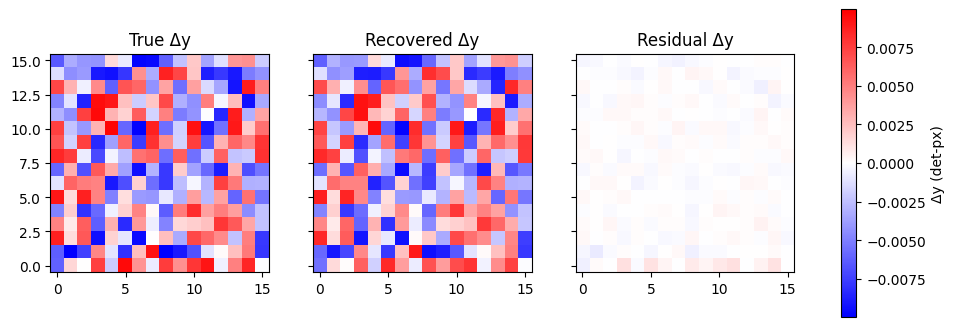

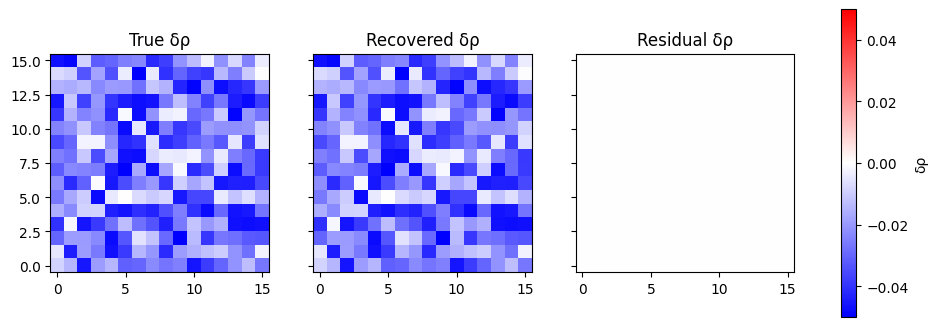

In [8]:
# residual plots for x and y dislocation as well as QE
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np

# quiver plot ------------------------------------------------------------
step = 8
X_full, Y_full = np.meshgrid(np.arange(128), np.arange(128))
X, Y = X_full[::step,::step], Y_full[::step,::step]

Ur, Vr = est_shift_det[...,0][::step,::step], est_shift_det[...,1][::step,::step]
Ut, Vt = field_det     [...,0][::step,::step], field_det     [...,1][::step,::step]

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax1.quiver(X,Y,Ur,Vr,scale=0.15);  ax1.set_title("Recovered shifts (det grid)"); ax1.invert_yaxis()
ax2.quiver(X,Y,Ut,Vt,scale=0.15,color='C3'); ax2.set_title("True shifts (det grid)"); ax2.invert_yaxis()
plt.tight_layout(); plt.show()

# helper to plot triple heat-map -----------------------------------------
def triple_heat(true, rec, ttl, lbl):
    res = true - rec
    vmax = max(abs(true).max(), abs(rec).max())
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)
    fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(12,5),sharex=True,sharey=True)
    im0=ax0.imshow(true, origin='lower', cmap='bwr', norm=norm); ax0.set_title(f'True {ttl}')
    im1=ax1.imshow(rec , origin='lower', cmap='bwr', norm=norm); ax1.set_title(f'Recovered {ttl}')
    im2=ax2.imshow(res , origin='lower', cmap='bwr', norm=norm); ax2.set_title(f'Residual {ttl}')
    fig.colorbar(im1, ax=[ax0,ax1,ax2], shrink=0.8, label=lbl)
    plt.show()

# Δx, Δy and δρ heat-maps -----------------------------------------------------
step_hm = 8
true_dx = field_det[::step_hm,::step_hm,0]
true_dy = field_det[::step_hm,::step_hm,1]
rec_dx  = est_shift_det[::step_hm,::step_hm,0]
rec_dy  = est_shift_det[::step_hm,::step_hm,1]
true_rho = delta_rho[::step_hm, ::step_hm]
rec_rho  = est_rho_det[::step_hm, ::step_hm]  


triple_heat(true_dx, rec_dx, 'Δx', 'Δx (det-px)')
triple_heat(true_dy, rec_dy, 'Δy', 'Δy (det-px)')
triple_heat(true_rho, rec_rho, 'δρ', 'δρ')

In [ ]:
# Jaxified autodiff with downsampling, but not as efficient because we need to convert to numpy during the process because there is no jax version of map_coordinates

import numpy as np
import jax
import jax.numpy as jnp
from jax import jacfwd, vmap
from scipy.ndimage import map_coordinates
import dLuxToliman

# ───────────── helper functions ───────────────────────────────
def warp(img, field_sup, order=2):
    dy, dx = field_sup[...,1], field_sup[...,0]
    y, x   = np.indices(img.shape)
    return map_coordinates(img, [y - dy, x - dx], order=order, mode="reflect")

def downsample(img, factor):
    h, w = img.shape
    return img.reshape(h//factor, factor, w//factor, factor).mean(axis=(1,3))

# ───────────── 1) Setup optics & dithers ─────────────────────
opt        = dLuxToliman.TolimanOpticalSystem(
    wf_npixels=256, psf_npixels=128, oversample=4)
ovsp       = opt.oversample
arcsec_det = opt.psf_pixel_scale
arcsec_sup = arcsec_det / ovsp

dith_det_px = [(0.0,0.0),(+0.2,0.0),(-0.2,0.0),(0.0,+0.2),(0.0,-0.2)]
dith_arcsec = jnp.array([(dx*arcsec_det, dy*arcsec_det) for dx,dy in dith_det_px])  # (K,2)

# ───────────── 2) PSF + autodiff ─────────────────────────────
def psf_from_tilt(tt: jnp.ndarray) -> jnp.ndarray:
    dx, dy = tt
    src = dLuxToliman.sources.AlphaCen(n_wavels=5, separation=10., position_angle=90., x_position=dx, y_position=dy)
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model()  # (H, W)

# vectorize PSF and its Jacobian
ideal_jax = vmap(psf_from_tilt)(dith_arcsec)  # (K, H, W)
grad_fn   = jacfwd(psf_from_tilt)
grads_jax = vmap(grad_fn)(dith_arcsec)        # (K, H, W, 2)
Gx_jax    = grads_jax[..., 0]                  # (K, H, W)
Gy_jax    = grads_jax[..., 1]

# ───────────── 3) True shift field & distortion ──────────────
rng       = np.random.default_rng(0)
mask_det  = rng.random((128,128)) < 0.25
shift_det = rng.uniform(-0.01,0.01,(128,128,2)) * mask_det[...,None]
# upsample to supersampling
field_sup = np.kron(shift_det*ovsp, np.ones((ovsp,ovsp,1)))  # (512,512,2)

# warp each ideal PSF
ideal_np  = np.asarray(ideal_jax)
dist_np   = np.stack([warp(im, field_sup) for im in ideal_np])  # (K,512,512)
# convert to jax arrays for solve
ideal_j   = jnp.array(ideal_np)
dist_j    = jnp.array(dist_np)
R_j       = ideal_j - dist_j                                            # (K,H,W)

# ───────────── 4) Build Gstack & Rstack ──────────────────────
# transpose to per-pixel batches: (H,W,K,2) and (H,W,K)
Gstack = jnp.transpose(grads_jax, (1,2,0,3))  # (H, W, K, 2)
Rstack = jnp.transpose(R_j,       (1,2,0))    # (H, W, K)

# ───────────── 5) Pinv solve via vmap ────────────────────────
def solve_pixel(G_i: jnp.ndarray, r_i: jnp.ndarray) -> jnp.ndarray:
    # G_i: (K,2), r_i: (K,)
    return jnp.linalg.pinv(G_i) @ r_i          # shape (2,)

# vectorize over rows and cols
solve_row = vmap(solve_pixel, in_axes=(0, 0), out_axes=0)        # over W dim
solve_all = vmap(solve_row,    in_axes=(0, 0), out_axes=0)       # over H dim
delta_xy = solve_all(Gstack, Rstack)                            # (H, W, 2)

dx_arc = delta_xy[..., 0]
dy_arc = delta_xy[..., 1]

# ───────────── 6) Deblur & diagnostics ───────────────────────
est_sup = jnp.stack([-dx_arc/arcsec_sup, -dy_arc/arcsec_sup], axis=-1)
# use numpy warp since jnp warp not available
dist0   = dist_np[0]
undist  = warp(dist0, np.asarray(est_sup))  # back to numpy

chi_dist = jnp.sum((ideal_j[0] - dist_j[0])**2)
chi_corr = jnp.sum((ideal_j[0] - jnp.array(undist))**2)
print(f"χ² distorted (512²): {chi_dist:,.0f}")
print(f"χ² corrected (512²): {chi_corr:,.0f}\n")

# ───────────── 7) Downsample & stats ─────────────────────────
ideal_det   = downsample(ideal_np[0], ovsp)
dist_det    = downsample(dist_np[0],  ovsp)
undist_det  = downsample(undist,     ovsp)
est_det     = np.asarray(est_sup).reshape(128,ovsp,128,ovsp,2).mean(axis=(1,3))
mask        = mask_det

def stats(arr, mask=None):
    a = arr[mask] if mask is not None else arr
    dx, dy = a[...,0], a[...,1]
    return jnp.mean(jnp.abs(dx)), jnp.mean(jnp.abs(dy)), jnp.mean(jnp.hypot(dx, dy))

mx_t, my_t, mr_t = stats(shift_det, mask)
mx_e, my_e, mr_e = stats(est_det/ovsp, mask)
print("― mean shift per pixel (det-px) ―")
print(f"TRUE active : ⟨|Δx|⟩={mx_t:.4f}, ⟨|Δy|⟩={my_t:.4f}, ⟨r⟩={mr_t:.4f}")
print(f"RECOV active: ⟨|Δx|⟩={mx_e:.4f}, ⟨|Δy|⟩={my_e:.4f}, ⟨r⟩={mr_e:.4f}")


In [ ]:
# ───────── per-pixel Δx, Δy, δρ recovery with random dithers & read+shot noise ─────
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import jacfwd, vmap
from scipy.ndimage import map_coordinates
import dLuxToliman

# -------------------------------------------------------------------- utilities ---
def warp(img, field_sup, order=2):
    """Shift image by a super-pixel vector field (512×512×2)."""
    dy, dx = field_sup[..., 1], field_sup[..., 0]
    y, x   = np.indices(img.shape)
    return map_coordinates(img, [y - dy, x - dx], order=order, mode="reflect")

def downsample(img, factor):
    """Average non-overlapping factor×factor blocks (convert super→det grid)."""
    h, w = img.shape
    return img.reshape(h//factor, factor, w//factor, factor).mean(axis=(1,3))

# random-dither generator -----------------------------------------------------------
def get_dither_offsets_random(k, scale, r_factor=1.0, key=None):
    """
    Return k (odd) random 2-D offsets with one at (0,0).
      * scale     : basic pixel scale (arcsec or rad) to multiply offsets
      * r_factor  : radial spread multiplier
    """
    if k % 2 == 0:
        raise ValueError("k must be an odd number.")
    if key is None:
        key = jr.PRNGKey(0)
    if k == 1:
        return scale * jnp.array([[0., 0.]])
    rand = jr.uniform(key, (k-1, 2), minval=-scale*r_factor, maxval= scale*r_factor)
    return jnp.vstack([jnp.zeros((1,2)), rand])

# 1) optics ------------------------------------------------------------------------
opt = dLuxToliman.TolimanOpticalSystem(wf_npixels=256,
                                       psf_npixels=128,
                                       oversample=4)
ovsp        = opt.oversample
arcsec_det  = opt.psf_pixel_scale
arcsec_sup  = arcsec_det / ovsp

# 2) build K random dither offsets --------------------------------------------------
K  = 101                           # any odd number ≥ 1
key_dithers = jr.PRNGKey(123)
dith_arc    = get_dither_offsets_random(K, arcsec_det, r_factor=1.0, key=key_dithers)
# dith_det  = [(0,0),(+0.2,0),(-0.2,0),(0,+0.2),(0,-0.2)]
# dith_arc  = jnp.array([(dx*arcsec_det, dy*arcsec_det) for dx,dy in dith_det])


# 3) ideal PSF stack & gradients (autodiff) ----------------------------------------
def psf_from_tilt(tt):
    dx, dy = tt
    src = dLuxToliman.sources.AlphaCen(n_wavels=5, separation=10.,
                                       position_angle=90.,
                                       x_position=dx, y_position=dy)
    return dLuxToliman.telescopes.Toliman(opt, src).model()      # (512,512)

ideal_jax = vmap(psf_from_tilt)(dith_arc)           # (K,H,W)
grad_fn   = jacfwd(psf_from_tilt)
grads_jax = vmap(grad_fn)(dith_arc)                 # (K,H,W,2)

ideal = np.asarray(ideal_jax)
gx    = np.asarray(grads_jax[...,0])
gy    = np.asarray(grads_jax[...,1])

# 4) truth fields -------------------------------------------------------
rng         = np.random.default_rng(0)
mask_shift  = rng.random((128,128)) < 1.0
mask_qe     = rng.random((128,128)) < 1.0

shift_det = rng.uniform(-0.01,0.01,(128,128,2)) * mask_shift[...,None]
delta_rho = rng.uniform(-0.05,0.0,(128,128))    * mask_qe
rho_det   = 1.0 + delta_rho

field_sup = np.kron(shift_det*ovsp, np.ones((ovsp,ovsp,1)))   # (512,512,2)
rho_sup2d = np.kron(rho_det,      np.ones((ovsp,ovsp)))       # (512,512)

# 5a) noiseless measured stack -----------------------------------------
dist = np.stack([warp(im, field_sup) for im in ideal])
meas = dist * rho_sup2d[None,...]

# 5b) add shot-noise + read-noise (Gaussian) ----------------------------
read_sigma = 3.27
jr_key     = jr.PRNGKey(0)
ph_sigma   = np.sqrt(meas)                    # √signal  (signal in e⁻)
sigma_tot  = np.sqrt(ph_sigma**2 + read_sigma**2)
jr_key, subkey = jr.split(jr_key)
noise = sigma_tot * jr.normal(subkey, shape=meas.shape)
meas  = meas + noise                          # noisy measurements

# 6) per-pixel 3-parameter ridge LS solve -------------------------------
lam = 1e-4
K,H,W = ideal.shape
R = meas - ideal

dx = np.zeros((H,W));  dy = np.zeros((H,W));  dr = np.zeros((H,W))
for i in range(H):
    # Gx_i, Gy_i, I_i = gx[:,i,:], gy[:,i,:], ideal[:,i,:]   # (K,W) each
    # R_i = R[:,i,:]
    # # pre-compute dot-products per column (vectorised across width)
    # A11 = np.sum(Gx_i*Gx_i, 0) + lam
    # A22 = np.sum(Gy_i*Gy_i, 0) + lam
    # A33 = np.sum(I_i *I_i , 0) + lam
    # A12 = np.sum(Gx_i*Gy_i, 0)
    # A13 = -np.sum(Gx_i*I_i , 0)
    # A23 = -np.sum(Gy_i*I_i , 0)
    # b1  = np.sum(Gx_i*R_i , 0)
    # b2  = np.sum(Gy_i*R_i , 0)
    # b3  = -np.sum(I_i *R_i , 0)
    # det = (A11*A22*A33 + 2*A12*A13*A23 -
    #        A11*A23*A23 - A22*A13*A13 - A33*A12*A12) + 1e-15
    # dx[i]=( (A22*A33 - A23*A23)*b1 + (-A12*A33 + A13*A23)*b2 + (-A13*A22 + A12*A23)*b3) / det
    # dy[i]=( (-A12*A33 + A13*A23)*b1 + (A11*A33 - A13*A13)*b2 + (-A11*A23 + A12*A13)*b3) / det
    # dr[i]=( (-A13*A22 + A12*A23)*b1 + (-A11*A23 + A12*A13)*b2 + (A11*A22 - A12*A12)*b3) / det
    for j in range(W):
        G = np.stack([-gx[:, i, j],
                        -gy[:, i, j],
                        ideal[:, i, j]], axis=1)   # (K, 3)
        r = R[:, i, j]                            # (K,)

        sol = np.linalg.solve(G.T @ G + lam*np.eye(3),  G.T @ r)
        dx[i, j], dy[i, j], dr[i, j] = sol

# 7) χ²  ---------------------------------------------------------------
est_sup = np.stack([-dx/arcsec_sup, -dy/arcsec_sup], axis=-1)
undist  = warp(dist[0], -est_sup)
print(f'χ² distorted : {np.sum((ideal[0]-dist[0])**2):,.0f}')
print(f'χ² corrected : {np.sum((ideal[0]-undist )**2):,.0f}')

# 8) detector-grid truth & estimates ------------------------------------
field_det = (field_sup.reshape(128,ovsp,128,ovsp,2).mean(axis=(1,3))) / ovsp

est_shift_det = np.stack([
    -(dx.reshape(128,ovsp,128,ovsp).mean(axis=(1,3))) / arcsec_det,
    -(dy.reshape(128,ovsp,128,ovsp).mean(axis=(1,3))) / arcsec_det
], axis=-1)
est_rho_det = dr.reshape(128,ovsp,128,ovsp).mean(axis=(1,3))

def mabs(a,m): return np.mean(np.abs(a[m]))
print('Mean |Δx| :', mabs(est_shift_det[...,0], mask_shift))
print('Mean |Δy| :', mabs(est_shift_det[...,1], mask_shift))
print('Mean |δρ| :', mabs(est_rho_det,            mask_qe))


In [11]:
#!/usr/bin/env python3
import time

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, jacfwd
from jax.scipy.ndimage import map_coordinates
import dLuxToliman

# ──────────────────────── your original warp helper ─────────────────────────
def warp_np(img, field_sup, order=1):
    dy, dx = field_sup[..., 1], field_sup[..., 0]
    y, x = np.indices(img.shape)
    return map_coordinates(img, [y - dy, x - dx],
                           order=order, mode="reflect")

@jit
def warp_jax(img, field_sup):
    """Bilinear warp in JAX (order=1) for the correction step."""
    dy, dx = field_sup[..., 1], field_sup[..., 0]
    H, W = img.shape
    yy, xx = jnp.meshgrid(jnp.arange(H, dtype=jnp.float32),
                          jnp.arange(W, dtype=jnp.float32),
                          indexing="ij")
    coords = jnp.stack([yy - dy, xx - dx])
    return map_coordinates(img, coords, order=1, mode="reflect")


# ─────────────── vectorised LS solve: same G = [-Ix,-Iy,I] ──────────────────
@jit
def recover_qe_and_shifts(meas, ideal, grads, lam=1e-4):
    """
    meas, ideal : (K,H,W)
    grads        : (K,H,W,2) from jacfwd = [dI/dy, dI/dx]
    returns QE, dx, dy each shape (H,W)
    """
    # unpack and swap to match your G = [-Ix, -Iy, I] columns
    I_y = grads[..., 0]   # ∂I/∂y
    I_x = grads[..., 1]   # ∂I/∂x

    K, H, W = meas.shape
    P = H * W

    I   = ideal.reshape(K, P)
    Ix  = I_x.reshape(K, P)
    Iy  = I_y.reshape(K, P)
    R   = (meas - ideal).reshape(K, P)

    # build the 6 unique entries of GᵀG
    S_Ix2   = jnp.sum(Ix*Ix,   axis=0)
    S_IxIy  = jnp.sum(Ix*Iy,   axis=0)
    S_IxI   = jnp.sum(I   *Ix, axis=0)
    S_Iy2   = jnp.sum(Iy*Iy,   axis=0)
    S_IyI   = jnp.sum(I   *Iy, axis=0)
    S_I2    = jnp.sum(I   *I,  axis=0)

    # build the RHS = Gᵀ R
    b0 = -jnp.sum(Ix * R, axis=0)   # matches -gx in your loop
    b1 = -jnp.sum(Iy * R, axis=0)   # matches -gy in your loop
    b2 =  jnp.sum(I   * R, axis=0)   # matches +I in your loop

    mats = jnp.stack([S_Ix2, S_IxIy, S_IxI,
                      S_Iy2, S_IyI,  S_I2], axis=1)  # (P,6)
    rhs  = jnp.stack([b0, b1, b2], axis=1)            # (P,3)

    def solve_pixel(m, r):
        M = jnp.array([
            [m[0] + lam, m[1],      m[2]],
            [m[1],       m[3] + lam,m[4]],
            [m[2],       m[4],      m[5] + lam],
        ])
        return jnp.linalg.solve(M, r)   # [dx, dy, dρ]

    params = vmap(solve_pixel)(mats, rhs)  # (P,3)
    dx = params[:, 0].reshape(H, W)
    dy = params[:, 1].reshape(H, W)
    dr = params[:, 2].reshape(H, W)
    QE = 1.0 + dr
    return QE, dx, dy


# ═════════════════════════   main experiment   ══════════════════════════════
t0 = time.perf_counter()

# 1) optics setup (unchanged)
opt = dLuxToliman.TolimanOpticalSystem(
    wf_npixels=256, psf_npixels=128, oversample=4
)
ovsp       = opt.oversample
arcsec_det = opt.psf_pixel_scale
arcsec_sup = arcsec_det / ovsp

# 2) small dither pattern (exactly your noiseless working case)
dith_det = [(0, 0), (+0.2, 0), (-0.2, 0), (0, +0.2), (0, -0.2)]
dith_arc = jnp.array([(dx * arcsec_det, dy * arcsec_det)
                      for dx, dy in dith_det])  # (K,2)

# 3) compute ideal PSFs & autodiff gradients via jacfwd
@jit
def psf_from_tilt(tt):
    dx, dy = tt
    src = dLuxToliman.sources.AlphaCen(
        n_wavels=5, separation=10., position_angle=90.,
        x_position=dx, y_position=dy
    )
    return dLuxToliman.telescopes.Toliman(opt, src).model()  # (H_sup,W_sup)

K = len(dith_arc)
ideal_jax = vmap(psf_from_tilt)(dith_arc)                   # (K,H_sup,W_sup)
grad_fn   = jit(jacfwd(psf_from_tilt))
grads_jax = vmap(grad_fn)(dith_arc)                         # (K,H_sup,W_sup,2)

# 4) pull to NumPy for the warp+noise simulation
ideal   = np.asarray(ideal_jax)
gx      = np.asarray(grads_jax[..., 0])
gy      = np.asarray(grads_jax[..., 1])

# 5) draw truth fields
rng        = np.random.default_rng(0)
mask_shift = rng.random((128, 128)) < 1.0
mask_qe    = rng.random((128, 128)) < 1.0

shift_det  = rng.uniform(-0.01, 0.01, (128, 128, 2)) * mask_shift[..., None]
delta_rho  = rng.uniform(-0.05, 0.0, (128, 128))       * mask_qe
rho_det    = 1.0 + delta_rho

field_sup = np.kron(shift_det * ovsp, np.ones((ovsp, ovsp, 1)))   # (H_sup,W_sup,2)
rho_sup2d = np.kron(rho_det,       np.ones((ovsp, ovsp)))        # (H_sup,W_sup)

# 6) simulate noisy measurements exactly as before
dist = np.stack([warp_np(im, field_sup, order=1) for im in ideal])  # warp
meas = dist * rho_sup2d[None, ...]                                  # QE
read_sigma = 3.27
ph_sigma   = np.sqrt(meas)
tot_sigma  = np.sqrt(ph_sigma**2 + read_sigma**2)
noise      = tot_sigma * rng.standard_normal(size=meas.shape)
meas      += noise

print(f" ✓ simulation built in {time.perf_counter()-t0:.2f} s")

# 7) call our fast, fully-vectorised JAX solve (stays on GPU/CPU)
meas_jax  = jnp.asarray(meas)
ideal_jax = ideal_jax  # already on device
grads_jax = grads_jax  # already on device

t1 = time.perf_counter()
QE_est, dx_est, dy_est = recover_qe_and_shifts(meas_jax, ideal_jax, grads_jax)
print(f" ✓ LS solve finished in {time.perf_counter()-t1:.2f} s")

# 8) warp back the first frame for χ² check
undist = warp_jax(dist[0], jnp.stack([-dx_est, -dy_est], axis=-1))

chi2_dist = float(np.sum((ideal[0] - dist[0])**2))
chi2_corr = float(np.sum((ideal[0] - np.asarray(undist))**2))

# 9) diagnostic prints
print(f"\nχ² distorted : {chi2_dist:,.0f}")
print(f"χ² corrected : {chi2_corr:,.0f}")

# recovered detector-grid shifts & QE
dx_det = dx_est.reshape(128, ovsp, 128, ovsp).mean((1, 3)) / arcsec_det
dy_det = dy_est.reshape(128, ovsp, 128, ovsp).mean((1, 3)) / arcsec_det
est_shift_det = np.stack([-np.asarray(dx_det), -np.asarray(dy_det)], axis=-1)
est_rho_det   = np.asarray((QE_est - 1.0)
                           .reshape(128, ovsp, 128, ovsp)
                           .mean((1, 3)))

print("Mean |Δx| :", np.mean(np.abs(est_shift_det[..., 0])[mask_shift]))
print("Mean |Δy| :", np.mean(np.abs(est_shift_det[..., 1])[mask_shift]))
print("Mean |δρ| :", np.mean(np.abs(est_rho_det)[mask_qe]))
print(f"\nTotal time: {time.perf_counter()-t0:.2f} s")




 ✓ simulation built in 1.00 s
 ✓ LS solve finished in 0.17 s

χ² distorted : 3,658,834
χ² corrected : 65,374,773,248
Mean |Δx| : 139.71774
Mean |Δy| : 132.91063
Mean |δρ| : 60.051716

Total time: 1.38 s


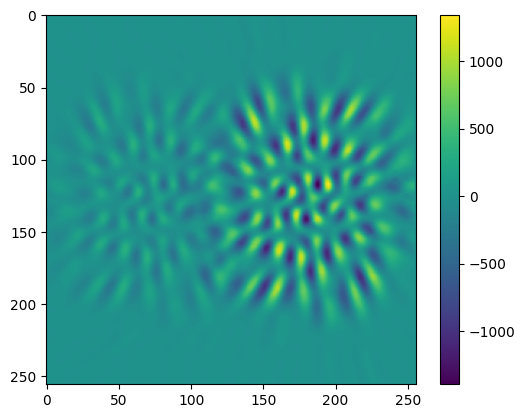

In [16]:
import matplotlib.pyplot as plt
plt.imshow(ideal_stack[0]-undist)
plt.colorbar()
plt.show()